## Notes

We are weighting based on time (more recent reports are weighted more heavily when fitting data).

We have scant data past early November, and data around that point in time is suffereing from delays in reporting.


In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

In [2]:
def seir(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y[:4]),
        p[1]*y[0]*y[2]/sum(y[:4]) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[0]*y[2],
        p[2]*y[1]
    ]

In [3]:
the_data = pd.read_csv("../samoa/samoa-data/samoa_press_release_data.csv", header=0, dayfirst=True, parse_dates=True, skiprows=[1])
raw_times, raw_cumdata, H, cH, D, G = the_data.iloc[:,1:].values.T

In [4]:
start = 1
clip = None
times = raw_times[start:(-clip if clip else None)] + 33
cumdata = raw_cumdata[start:(-clip if clip else None)]

Text(0.5, 0, 'Days after 28 August 2019')

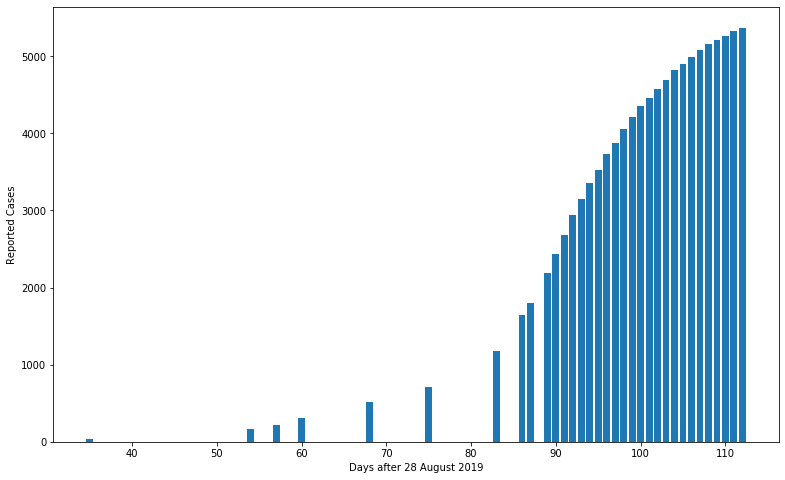

In [5]:
plt.figure(figsize=[13,8])
plt.bar(times, cumdata)
plt.ylabel("Reported Cases")
plt.xlabel("Days after 28 August 2019")

Text(0.5, 0, 'Days after 28 August 2019')

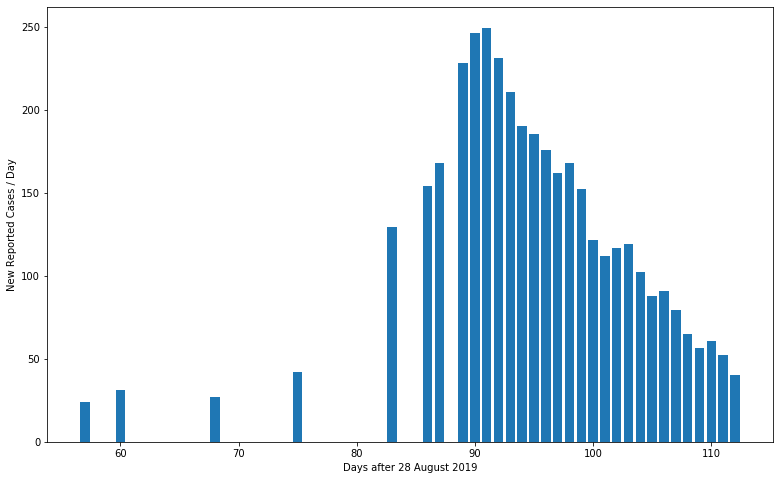

In [6]:
plt.figure(figsize=[13,8])
plt.bar(times, np.gradient(cumdata, times))
plt.ylabel("New Reported Cases / Day")
plt.xlabel("Days after 28 August 2019")

In [7]:
data_pd = np.array([[i] for i in cumdata])
p0 = [1/8, 1, 1/8]
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": {
        "state": 5,
        "parameters": 3
    },
    "time_span": [times[0], 130],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(times)},
    "observation_vector": [-1],
    "weightings":[
        [1]*5,
        np.sqrt(times/np.mean(times))
    ],
    "regularisation_value": copy(p0),
}

In [8]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [9]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [10]:
c0 = [max(cumdata)*np.ones(config['basis_number']) for _ in range(5)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*5) + [0]*len(config['regularisation_value'])
alpha = 1e3

In [11]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

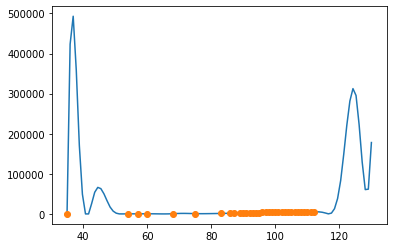

In [12]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(times, cumdata, 'o')

In [13]:
lbg = [0]*len(model.observation_times)*config['model_form']['state']
ubg = [140000]*len(model.observation_times)*config['model_form']['state']
# lbg[0] = 150000

In [14]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': lbg,
        'ubg': ubg
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

  60  1.0608469e+02 0.00e+00 1.74e-03  -8.6 1.95e+03 -14.2 4.64e-01 6.24e-01f  1
  70  1.0608468e+02 0.00e+00 7.29e-07  -8.6 7.54e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 74

                                   (scaled)                 (unscaled)
Objective...............:   1.0608467509051063e+02    1.0608467509051063e+02
Dual infeasibility......:   7.1771772978476667e-12    7.1771772978476667e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   2.5059035596800626e-09    2.5059035596800626e-09


Number of objective function evaluations             = 89
Number of objective gradient evaluations             = 75
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 89
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 75
Num

Number of inequality constraint evaluations          = 102
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 92
Number of Lagrangian Hessian evaluations             = 91
Total CPU secs in IPOPT (w/o function evaluations)   =      0.164
Total CPU secs in NLP function evaluations           =      0.047

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.92ms ( 28.61us)   2.94ms ( 28.83us)       102
       nlp_g  |   1.44ms ( 14.14us)   1.42ms ( 13.97us)       102
    nlp_grad  |  63.00us ( 63.00us)  62.45us ( 62.45us)         1
  nlp_grad_f  |   5.28ms ( 56.81us)   5.31ms ( 57.10us)        93
  nlp_hess_l  |  35.21ms (386.89us)  35.15ms (386.27us)        91
   nlp_jac_g  |   1.61ms ( 17.34us)   1.64ms ( 17.60us)        93
       total  | 216.66ms (216.66ms) 215.17ms (215.17ms)         1
Solving for p=5.336699231206313e-06
This is Ipopt version 3.12.3, running wit


Number of Iterations....: 66

                                   (scaled)                 (unscaled)
Objective...............:   1.0627730952960727e+02    1.0627730952960727e+02
Dual infeasibility......:   9.9549512039405261e-10    9.9549512039405261e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   2.5059035596800626e-09    2.5059035596800626e-09


Number of objective function evaluations             = 79
Number of objective gradient evaluations             = 67
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 79
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 67
Number of Lagrangian Hessian evaluations             = 66
Total CPU secs in IPOPT (w/o function evaluations)   =      0.109
Total CPU secs in NLP function evaluation

  80  1.0632564e+02 0.00e+00 2.76e-07  -8.6 9.26e+01 -14.3 1.00e+00 1.00e+00h  1
  90  1.0632564e+02 0.00e+00 1.68e-09  -8.6 1.94e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 90

                                   (scaled)                 (unscaled)
Objective...............:   1.0632564061843715e+02    1.0632564061843715e+02
Dual infeasibility......:   1.6838969306513288e-09    1.6838969306513288e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    2.5059035596800626e-09
Overall NLP error.......:   2.5059035596800626e-09    2.5059035596800626e-09


Number of objective function evaluations             = 129
Number of objective gradient evaluations             = 91
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 129
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 91
N

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0636013e+02 0.00e+00 1.02e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.0776064e+02 0.00e+00 4.82e+00  -1.0 8.27e+02    -  5.15e-01 1.00e+00f  1
  20  1.1271943e+02 0.00e+00 1.77e-03  -5.7 1.44e+02  -5.9 9.99e-01 1.00e+00f  1
  30  1.0646588e+02 0.00e+00 1.05e-01  -5.7 6.19e+02 -10.7 1.00e+00 1.00e+00f  1
  40  1.0637045e+02 0.00e+00 2.62e-02  -5.7 1.33e+02  -8.2 1.00e+00 1.00e+00f  1
  50  1.0635875e+02 0.00e+00 3.29e-02  -5.7 1.27e+07    -  2.67e-03 9.95e-04f  4
  60  1.0635867e+02 0.00e+00 6.35e-05  -8.6 2.80e+03    -  4.91e-01 4.01e-01f  1

Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:   1.0635866952524078e+02    1.0635866952524078e+02
Dual infeasibility......:   5.6294660385178869e-09    5.6294660385178869e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  80  1.0637759e+02 0.00e+00 6.13e-06  -8.6 1.45e+01 -14.1 1.00e+00 1.00e+00h  1

Number of Iterations....: 82

                                   (scaled)                 (unscaled)
Objective...............:   1.0637759153749732e+02    1.0637759153749732e+02
Dual infeasibility......:   9.7047551950386083e-09    9.7047551950386083e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5184910961938885e-09    2.5184910961938885e-09
Overall NLP error.......:   9.7047551950386083e-09    9.7047551950386083e-09


Number of objective function evaluations             = 105
Number of objective gradient evaluations             = 83
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 105
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 83
Number of Lagrangian Hessian evaluations             = 82
Total CPU secs in IPOPT 

        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0642060e+02 0.00e+00 1.01e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.1104167e+02 0.00e+00 2.28e+01  -1.0 1.68e+03    -  8.97e-01 1.00e+00f  1
  20  1.0749247e+02 0.00e+00 1.11e+01  -3.8 3.83e+03    -  5.57e-02 6.19e-01f  1
  30  1.0692594e+02 0.00e+00 1.95e-01  -5.7 5.89e+02  -9.2 1.00e+00 1.00e+00f  1
  40  1.0642524e+02 0.00e+00 7.66e-01  -5.7 1.31e+04 -12.2 1.00e+00 1.00e+00f  1
  50  1.0642038e+02 0.00e+00 9.59e-05  -8.6 5.97e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 53

                                   (scaled)                 (unscaled)
Objective...............:   1.0642037587362780e+02    1.0642037587362780e+02
Dual infeasibility......:   3.1537524370980547e-11    3.1537524370980547e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.50591

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0649638e+02 0.00e+00 1.03e+00  -1.0 0.00e+00    -  0.00e+00 0.

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0666894e+02 0.00e+00 1.06e+00  -1.0 0.00e+00    -  0.00e+00 0.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0706458e+02 0.00e+00 1.15e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.1437570e+02 0.00e+00 8.77e-01  -1.0 5.78e+00  -4.0 1.00e+00 

  30  1.1159827e+02 0.00e+00 1.22e+01  -1.7 2.24e+02  -8.4 1.00e+00 1.00e+00f  1
  40  1.0804361e+02 0.00e+00 5.62e+00  -2.5 8.01e+03    -  1.00e+00 1.00e+00f  1
  50  1.0796711e+02 0.00e+00 3.20e-07  -5.7 8.91e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 57

                                   (scaled)                 (unscaled)
Objective...............:   1.0796706337611035e+02    1.0796706337611035e+02
Dual infeasibility......:   1.3979554877912089e-09    1.3979554877912089e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.5409412107467615e-09    3.5409412107467615e-09
Overall NLP error.......:   3.5409412107467615e-09    3.5409412107467615e-09


Number of objective function evaluations             = 88
Number of objective gradient evaluations             = 58
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 88
Number of equality constraint Jacobia

  10  1.1808694e+02 0.00e+00 2.79e+00  -1.0 1.79e+01  -4.5 1.00e+00 1.00e+00f  1
  20  1.2315473e+02 0.00e+00 7.05e-02  -1.0 7.57e+00  -6.4 1.00e+00 1.00e+00f  1
  30  1.1008827e+02 0.00e+00 3.12e-01  -2.5 2.30e+02  -9.8 1.00e+00 1.00e+00f  1
  40  1.1000485e+02 0.00e+00 3.30e-01  -5.7 2.01e+04    -  1.00e+00 1.00e+00f  1
  50  1.1000477e+02 0.00e+00 1.13e-10  -8.6 1.94e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:   1.1000476759017529e+02    1.1000476759017529e+02
Dual infeasibility......:   1.1322136853557501e-10    1.1322136853557501e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5911485587021126e-09    2.5911485587021126e-09
Overall NLP error.......:   2.5911485587021126e-09    2.5911485587021126e-09


Number of objective function evaluations             = 63
Number of objective gradient evaluations        

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.1698210e+02 0.00e+00 6.07e+00  -1.0 0.00e+00    -  0.00e+00 0.


Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:   1.2923841185417152e+02    1.2923841185417152e+02
Dual infeasibility......:   3.9854969572269655e-10    3.9854969572269655e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0916786157128691e-10    9.0916786157128691e-10
Overall NLP error.......:   9.0916786157128691e-10    9.0916786157128691e-10


Number of objective function evaluations             = 24
Number of objective gradient evaluations             = 24
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 24
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 24
Number of Lagrangian Hessian evaluations             = 23
Total CPU secs in IPOPT (w/o function evaluations)   =      0.039
Total CPU secs in NLP function evaluation

  40  1.6810914e+02 0.00e+00 7.05e+00  -8.6 2.78e+02 -10.0 1.00e+00 1.00e+00f  1
  50  1.6809353e+02 0.00e+00 1.14e+01  -8.6 6.89e+02 -10.2 1.00e+00 1.00e+00f  1
  60  1.6806493e+02 0.00e+00 4.36e+00  -8.6 7.02e+01  -8.7 1.00e+00 1.00e+00f  1
  70  1.6804160e+02 0.00e+00 1.32e-11  -8.6 1.16e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:   1.6804159928016779e+02    1.6804159928016779e+02
Dual infeasibility......:   1.3216760635647069e-11    1.3216760635647069e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5132417348857245e-09    2.5132417348857245e-09
Overall NLP error.......:   2.5132417348857245e-09    2.5132417348857245e-09


Number of objective function evaluations             = 90
Number of objective gradient evaluations             = 71
Number of equality constraint evaluations            = 0
Number of ineq

  70  2.3426383e+02 0.00e+00 4.15e+00  -8.6 2.14e+02  -8.9 1.00e+00 1.00e+00f  1

Number of Iterations....: 77

                                   (scaled)                 (unscaled)
Objective...............:   2.3417296567896926e+02    2.3417296567896926e+02
Dual infeasibility......:   4.6970590940278780e-11    4.6970590940278780e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5171287766542760e-09    2.5171287766542760e-09
Overall NLP error.......:   2.5171287766542760e-09    2.5171287766542760e-09


Number of objective function evaluations             = 128
Number of objective gradient evaluations             = 78
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 128
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 78
Number of Lagrangian Hessian evaluations             = 77
Total CPU secs in IPOPT 

                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.6988184e+02 0.00e+00 2.94e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  3.7369488e+02 0.00e+00 2.72e+03  -1.0 2.55e+03    -  5.18e-01 5.00e-01f  2
  20  3.6916226e+02 0.00e+00 1.63e+00  -1.7 1.84e+00  -5.5 1.00e+00 1.00e+00f  1
  30  3.6916296e+02 0.00e+00 1.05e+00  -3.8 2.45e+00  -6.5 1.00e+00 1.00e+00f  1
  40  3.6916129e+02 0.00e+00 9.44e-02  -8.6 1.13e+03 -11.3 1.00e+00 1.00e+00f  1
  50  3.6911450e+02 0.00e+00 4.61e+01  -8.6 3.30e+02  -9.7 1.00e+00 1.00e+00f  1
  60  3.6905838e+02 0.00e+00 9.76e-01  -8.6 4.87

  30  6.3009685e+02 0.00e+00 2.99e-01  -5.7 2.78e+02  -9.4 1.00e+00 1.00e+00f  1
  40  6.2982969e+02 0.00e+00 9.82e+01  -5.7 2.43e+02  -8.7 1.00e+00 1.00e+00f  1
  50  6.2955355e+02 0.00e+00 8.80e+01  -5.7 4.00e+03  -9.0 1.00e+00 1.25e-01f  4
  60  6.2925644e+02 0.00e+00 3.44e+01  -5.7 2.78e+01  -7.4 1.00e+00 1.00e+00f  1
  70  6.2839398e+02 0.00e+00 6.57e+02  -5.7 8.80e+03  -8.6 1.00e+00 5.44e-02f  1

Number of Iterations....: 78

                                   (scaled)                 (unscaled)
Objective...............:   6.2830712351972750e+02    6.2830712351972750e+02
Dual infeasibility......:   4.4999798536639088e-10    4.4999798536639088e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5060112675039798e-09    2.5060112675039798e-09
Overall NLP error.......:   2.5060112675039798e-09    2.5060112675039798e-09


Number of objective function evaluations             = 112
Number of objective gradient evaluations       

       total  |  79.48ms ( 79.48ms)  79.18ms ( 79.18ms)         1
Solving for p=24.77076355991714
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:

  30  1.7197102e+03 0.00e+00 4.73e-06  -5.7 1.42e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:   7.3289564125550839e+02    1.7197101754508292e+03
Dual infeasibility......:   3.3971508826765176e-10    7.9712780532744974e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1187322672130771e-10    2.1396738886691087e-09
Overall NLP error.......:   9.1187322672130771e-10    2.1396738886691087e-09


Number of objective function evaluations             = 50
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 50
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 34
Number of Lagrangian Hessian evaluations             = 33
Total CPU secs in IPOPT (w

  10  2.3855229e+03 0.00e+00 7.60e+02  -1.0 1.46e+04    -  1.00e+00 1.00e+00f  1
  20  2.3788386e+03 0.00e+00 1.02e-04  -3.8 6.50e-03  -4.9 1.00e+00 1.00e+00f  1
  30  2.3788385e+03 0.00e+00 4.68e-05  -8.6 2.40e+01  -9.6 1.00e+00 1.00e+00h  1
  40  2.3787854e+03 0.00e+00 1.57e+01  -8.6 9.14e+02 -10.8 1.00e+00 1.00e+00f  1
  50  2.3787197e+03 0.00e+00 8.14e+01  -8.6 8.14e+03 -11.0 1.00e+00 2.50e-01f  3
  60  2.3786336e+03 0.00e+00 2.11e+01  -8.6 1.55e+03 -10.4 1.00e+00 5.00e-01f  2
  70  2.3784436e+03 0.00e+00 2.50e+01  -8.6 9.83e+02  -9.8 1.00e+00 5.00e-01f  2
  80  2.3782054e+03 0.00e+00 1.07e+02  -8.6 2.40e+03 -10.0 1.00e+00 5.00e-01f  2
  90  2.3777652e+03 0.00e+00 6.88e+01  -8.6 1.71e+02  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.3773546e+03 0.00e+00 7.31e-01  -8.6 4.19e+01  -7.8 1.00e+00 1.00e+00f  1
 110  2.3755280e+03 0.00e+00 7.72e+01  -8.6 3.15e+03  -9.0 1.00e+00 2.71e-01f  1

Number of Iterations....: 1

  30  3.0547801e+03 0.00e+00 1.18e+01  -1.7 2.25e+03    -  1.00e+00 1.00e+00f  1
  40  3.0547400e+03 0.00e+00 8.70e-06  -5.7 9.06e-01  -7.6 1.00e+00 1.00e+00h  1
  50  3.0546121e+03 0.00e+00 2.91e+01  -8.6 4.26e+04 -10.6 1.00e+00 1.56e-02f  7
  60  3.0544542e+03 0.00e+00 4.54e+01  -8.6 6.48e+02  -9.9 1.00e+00 1.00e+00f  1
  70  3.0542845e+03 0.00e+00 8.96e+01  -8.6 1.23e+03 -10.2 1.00e+00 1.00e+00f  1
  80  3.0540783e+03 0.00e+00 1.98e+02  -8.6 9.91e+03 -10.4 1.00e+00 1.25e-01f  4
  90  3.0538148e+03 0.00e+00 2.22e+01  -8.6 1.33e+02  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.0534795e+03 0.00e+00 3.04e+02  -8.6 1.78e+01  -7.3 1.00e+00 1.00e+00f  1
 110  3.0529978e+03 0.00e+00 1.18e+02  -8.6 3.40e+01  -7.6 1.00e+00 5.00e-01f  2
 120  3.0523680e+03 0.00e+00 2.79e+00  -8.6 3.98e+02  -8.7 1.00e+00 1.00e+00f  1
 130  3.0510063e+03 0.00e+00 1.49e+02  -8.6 1.45e+03  -9.0 1.00e+00 1.00e+00f  1
 140  3.0501414e+03 0.00e+00

  10  3.6009938e+03 0.00e+00 6.15e+03  -1.0 4.84e+02    -  3.60e-01 2.50e-01f  3
  20  3.5986408e+03 0.00e+00 1.21e+02  -1.0 6.05e+00  -5.1 1.00e+00 1.00e+00f  1
  30  3.6005061e+03 0.00e+00 4.47e+02  -1.0 1.67e+00  -3.9 1.00e+00 1.00e+00f  1
  40  3.6013793e+03 0.00e+00 7.21e+00  -1.0 2.64e-01  -3.1 1.00e+00 1.00e+00f  1
  50  3.6011776e+03 0.00e+00 1.44e+00  -1.7 1.28e+00  -5.5 1.00e+00 1.00e+00f  1
  60  3.6011671e+03 0.00e+00 3.36e+01  -3.8 4.79e+00  -7.9 1.00e+00 1.00e+00f  1
  70  3.6011410e+03 0.00e+00 1.63e+02  -3.8 3.61e+00  -6.4 1.00e+00 1.00e+00f  1
  80  3.6011226e+03 0.00e+00 1.06e+01  -5.7 2.46e+03 -11.1 1.00e+00 1.00e+00f  1
  90  3.6011088e+03 0.00e+00 6.16e-01  -5.7 6.10e+02 -10.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.6010839e+03 0.00e+00 6.72e-02  -5.7 1.60e+02  -9.8 1.00e+00 1.00e+00f  1
 110  3.6010485e+03 0.00e+00 6.89e-03  -5.7 4.40e+01  -9.2 1.00e+00 1.00e+00f  1
 120  3.6009902e+03 0.00e+00

 410  3.7279767e+03 0.00e+00 2.50e+01  -5.7 8.79e+00  -6.8 1.00e+00 1.00e+00f  1
 420  3.7278250e+03 0.00e+00 2.68e+00  -5.7 1.81e+01  -7.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 429

                                   (scaled)                 (unscaled)
Objective...............:   1.9643326201763782e+03    3.7278055441744959e+03
Dual infeasibility......:   4.4774946155814017e-09    8.4971501672039082e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035603007483e-09    4.7555699525149458e-09
Overall NLP error.......:   4.4774946155814017e-09    8.4971501672039082e-09


Number of objective function evaluations             = 664
Number of objective gradient evaluations             = 430
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 664
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 43

Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.9442910e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  3.9293273e+03 0.00e+00 4.40e+04  -1.0 3.79e+01    -  6.39e-01 1.00e+00f  1
  20  3.9250691e+03 0.00e+00 2.65e+03  -1.0 5.36e+00  -4.2 1.00e+00 1.00e+00f  1
  30  3.9250373e+03 0.00e+00 1.62e+04  -1.0 2.43e+02    -  7.87e-01 1.25e-01f  4
  40  3.9246283e+03 0.00e+00 2.12e+01  -1.0 2.03e+00  -4.5 1.00e+00 1.00e+00f  1
  50  3.9245959e+03 0.00e+00 6.69e+02  -1.7 1.78e+00  -4.2 1.00e+00 1.00e+00f  1
  60  3.9246458e+03 0.00e+00 1.32e+03  -2.5 7.47e+02    -  1.00e+00 2.50e-01f  3
  70  3.9246387e+03 0.00e+00 9.

       nlp_f  |   6.83ms ( 26.58us)   6.88ms ( 26.75us)       257
       nlp_g  |   3.31ms ( 12.89us)   3.31ms ( 12.89us)       257
    nlp_grad  | 195.00us (195.00us)  91.27us ( 91.27us)         1
  nlp_grad_f  |   6.25ms ( 56.77us)   6.22ms ( 56.51us)       110
  nlp_hess_l  |  41.66ms (385.77us)  41.65ms (385.64us)       108
   nlp_jac_g  |   2.00ms ( 18.16us)   2.02ms ( 18.33us)       110
       total  | 256.67ms (256.67ms) 255.16ms (255.16ms)         1
Solving for p=3764.9358067924713
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     1835

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and 

 100  4.4539341e+03 0.00e+00 3.89e+02  -5.7 5.04e+04    -  1.00e+00 6.59e-02f  2
 110  4.4539315e+03 0.00e+00 6.44e-03  -8.6 4.63e+01    -  1.00e+00 4.31e-01h  1
 120  4.4539315e+03 0.00e+00 1.12e-06  -8.6 1.32e-09    -  1.00e+00 1.00e+00F  1
 130  4.4539315e+03 0.00e+00 1.08e-07  -8.6 1.92e-09    -  1.00e+00 1.95e-03f 10
 140  4.4539315e+03 0.00e+00 4.00e-07  -8.6 2.95e-09    -  1.00e+00 5.00e-01f  2
 150  4.4539315e+03 0.00e+00 1.25e-06  -8.6 1.81e-09    -  1.00e+00 7.81e-03f  8
 160  4.4539315e+03 0.00e+00 3.62e-08  -8.6 1.04e-09    -  1.00e+00 1.00e+00F  1
 170  4.4539315e+03 0.00e+00 5.06e-07  -8.6 1.89e-09    -  1.00e+00 7.63e-06f 18
 180  4.4539315e+03 0.00e+00 1.97e-06  -8.6 2.13e-09    -  1.00e+00 7.81e-03f  8
 190  4.4539315e+03 0.00e+00 7.05e-07  -8.6 5.56e-10    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.4539315e+03 0.00e+00 6.42e-07  -8.6 1.89e-09    -  1.00e+00 1.00e+00H  1
 210  4.4539315e+03 0.00e+00

 150  4.6242097e+03 0.00e+00 1.12e-06  -9.0 3.15e-09    -  1.00e+00 1.00e+00H  1
 160  4.6242097e+03 0.00e+00 2.09e-06  -9.0 4.65e-09    -  1.00e+00 3.91e-03h  9
 170  4.6242097e+03 0.00e+00 1.36e-06  -9.0 1.26e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 171

                                   (scaled)                 (unscaled)
Objective...............:   2.9518003640087986e+03    4.6242096892527725e+03
Dual infeasibility......:   8.4039098676684411e-09    1.3165335268440112e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909091155009276e-10    1.4241569493854307e-09
Overall NLP error.......:   8.4039098676684411e-09    1.3165335268440112e-08


Number of objective function evaluations             = 649
Number of objective gradient evaluations             = 172
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 649
Number of equality constraint Jac

 650  4.8348445e+03 0.00e+00 7.53e-08  -8.6 1.18e-08    -  1.00e+00 1.00e+00F  1
 660  4.8348445e+03 0.00e+00 1.49e-06  -8.6 2.82e-10    -  1.00e+00 1.00e+00H  1
 670  4.8348445e+03 0.00e+00 4.85e-07  -8.6 2.46e-09    -  1.00e+00 7.63e-06f 18
 680  4.8348445e+03 0.00e+00 5.74e-07  -8.6 8.13e-09    -  1.00e+00 1.00e+00H  1
 690  4.8348445e+03 0.00e+00 1.73e-06  -8.6 1.49e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  4.8348445e+03 0.00e+00 6.34e-07  -8.6 1.28e-08    -  1.00e+00 1.00e+00H  1
 710  4.8348445e+03 0.00e+00 1.51e-06  -8.6 1.40e-08    -  1.00e+00 1.00e+00F  1
 720  4.8348445e+03 0.00e+00 1.86e-06  -8.6 8.22e-09    -  1.00e+00 1.91e-06f 20
 730  4.8348445e+03 0.00e+00 3.92e-06  -8.6 3.26e-10    -  1.00e+00 1.25e-01f  4
 740  4.8348445e+03 0.00e+00 1.12e-06  -8.6 6.67e-09    -  1.00e+00 3.05e-05f 16
 750  4.8348445e+03 0.00e+00 3.04e-06  -8.6 7.14e-09    -  1.00e+00 3.12e-02f  6
 760  4.8348445e+03 0.00e+00

  90  5.0959814e+03 0.00e+00 3.72e+03  -1.7 1.90e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.0959273e+03 0.00e+00 4.29e+03  -1.7 1.72e+01  -5.3 1.00e+00 1.25e-01f  4
 110  5.0959396e+03 0.00e+00 1.80e+03  -1.7 8.37e+03    -  1.00e+00 6.25e-02f  5
 120  5.0959216e+03 0.00e+00 4.73e+02  -1.7 6.17e-01  -6.1 1.00e+00 1.00e+00f  1
 130  5.0959065e+03 0.00e+00 4.91e+02  -1.7 6.39e-01  -4.9 1.00e+00 1.00e+00f  1
 140  5.0958927e+03 0.00e+00 1.18e+03  -1.7 2.80e+03    -  1.00e+00 1.25e-01f  4
 150  5.0958782e+03 0.00e+00 5.32e+02  -1.7 1.81e+02    -  1.00e+00 1.00e+00f  1
 160  5.0958550e+03 0.00e+00 2.04e+03  -1.7 2.16e+00  -7.6 1.00e+00 5.00e-01f  2
 170  5.0958380e+03 0.00e+00 1.75e+03  -1.7 1.57e+03    -  1.00e+00 1.25e-01f  4
 180  5.0958158e+03 0.00e+00 9.81e+02  -1.7 3.87e+02 -10.6 1.00e+00 5.00e-01f  2
 190  5.0957970e+03 0.00e+00 1.52e+03  -1.7 7.21e+02 -10.8 1.00e+00 2.50e-01f  3
iter    objective    inf_pr 

  80  5.4134299e+03 0.00e+00 2.60e+03  -1.7 6.78e+00  -4.8 1.00e+00 2.50e-01f  3
  90  5.4132410e+03 0.00e+00 8.29e+03  -1.7 2.04e+00  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.4130774e+03 0.00e+00 5.48e+03  -1.7 1.45e+04    -  1.00e+00 1.25e-01f  4
 110  5.4128967e+03 0.00e+00 7.87e+03  -1.7 3.61e+00  -4.9 1.00e+00 5.00e-01f  2
 120  5.4127429e+03 0.00e+00 3.64e+03  -1.7 2.18e+00  -4.7 1.00e+00 1.00e+00f  1
 130  5.4126281e+03 0.00e+00 1.89e+03  -1.7 1.78e+00  -4.9 1.00e+00 1.00e+00f  1
 140  5.4124856e+03 0.00e+00 2.17e+03  -1.7 3.12e+00  -5.6 1.00e+00 1.00e+00f  1
 150  5.4123893e+03 0.00e+00 1.42e+02  -1.7 4.30e-01  -4.4 1.00e+00 1.00e+00f  1
 160  5.4123375e+03 0.00e+00 3.42e+03  -1.7 8.09e+03    -  1.00e+00 2.50e-01f  3
 170  5.4122426e+03 0.00e+00 6.32e+02  -1.7 1.70e+00  -6.6 1.00e+00 1.00e+00f  1
 180  5.4121781e+03 0.00e+00 8.83e+02  -1.7 3.35e+00  -5.4 1.00e+00 5.00e-01f  2
 190  5.4121353e+03 0.00e+00

1030  5.4118435e+03 0.00e+00 3.50e-06  -9.0 5.55e-10    -  1.00e+00 1.00e+00F  1
1040  5.4118435e+03 0.00e+00 3.15e-06  -9.0 3.84e-09    -  1.00e+00 1.00e+00F  1
1050  5.4118435e+03 0.00e+00 4.93e-07  -9.0 1.12e-09    -  1.00e+00 2.44e-04f 13
1060  5.4118435e+03 0.00e+00 1.60e-06  -9.0 1.26e-08    -  1.00e+00 1.25e-01f  4
1070  5.4118435e+03 0.00e+00 3.30e-06  -9.0 2.69e-09    -  1.00e+00 1.00e+00F  1
1080  5.4118435e+03 0.00e+00 8.13e-07  -9.0 6.75e-09    -  1.00e+00 1.00e+00H  1
1090  5.4118435e+03 0.00e+00 1.82e-06  -9.0 2.37e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  5.4118435e+03 0.00e+00 1.33e-06  -9.0 1.62e-09    -  1.00e+00 1.53e-05f 17
1110  5.4118435e+03 0.00e+00 2.52e-07  -9.0 5.71e-09    -  1.00e+00 1.00e+00f  1
1120  5.4118435e+03 0.00e+00 3.80e-06  -9.0 1.52e-08    -  1.00e+00 1.00e+00H  1
1130  5.4118435e+03 0.00e+00 1.68e-06  -9.0 4.89e-09    -  1.00e+00 1.00e+00H  1
1140  5.4118435e+03 0.00e+00

2050  5.4118435e+03 0.00e+00 2.14e-06  -9.0 7.27e-09    -  1.00e+00 1.00e+00H  1
2060  5.4118435e+03 0.00e+00 1.70e-06  -9.0 5.94e-09    -  1.00e+00 1.00e+00H  1
2070  5.4118435e+03 0.00e+00 5.06e-07  -9.0 7.88e-09    -  1.00e+00 1.00e+00H  1
2080  5.4118435e+03 0.00e+00 4.51e-07  -9.0 4.17e-10    -  1.00e+00 1.00e+00H  1
2090  5.4118435e+03 0.00e+00 2.46e-06  -9.0 1.01e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  5.4118435e+03 0.00e+00 7.82e-07  -9.0 5.05e-10    -  1.00e+00 1.00e+00h  1
2110  5.4118435e+03 0.00e+00 2.21e-06  -9.0 5.17e-10    -  1.00e+00 5.00e-01f  2
2120  5.4118435e+03 0.00e+00 4.00e-06  -9.0 3.64e-09    -  1.00e+00 4.88e-04h 12
2130  5.4118435e+03 0.00e+00 3.96e-07  -9.0 9.70e-10    -  1.00e+00 1.56e-02h  7
2140  5.4118435e+03 0.00e+00 1.16e-06  -9.0 3.56e-09    -  1.00e+00 3.12e-02f  6
2150  5.4118435e+03 0.00e+00 1.12e-06  -9.0 2.33e-10    -  1.00e+00 1.00e+00F  1
2160  5.4118435e+03 0.00e+00

  80  5.7926155e+03 0.00e+00 2.54e+03  -2.5 1.28e+00  -4.5 1.00e+00 1.00e+00f  1
  90  5.7925112e+03 0.00e+00 2.96e+03  -2.5 2.53e+03    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.7924496e+03 0.00e+00 4.95e+03  -2.5 5.09e+00  -5.8 1.00e+00 5.00e-01f  2
 110  5.7923972e+03 0.00e+00 1.97e+02  -2.5 3.90e-01  -5.1 1.00e+00 1.00e+00f  1
 120  5.7923735e+03 0.00e+00 1.71e+03  -2.5 3.06e+00  -7.1 1.00e+00 5.00e-01f  2
 130  5.7923579e+03 0.00e+00 1.64e+02  -2.5 8.69e-01  -6.0 1.00e+00 1.00e+00f  1
 140  5.7923486e+03 0.00e+00 2.51e+02  -2.5 1.30e+00  -8.4 1.00e+00 5.00e-01f  2
 150  5.7923083e+03 0.00e+00 1.80e+00  -3.8 1.61e-02  -4.8 1.00e+00 1.00e+00f  1
 160  5.7922281e+03 0.00e+00 6.39e-06  -3.8 7.07e-05  -5.4 1.00e+00 1.00e+00h  1
 170  5.7922114e+03 0.00e+00 4.93e-04  -8.6 2.79e-03    -  1.00e+00 1.00e+00f  1
 180  5.7922114e+03 0.00e+00 3.62e-07  -8.6 1.17e-08    -  1.00e+00 9.77e-04h 11
 190  5.7922114e+03 0.00e+00

1010  5.7922114e+03 0.00e+00 3.52e-06  -9.0 1.23e-08    -  1.00e+00 1.00e+00F  1
1020  5.7922114e+03 0.00e+00 3.09e-06  -9.0 9.64e-09    -  1.00e+00 1.00e+00H  1
1030  5.7922114e+03 0.00e+00 4.66e-07  -9.0 1.52e-09    -  1.00e+00 1.95e-03f 10
1040  5.7922114e+03 0.00e+00 2.76e-06  -9.0 2.59e-10    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 1044

                                   (scaled)                 (unscaled)
Objective...............:   3.2322423025464223e+03    5.7922113808572631e+03
Dual infeasibility......:   7.2615230674420422e-09    1.3012723866790386e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909092014105474e-10    1.6291002595092085e-09
Overall NLP error.......:   7.2615230674420422e-09    1.3012723866790386e-08


Number of objective function evaluations             = 6213
Number of objective gradient evaluations             = 1045
Number of equality constraint evaluations            = 0
Number o

 680  6.2475945e+03 0.00e+00 3.84e-07  -9.0 1.04e-09    -  1.00e+00 1.00e+00F  1
 690  6.2475945e+03 0.00e+00 2.28e-06  -9.0 5.33e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  6.2475945e+03 0.00e+00 9.03e-07  -9.0 1.55e-09    -  1.00e+00 1.00e+00H  1
 710  6.2475945e+03 0.00e+00 9.47e-08  -9.0 5.61e-09    -  1.00e+00 7.63e-06f 18
 720  6.2475945e+03 0.00e+00 3.18e-06  -9.0 3.55e-09    -  1.00e+00 1.00e+00F  1
 730  6.2475945e+03 0.00e+00 9.18e-07  -9.0 9.36e-09    -  1.00e+00 1.25e-01f  4
 740  6.2475945e+03 0.00e+00 1.97e-06  -9.0 4.23e-09    -  1.00e+00 4.88e-04f 12
 750  6.2475945e+03 0.00e+00 8.77e-07  -9.0 7.65e-10    -  1.00e+00 1.00e+00H  1
 760  6.2475945e+03 0.00e+00 1.26e-06  -9.0 9.39e-09    -  1.00e+00 9.77e-04f 11
 770  6.2475945e+03 0.00e+00 1.96e-06  -9.0 2.62e-09    -  1.00e+00 1.00e+00f  1
 780  6.2475945e+03 0.00e+00 1.35e-06  -9.0 3.01e-09    -  1.00e+00 1.00e+00H  1
 790  6.2475945e+03 0.00e+00

  10  6.8077714e+03 0.00e+00 2.68e+04  -1.0 3.87e+03    -  6.61e-01 2.50e-01f  3
  20  6.7906341e+03 0.00e+00 2.25e+03  -1.0 1.35e+00  -2.8 1.00e+00 1.00e+00f  1
  30  6.7905788e+03 0.00e+00 1.77e+04  -1.0 2.04e+04    -  1.00e+00 2.50e-01f  3
  40  6.7902194e+03 0.00e+00 1.28e+04  -1.0 9.70e+03    -  1.00e+00 5.00e-01f  2
  50  6.7897904e+03 0.00e+00 1.77e+03  -1.7 8.35e+03    -  1.00e+00 6.25e-02f  5
  60  6.7897094e+03 0.00e+00 2.23e+02  -1.7 1.14e+00  -5.1 1.00e+00 1.00e+00f  1
  70  6.7896680e+03 0.00e+00 7.11e+01  -1.7 1.58e-01  -5.3 1.00e+00 1.00e+00f  1
  80  6.7896591e+03 0.00e+00 7.51e+01  -1.7 9.93e-01    -  1.00e+00 1.00e+00h  1
  90  6.7896436e+03 0.00e+00 9.29e+01  -3.8 5.77e+01  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.7894217e+03 0.00e+00 1.15e+03  -3.8 3.91e+04    -  1.00e+00 1.00e+00f  1
 110  6.7893845e+03 0.00e+00 5.63e+02  -3.8 5.56e+03    -  1.00e+00 5.00e-01f  2
 120  6.7893613e+03 0.00e+00

 970  6.7893613e+03 0.00e+00 2.16e-06  -9.0 1.30e-09    -  1.00e+00 1.00e+00F  1
 980  6.7893613e+03 0.00e+00 3.66e-07  -9.0 3.01e-11    -  1.00e+00 1.00e+00H  1
 990  6.7893613e+03 0.00e+00 7.12e-07  -9.0 7.46e-09    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  6.7893613e+03 0.00e+00 2.49e-07  -9.0 2.00e-09    -  1.00e+00 1.00e+00H  1
1010  6.7893613e+03 0.00e+00 1.59e-06  -9.0 6.51e-09    -  1.00e+00 1.00e+00H  1
1020  6.7893613e+03 0.00e+00 7.50e-07  -9.0 7.61e-09    -  1.00e+00 5.00e-01f  2
1030  6.7893613e+03 0.00e+00 1.63e-07  -9.0 4.60e-09    -  1.00e+00 1.00e+00F  1
1040  6.7893613e+03 0.00e+00 7.56e-07  -9.0 5.81e-10    -  1.00e+00 3.12e-02f  6
1050  6.7893613e+03 0.00e+00 2.54e-06  -9.0 2.15e-09    -  1.00e+00 6.10e-05f 15
1060  6.7893613e+03 0.00e+00 2.26e-07  -9.0 4.79e-09    -  1.00e+00 1.00e+00H  1
1070  6.7893613e+03 0.00e+00 6.32e-07  -9.0 5.21e-09    -  1.00e+00 1.53e-05f 17
1080  6.7893613e+03 0.00e+00

  80  7.4291864e+03 0.00e+00 1.41e+03  -1.7 9.05e+03    -  1.00e+00 1.25e-01f  4
  90  7.4292256e+03 0.00e+00 2.25e+03  -1.7 7.86e+03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.4291708e+03 0.00e+00 2.33e+02  -2.5 5.37e-01  -6.8 1.00e+00 1.00e+00f  1
 110  7.4291573e+03 0.00e+00 2.98e+02  -2.5 1.46e+00  -6.1 1.00e+00 5.00e-01f  2
 120  7.4290752e+03 0.00e+00 7.55e+02  -2.5 3.52e+03    -  1.00e+00 1.00e+00f  1
 130  7.4288826e+03 0.00e+00 8.42e+02  -3.8 8.46e+01    -  4.91e-01 1.00e+00f  1
 140  7.4289014e+03 0.00e+00 1.05e+00  -3.8 2.75e-02  -6.0 1.00e+00 1.00e+00h  1
 150  7.4288817e+03 0.00e+00 1.19e-04  -8.6 1.99e-03    -  1.00e+00 1.00e+00f  1
 160  7.4288817e+03 0.00e+00 1.25e-06  -8.6 5.66e-10    -  1.00e+00 6.25e-02f  5
 170  7.4288817e+03 0.00e+00 3.32e-06  -8.6 8.58e-10    -  1.00e+00 3.12e-02f  6
 180  7.4288817e+03 0.00e+00 4.40e-06  -8.6 1.11e-09    -  1.00e+00 1.00e+00F  1
 190  7.4288817e+03 0.00e+00

1050  7.4288817e+03 0.00e+00 2.69e-06  -8.6 2.70e-09    -  1.00e+00 1.00e+00w  1
1060  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
1070  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
1080  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
1090  7.4288817e+03 0.00e+00 3.69e-06  -8.6 3.78e-09    -  1.00e+00 1.53e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  7.4288817e+03 0.00e+00 7.20e-07  -8.6 5.52e-09    -  1.00e+00 1.00e+00w  1
1110  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
1120  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
1130  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
1140  7.4288817e+03 0.00e+00 5.71e-07  -8.6 2.15e-09    -  1.00e+00 1.00e+00w  1
1150  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
1160  7.4288817e+03 0.00e+00

2020  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
2030  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
2040  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
2050  7.4288817e+03 0.00e+00 5.71e-07  -8.6 2.15e-09    -  1.00e+00 1.00e+00w  1
2060  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
2070  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
2080  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
2090  7.4288817e+03 0.00e+00 2.69e-06  -8.6 2.70e-09    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
2110  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
2120  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
2130  7.4288817e+03 0.00e+00

2990  7.4288817e+03 0.00e+00 3.69e-06  -8.6 5.52e-09    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  7.4288817e+03 0.00e+00 2.69e-06  -8.6 2.70e-09    -  1.00e+00 1.00e+00w  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   3.4737779785661960e+03    7.4288817094728101e+03
Dual infeasibility......:   2.6869815720749810e-06    5.7462705957728910e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035689412346e-09    5.3590244695759072e-09
Overall NLP error.......:   2.6869815720749810e-06    5.7462705957728910e-06


Number of objective function evaluations             = 39722
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 39722
Number of equality constrai

 600  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
 610  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
 620  8.1773088e+03 0.00e+00 4.64e-06  -8.6 5.35e-10    -  1.00e+00 1.00e+00w  1
 630  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
 640  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
 650  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
 660  8.1773088e+03 0.00e+00 5.48e-06  -8.6 3.84e-09    -  1.00e+00 1.00e+00w  1
 670  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
 680  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
 690  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  8.1773088e+03 0.00e+00 3.13e-06  -8.6 7.66e-09    -  1.00e+00 6.10e-05f 14
 710  8.1773088e+03 0.00e+00

1550  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
1560  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
1570  8.1773088e+03 0.00e+00 5.48e-06  -8.6 3.84e-09    -  1.00e+00 1.00e+00w  1
1580  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
1590  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
1610  8.1773088e+03 0.00e+00 3.13e-06  -8.6 7.66e-09    -  1.00e+00 6.10e-05f 14
1620  8.1773088e+03 0.00e+00 5.19e-07  -8.6 1.65e-09    -  1.00e+00 1.00e+00w  1
1630  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
1640  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
1650  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
1660  8.1773088e+03 0.00e+00

2490  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
2510  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
2520  8.1773088e+03 0.00e+00 3.13e-06  -8.6 7.66e-09    -  1.00e+00 6.10e-05f 14
2530  8.1773088e+03 0.00e+00 5.19e-07  -8.6 1.65e-09    -  1.00e+00 1.00e+00w  1
2540  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
2550  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
2560  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
2570  8.1773088e+03 0.00e+00 4.64e-06  -8.6 5.35e-10    -  1.00e+00 1.00e+00w  1
2580  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
2590  8.1773088e+03 0.00e+00 3.13e-06  -8.6 1.65e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr 

 140  9.0455912e+03 0.00e+00 3.50e+03  -3.8 1.31e+04    -  9.19e-01 5.00e-01f  2
 150  9.0454080e+03 0.00e+00 1.89e+00  -3.8 1.12e+03    -  1.00e+00 1.00e+00f  1
 160  9.0453871e+03 0.00e+00 6.92e-05  -8.6 1.65e-03    -  1.00e+00 1.00e+00f  1
 170  9.0453871e+03 0.00e+00 1.92e-06  -8.6 4.23e-09    -  1.00e+00 1.00e+00H  1
 180  9.0453871e+03 0.00e+00 9.89e-07  -8.6 4.47e-09    -  1.00e+00 1.00e+00H  1
 190  9.0453871e+03 0.00e+00 4.14e-06  -8.6 5.30e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  9.0453871e+03 0.00e+00 8.14e-07  -8.6 4.43e-09    -  1.00e+00 1.00e+00H  1
 210  9.0453871e+03 0.00e+00 1.34e-06  -8.6 2.55e-09    -  1.00e+00 3.05e-05f 16
 220  9.0453871e+03 0.00e+00 9.64e-06  -8.6 2.22e-09    -  1.00e+00 1.00e+00H  1
 230  9.0453871e+03 0.00e+00 1.74e-06  -8.6 2.53e-09    -  1.00e+00 1.00e+00H  1
 240  9.0453871e+03 0.00e+00 1.64e-06  -8.6 1.82e-08    -  1.00e+00 1.00e+00H  1
 250  9.0453871e+03 0.00e+00

1100  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
1110  9.0453871e+03 0.00e+00 3.81e-06  -9.0 3.25e-09    -  1.00e+00 3.05e-05f 15
1120  9.0453871e+03 0.00e+00 9.86e-07  -9.0 4.33e-09    -  1.00e+00 1.00e+00w  1
1130  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
1140  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
1150  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
1160  9.0453871e+03 0.00e+00 1.57e-06  -9.0 2.60e-09    -  1.00e+00 1.00e+00w  1
1170  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
1180  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
1190  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  9.0453871e+03 0.00e+00 5.55e-06  -9.0 1.04e-08    -  1.00e+00 1.00e+00w  1
1210  9.0453871e+03 0.00e+00

2040  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
2050  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
2060  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
2070  9.0453871e+03 0.00e+00 1.57e-06  -9.0 2.60e-09    -  1.00e+00 1.00e+00w  1
2080  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
2090  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
2110  9.0453871e+03 0.00e+00 5.55e-06  -9.0 1.04e-08    -  1.00e+00 1.00e+00w  1
2120  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
2130  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
2140  9.0453871e+03 0.00e+00 3.81e-06  -9.0 4.33e-09    -  1.00e+00 3.05e-05f 16
2150  9.0453871e+03 0.00e+00

  90  1.0043876e+04 0.00e+00 1.43e+03  -1.7 3.78e+00  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0043841e+04 0.00e+00 2.65e+02  -1.7 2.63e+03    -  1.00e+00 1.25e-01f  4
 110  1.0043804e+04 0.00e+00 3.11e-01  -1.7 1.56e+00    -  1.00e+00 1.00e+00h  1
 120  1.0043770e+04 0.00e+00 8.89e+01  -3.8 1.36e-01  -4.9 1.00e+00 1.00e+00f  1
 130  1.0043573e+04 0.00e+00 3.16e+00  -3.8 8.96e-03  -3.3 1.00e+00 1.00e+00f  1
 140  1.0043349e+04 0.00e+00 3.03e-04  -3.8 1.78e-04  -5.7 1.00e+00 1.00e+00f  1
 150  1.0043327e+04 0.00e+00 4.18e-06  -8.6 2.83e-09    -  1.00e+00 1.00e+00H  1
 160  1.0043327e+04 0.00e+00 6.13e-06  -8.6 6.64e-09    -  1.00e+00 1.00e+00H  1
 170  1.0043327e+04 0.00e+00 4.95e-07  -8.6 8.02e-09    -  1.00e+00 3.12e-02h  6
 180  1.0043327e+04 0.00e+00 1.88e-06  -8.6 3.20e-09    -  1.00e+00 1.00e+00F  1
 190  1.0043327e+04 0.00e+00 6.99e-06  -8.6 6.92e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr 

1020  1.0043327e+04 0.00e+00 9.73e-07  -8.6 1.60e-08    -  1.00e+00 1.00e+00w  1
1030  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
1040  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
1050  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
1060  1.0043327e+04 0.00e+00 3.88e-06  -8.6 1.72e-08    -  1.00e+00 1.00e+00w  1
1070  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
1080  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
1090  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.0043327e+04 0.00e+00 3.11e-07  -8.6 7.50e-09    -  1.00e+00 1.00e+00w  1
1110  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
1120  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
1130  1.0043327e+04 0.00e+00

2000  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
2010  1.0043327e+04 0.00e+00 3.11e-07  -8.6 7.50e-09    -  1.00e+00 1.00e+00w  1
2020  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
2030  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
2040  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
2050  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.17e-09    -  1.00e+00 7.63e-06f 17
2060  1.0043327e+04 0.00e+00 9.73e-07  -8.6 1.60e-08    -  1.00e+00 1.00e+00w  1
2070  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
2080  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
2090  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.0043327e+04 0.00e+00 3.88e-06  -8.6 1.72e-08    -  1.00e+00 1.00e+00w  1
2110  1.0043327e+04 0.00e+00

2950  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
2960  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.17e-09    -  1.00e+00 7.63e-06f 17
2970  1.0043327e+04 0.00e+00 9.73e-07  -8.6 1.60e-08    -  1.00e+00 1.00e+00w  1
2980  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
2990  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.0043327e+04 0.00e+00 6.47e-07  -8.6 1.60e-08    -  1.00e+00 7.63e-06f 18

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   3.8936336688209499e+03    1.0043326764988937e+04
Dual infeasibility......:   6.4740241831861327e-07    1.6699244429912732e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596914777e-09    6.4637843290356582e-09
Overall NLP error....

 630  1.1180761e+04 0.00e+00 7.13e-07  -8.6 1.70e-08    -  1.00e+00 1.00e+00w  1
 640  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
 650  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
 660  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
 670  1.1180761e+04 0.00e+00 4.50e-06  -8.6 1.10e-08    -  1.00e+00 1.00e+00w  1
 680  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
 690  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
 710  1.1180761e+04 0.00e+00 5.07e-07  -8.6 2.93e-09    -  1.00e+00 7.63e-06f 17
 720  1.1180761e+04 0.00e+00 2.45e-06  -8.6 1.55e-08    -  1.00e+00 1.00e+00w  1
 730  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
 740  1.1180761e+04 0.00e+00

1570  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
1580  1.1180761e+04 0.00e+00 4.50e-06  -8.6 1.10e-08    -  1.00e+00 1.00e+00w  1
1590  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
1610  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
1620  1.1180761e+04 0.00e+00 5.07e-07  -8.6 2.93e-09    -  1.00e+00 7.63e-06f 17
1630  1.1180761e+04 0.00e+00 2.45e-06  -8.6 1.55e-08    -  1.00e+00 1.00e+00w  1
1640  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
1650  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
1660  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
1670  1.1180761e+04 0.00e+00 7.13e-07  -8.6 1.70e-08    -  1.00e+00 1.00e+00w  1
1680  1.1180761e+04 0.00e+00

2580  1.1180761e+04 0.00e+00 7.13e-07  -8.6 1.70e-08    -  1.00e+00 1.00e+00w  1
2590  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
2610  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
2620  1.1180761e+04 0.00e+00 4.50e-06  -8.6 1.10e-08    -  1.00e+00 1.00e+00w  1
2630  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
2640  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
2650  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
2660  1.1180761e+04 0.00e+00 5.07e-07  -8.6 2.93e-09    -  1.00e+00 7.63e-06f 17
2670  1.1180761e+04 0.00e+00 2.45e-06  -8.6 1.55e-08    -  1.00e+00 1.00e+00w  1
2680  1.1180761e+04 0.00e+00 5.07e-07  -8.6 1.55e-08    -  1.00e+00 7.63e-06f 18
2690  1.1180761e+04 0.00e+00

 290  1.2466785e+04 0.00e+00 5.74e-06  -8.6 6.70e-09    -  1.00e+00 7.63e-06f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.2466785e+04 0.00e+00 1.04e-05  -8.6 1.84e-08    -  1.00e+00 1.00e+00w  1
 310  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
 320  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
 330  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
 340  1.2466785e+04 0.00e+00 1.59e-06  -8.6 5.35e-09    -  1.00e+00 1.00e+00w  1
 350  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
 360  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
 370  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
 380  1.2466785e+04 0.00e+00 5.33e-06  -8.6 7.95e-09    -  1.00e+00 1.00e+00w  1
 390  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr 

1240  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
1250  1.2466785e+04 0.00e+00 1.59e-06  -8.6 5.35e-09    -  1.00e+00 1.00e+00w  1
1260  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
1270  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
1280  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
1290  1.2466785e+04 0.00e+00 5.33e-06  -8.6 7.95e-09    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
1310  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
1320  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
1330  1.2466785e+04 0.00e+00 5.74e-06  -8.6 6.70e-09    -  1.00e+00 7.63e-06f 17
1340  1.2466785e+04 0.00e+00 1.04e-05  -8.6 1.84e-08    -  1.00e+00 1.00e+00w  1
1350  1.2466785e+04 0.00e+00

2210  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
2220  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
2230  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
2240  1.2466785e+04 0.00e+00 5.74e-06  -8.6 6.70e-09    -  1.00e+00 7.63e-06f 17
2250  1.2466785e+04 0.00e+00 1.04e-05  -8.6 1.84e-08    -  1.00e+00 1.00e+00w  1
2260  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
2270  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
2280  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
2290  1.2466785e+04 0.00e+00 1.59e-06  -8.6 5.35e-09    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
2310  1.2466785e+04 0.00e+00 5.74e-06  -8.6 1.84e-08    -  1.00e+00 7.63e-06f 18
2320  1.2466785e+04 0.00e+00

  90  1.3911181e+04 0.00e+00 2.69e+03  -1.0 9.92e+03    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3910980e+04 0.00e+00 2.84e+03  -1.0 1.14e+00  -5.6 1.00e+00 1.00e+00f  1
 110  1.3911047e+04 0.00e+00 4.22e+01  -1.0 5.66e+01    -  1.00e+00 1.00e+00h  1
 120  1.3910934e+04 0.00e+00 2.64e+02  -2.5 8.20e-02  -3.2 1.00e+00 1.00e+00f  1
 130  1.3910848e+04 0.00e+00 3.78e+01  -2.5 7.92e-02  -3.8 1.00e+00 1.00e+00f  1
 140  1.3910720e+04 0.00e+00 1.40e+03  -2.5 1.69e+00  -5.3 1.00e+00 1.00e+00f  1
 150  1.3910648e+04 0.00e+00 6.31e+00  -2.5 3.42e-02  -3.7 1.00e+00 1.00e+00f  1
 160  1.3910579e+04 0.00e+00 3.47e+03  -2.5 1.58e+00  -5.2 1.00e+00 1.00e+00f  1
 170  1.3910520e+04 0.00e+00 4.16e+03  -2.5 1.26e+04    -  1.00e+00 2.50e-01f  3
 180  1.3910397e+04 0.00e+00 7.67e+02  -2.5 2.15e+03    -  1.00e+00 5.00e-01f  2
 190  1.3910290e+04 0.00e+00 1.06e+03  -3.8 4.60e+04    -  1.00e+00 2.11e-02f  6
iter    objective    inf_pr 

  50  1.7359715e+04 0.00e+00 5.60e-01  -1.0 1.99e-01  -4.4 1.00e+00 1.00e+00f  1
  60  1.7327560e+04 0.00e+00 1.55e+03  -1.7 1.82e+00  -4.1 1.00e+00 5.00e-01f  2
  70  1.7322843e+04 0.00e+00 9.47e+01  -1.7 1.47e-01  -4.3 1.00e+00 1.00e+00f  1
  80  1.7321084e+04 0.00e+00 2.31e+02  -1.7 9.40e-01  -4.9 1.00e+00 2.50e-01f  3
  90  1.7319962e+04 0.00e+00 1.11e+03  -1.7 3.88e+03    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7318117e+04 0.00e+00 5.20e+02  -1.7 3.05e+03    -  1.00e+00 6.25e-02f  5
 110  1.7316394e+04 0.00e+00 1.23e+01  -1.7 7.66e-02  -3.6 1.00e+00 1.00e+00f  1
 120  1.7314831e+04 0.00e+00 2.12e+01  -1.7 1.66e+00  -6.4 1.00e+00 1.00e+00f  1
 130  1.7313798e+04 0.00e+00 1.61e+02  -1.7 2.36e-01  -5.3 1.00e+00 1.00e+00f  1
 140  1.7312701e+04 0.00e+00 2.95e+02  -1.7 8.50e-01  -5.9 1.00e+00 1.00e+00f  1
 150  1.7311880e+04 0.00e+00 6.82e+01  -1.7 3.95e+00  -7.8 1.00e+00 1.00e+00f  1
 160  1.7310989e+04 0.00e+00

 360  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
 370  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.08e-08    -  1.00e+00 1.53e-05f 16
 380  1.9265833e+04 0.00e+00 9.31e-06  -8.6 1.86e-08    -  1.00e+00 1.00e+00w  1
 390  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
 410  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
 420  1.9265833e+04 0.00e+00 1.02e-05  -8.6 5.67e-10    -  1.00e+00 1.00e+00w  1
 430  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
 440  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
 450  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
 460  1.9265833e+04 0.00e+00 3.53e-06  -8.6 1.44e-08    -  1.00e+00 1.00e+00w  1
 470  1.9265833e+04 0.00e+00

1320  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
1330  1.9265833e+04 0.00e+00 1.02e-05  -8.6 5.67e-10    -  1.00e+00 1.00e+00w  1
1340  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
1350  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
1360  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
1370  1.9265833e+04 0.00e+00 3.53e-06  -8.6 1.44e-08    -  1.00e+00 1.00e+00w  1
1380  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
1390  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
1410  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.08e-08    -  1.00e+00 1.53e-05f 16
1420  1.9265833e+04 0.00e+00 9.31e-06  -8.6 1.86e-08    -  1.00e+00 1.00e+00w  1
1430  1.9265833e+04 0.00e+00

2250  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
2260  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
2270  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
2280  1.9265833e+04 0.00e+00 3.53e-06  -8.6 1.44e-08    -  1.00e+00 1.00e+00w  1
2290  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
2310  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
2320  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.08e-08    -  1.00e+00 1.53e-05f 16
2330  1.9265833e+04 0.00e+00 9.31e-06  -8.6 1.86e-08    -  1.00e+00 1.00e+00w  1
2340  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
2350  1.9265833e+04 0.00e+00 1.69e-06  -8.6 1.86e-08    -  1.00e+00 1.53e-05f 17
2360  1.9265833e+04 0.00e+00

  10  2.2393670e+04 0.00e+00 1.16e+05  -1.0 2.32e+03    -  5.33e-01 1.56e-02f  7
  20  2.2132404e+04 0.00e+00 1.90e+05  -1.0 3.05e+00  -1.1 1.00e+00 5.00e-01f  2
  30  2.1739051e+04 0.00e+00 6.35e+04  -1.0 2.58e+00  -1.7 1.00e+00 1.00e+00f  1
  40  2.1606035e+04 0.00e+00 1.94e+05  -1.0 3.72e+00  -2.0 1.00e+00 1.00e+00f  1
  50  2.1466380e+04 0.00e+00 5.68e+04  -1.0 1.83e+01  -2.7 1.00e+00 6.25e-02f  5
  60  2.1432834e+04 0.00e+00 1.20e+04  -1.0 3.23e-01  -1.5 1.00e+00 1.00e+00f  1
  70  2.1426912e+04 0.00e+00 3.69e+04  -1.0 7.65e+03    -  8.73e-01 3.12e-02f  6
  80  2.1424276e+04 0.00e+00 2.19e+02  -1.0 4.07e-02  -1.0 1.00e+00 1.00e+00f  1
  90  2.1422713e+04 0.00e+00 1.79e+04  -1.0 4.20e-01  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.1421686e+04 0.00e+00 5.04e+03  -1.0 1.75e-01  -1.8 1.00e+00 1.00e+00f  1
 110  2.1421175e+04 0.00e+00 2.29e+03  -1.0 1.04e+00  -5.7 1.00e+00 1.00e+00f  1
 120  2.1421118e+04 0.00e+00

1030  2.1419859e+04 0.00e+00 9.22e-06  -8.6 1.11e-08    -  1.00e+00 3.05e-05f 16
1040  2.1419859e+04 0.00e+00 1.02e-05  -8.6 4.51e-09    -  1.00e+00 1.00e+00w  1
1050  2.1419859e+04 0.00e+00 9.22e-06  -8.6 1.11e-08    -  1.00e+00 3.05e-05f 16
1060  2.1419859e+04 0.00e+00 9.22e-06  -8.6 1.11e-08    -  1.00e+00 3.05e-05f 16
1070  2.1419859e+04 0.00e+00 9.22e-06  -8.6 1.11e-08    -  1.00e+00 3.05e-05f 16
1080  2.1419859e+04 0.00e+00 9.22e-06  -8.6 3.81e-08    -  1.00e+00 3.05e-05f 15
1090  2.1419859e+04 0.00e+00 3.74e-06  -8.6 1.11e-08    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.1419859e+04 0.00e+00 9.22e-06  -8.6 1.11e-08    -  1.00e+00 3.05e-05f 16
1110  2.1419859e+04 0.00e+00 9.22e-06  -8.6 1.11e-08    -  1.00e+00 3.05e-05f 16
1120  2.1419859e+04 0.00e+00 9.22e-06  -8.6 1.11e-08    -  1.00e+00 3.05e-05f 16
1130  2.1419859e+04 0.00e+00 8.12e-06  -8.6 2.49e-08    -  1.00e+00 1.00e+00w  1
1140  2.1419859e+04 0.00e+00

2000  2.1419859e+04 0.00e+00 3.74e-06  -8.6 1.11e-08    -  1.00e+00 1.00e+00w  1
2010  2.1419859e+04 0.00e+00 9.22e-06  -8.6 1.11e-08    -  1.00e+00 3.05e-05f 16
2020  2.1419859e+04 0.00e+00 9.22e-06  -8.6 1.11e-08    -  1.00e+00 3.05e-05f 16
2030  2.1419859e+04 0.00e+00 9.22e-06  -8.6 1.11e-08    -  1.00e+00 3.05e-05f 16
2040  2.1419859e+04 0.00e+00 8.12e-06  -8.6 2.49e-08    -  1.00e+00 1.00e+00w  1
2050  2.1419859e+04 0.00e+00 9.22e-06  -8.6 1.11e-08    -  1.00e+00 3.05e-05f 16
2060  2.1419859e+04 0.00e+00 9.22e-06  -8.6 1.11e-08    -  1.00e+00 3.05e-05f 16
2070  2.1419859e+04 0.00e+00 9.22e-06  -8.6 1.11e-08    -  1.00e+00 3.05e-05f 16
2080  2.1419859e+04 0.00e+00 1.02e-05  -8.6 4.51e-09    -  1.00e+00 1.00e+00w  1
2090  2.1419859e+04 0.00e+00 9.22e-06  -8.6 1.11e-08    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  2.1419859e+04 0.00e+00 9.22e-06  -8.6 1.11e-08    -  1.00e+00 3.05e-05f 16
2110  2.1419859e+04 0.00e+00

In [15]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

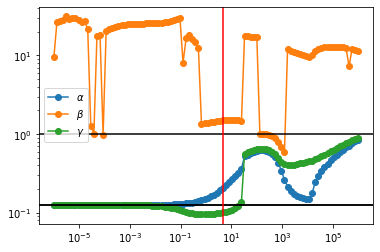

In [16]:
idx = 55
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\gamma$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

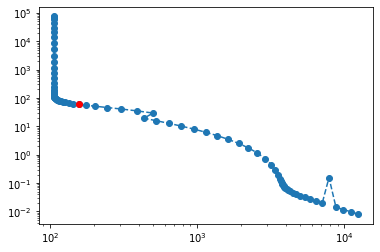

In [17]:
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

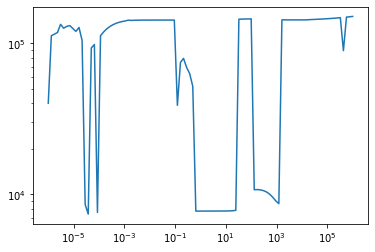

In [18]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])

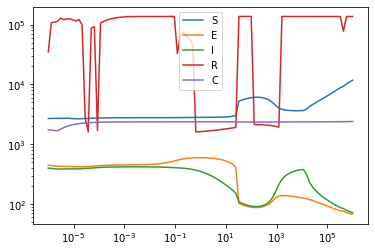

In [19]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(prange, [getM(i) for i,_ in enumerate(prange)])
plt.yscale('log')
plt.legend("SEIRC")

In [20]:
# applying the final size relation
from scipy.optimize import brentq
def rinf(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    r0 = pfin[1]/pfin[0]
    S0, E0, I0, R0, C0 = [float(x[0]) for x in getx(sol['x'])]
    N = sum((S0, E0, I0, R0))
    f = lambda y: y/S0 - np.exp(r0*(y-N)/N) 
    sinf = brentq(f, 0, S0) 
    return N-sinf

# def rinf(sol):
#     r0 = 8*getp(sol['x'])
#     S0, E0, I0, R0 = [float(x[0]) for x in getx(sol['x'])]
#     N = sum((S0, E0, I0, R0))
#     f = lambda y: y/S0 - np.exp(r0*(y-N)/N)
#     sinf = brentq(f, 0, S0)
#     return N-sinf

(0, 20000)

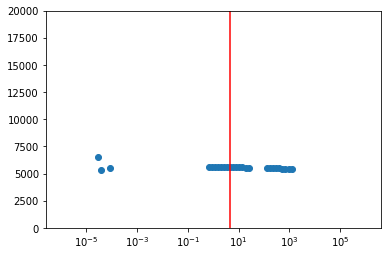

In [21]:
plt.semilogx(prange[:], [rinf(sol) for sol in sols][:], 'o')
plt.axvline(prange[idx], color='r')
plt.ylim([0,20000])

In [22]:
rinf(sols[idx])

5597.24676878095

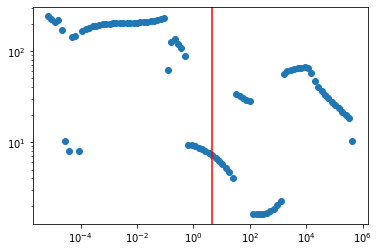

In [23]:
def r0(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    return pfin[1]/pfin[0]
# def r0(sol):
#     return 8*getp(sol['x'])
plt.plot(prange[7:-3], [r0(sol) for sol in sols][7:-3], 'o')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')

In [24]:
[getx(sols[idx]['x'])[i][50] for i in range(5)]

[DM(3431.62), DM(1192.29), DM(312.794), DM(357.867), DM(1180.73)]

In [25]:
getx(sols[idx]['x'])[0][0]

DM(5599.45)

In [26]:
getp(sols[idx]['x'])

(DM(0.207428), DM(1.49741), DM(0.100839))

In [27]:
r0(sols[idx])

7.218944467725581

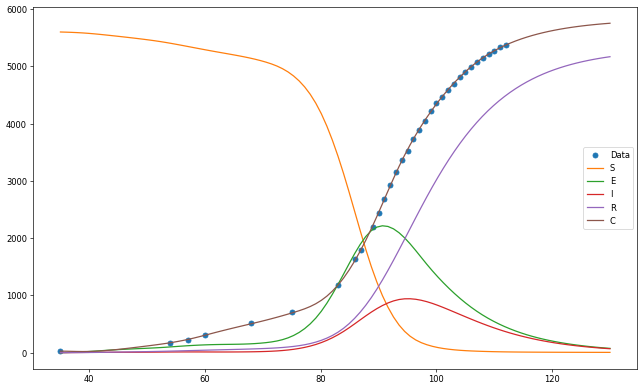

In [28]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[0], label='S')
ax.plot(model.observation_times, getx(sols[idx]['x'])[1], label='E')
ax.plot(model.observation_times, getx(sols[idx]['x'])[2], label='I')
ax.plot(model.observation_times, getx(sols[idx]['x'])[3], label='R')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='C')
plt.legend()

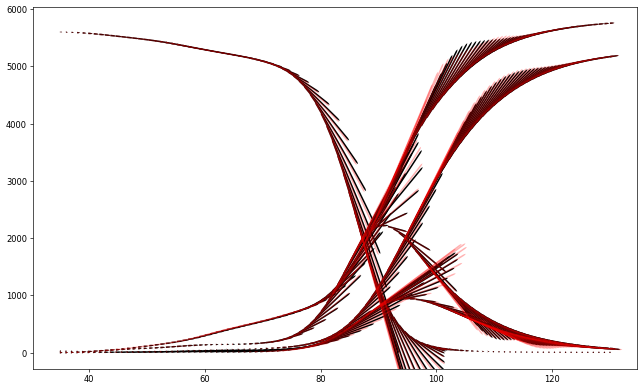

In [29]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, [1]*len(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)

Text(0.5, 1.0, 'Number of Reported Cases (Prediction)')

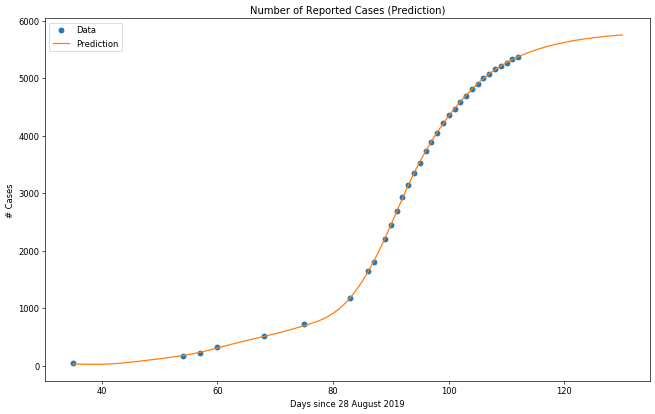

In [30]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)

ax.plot(times, cumdata, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')
plt.legend()
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

(0, 10000)

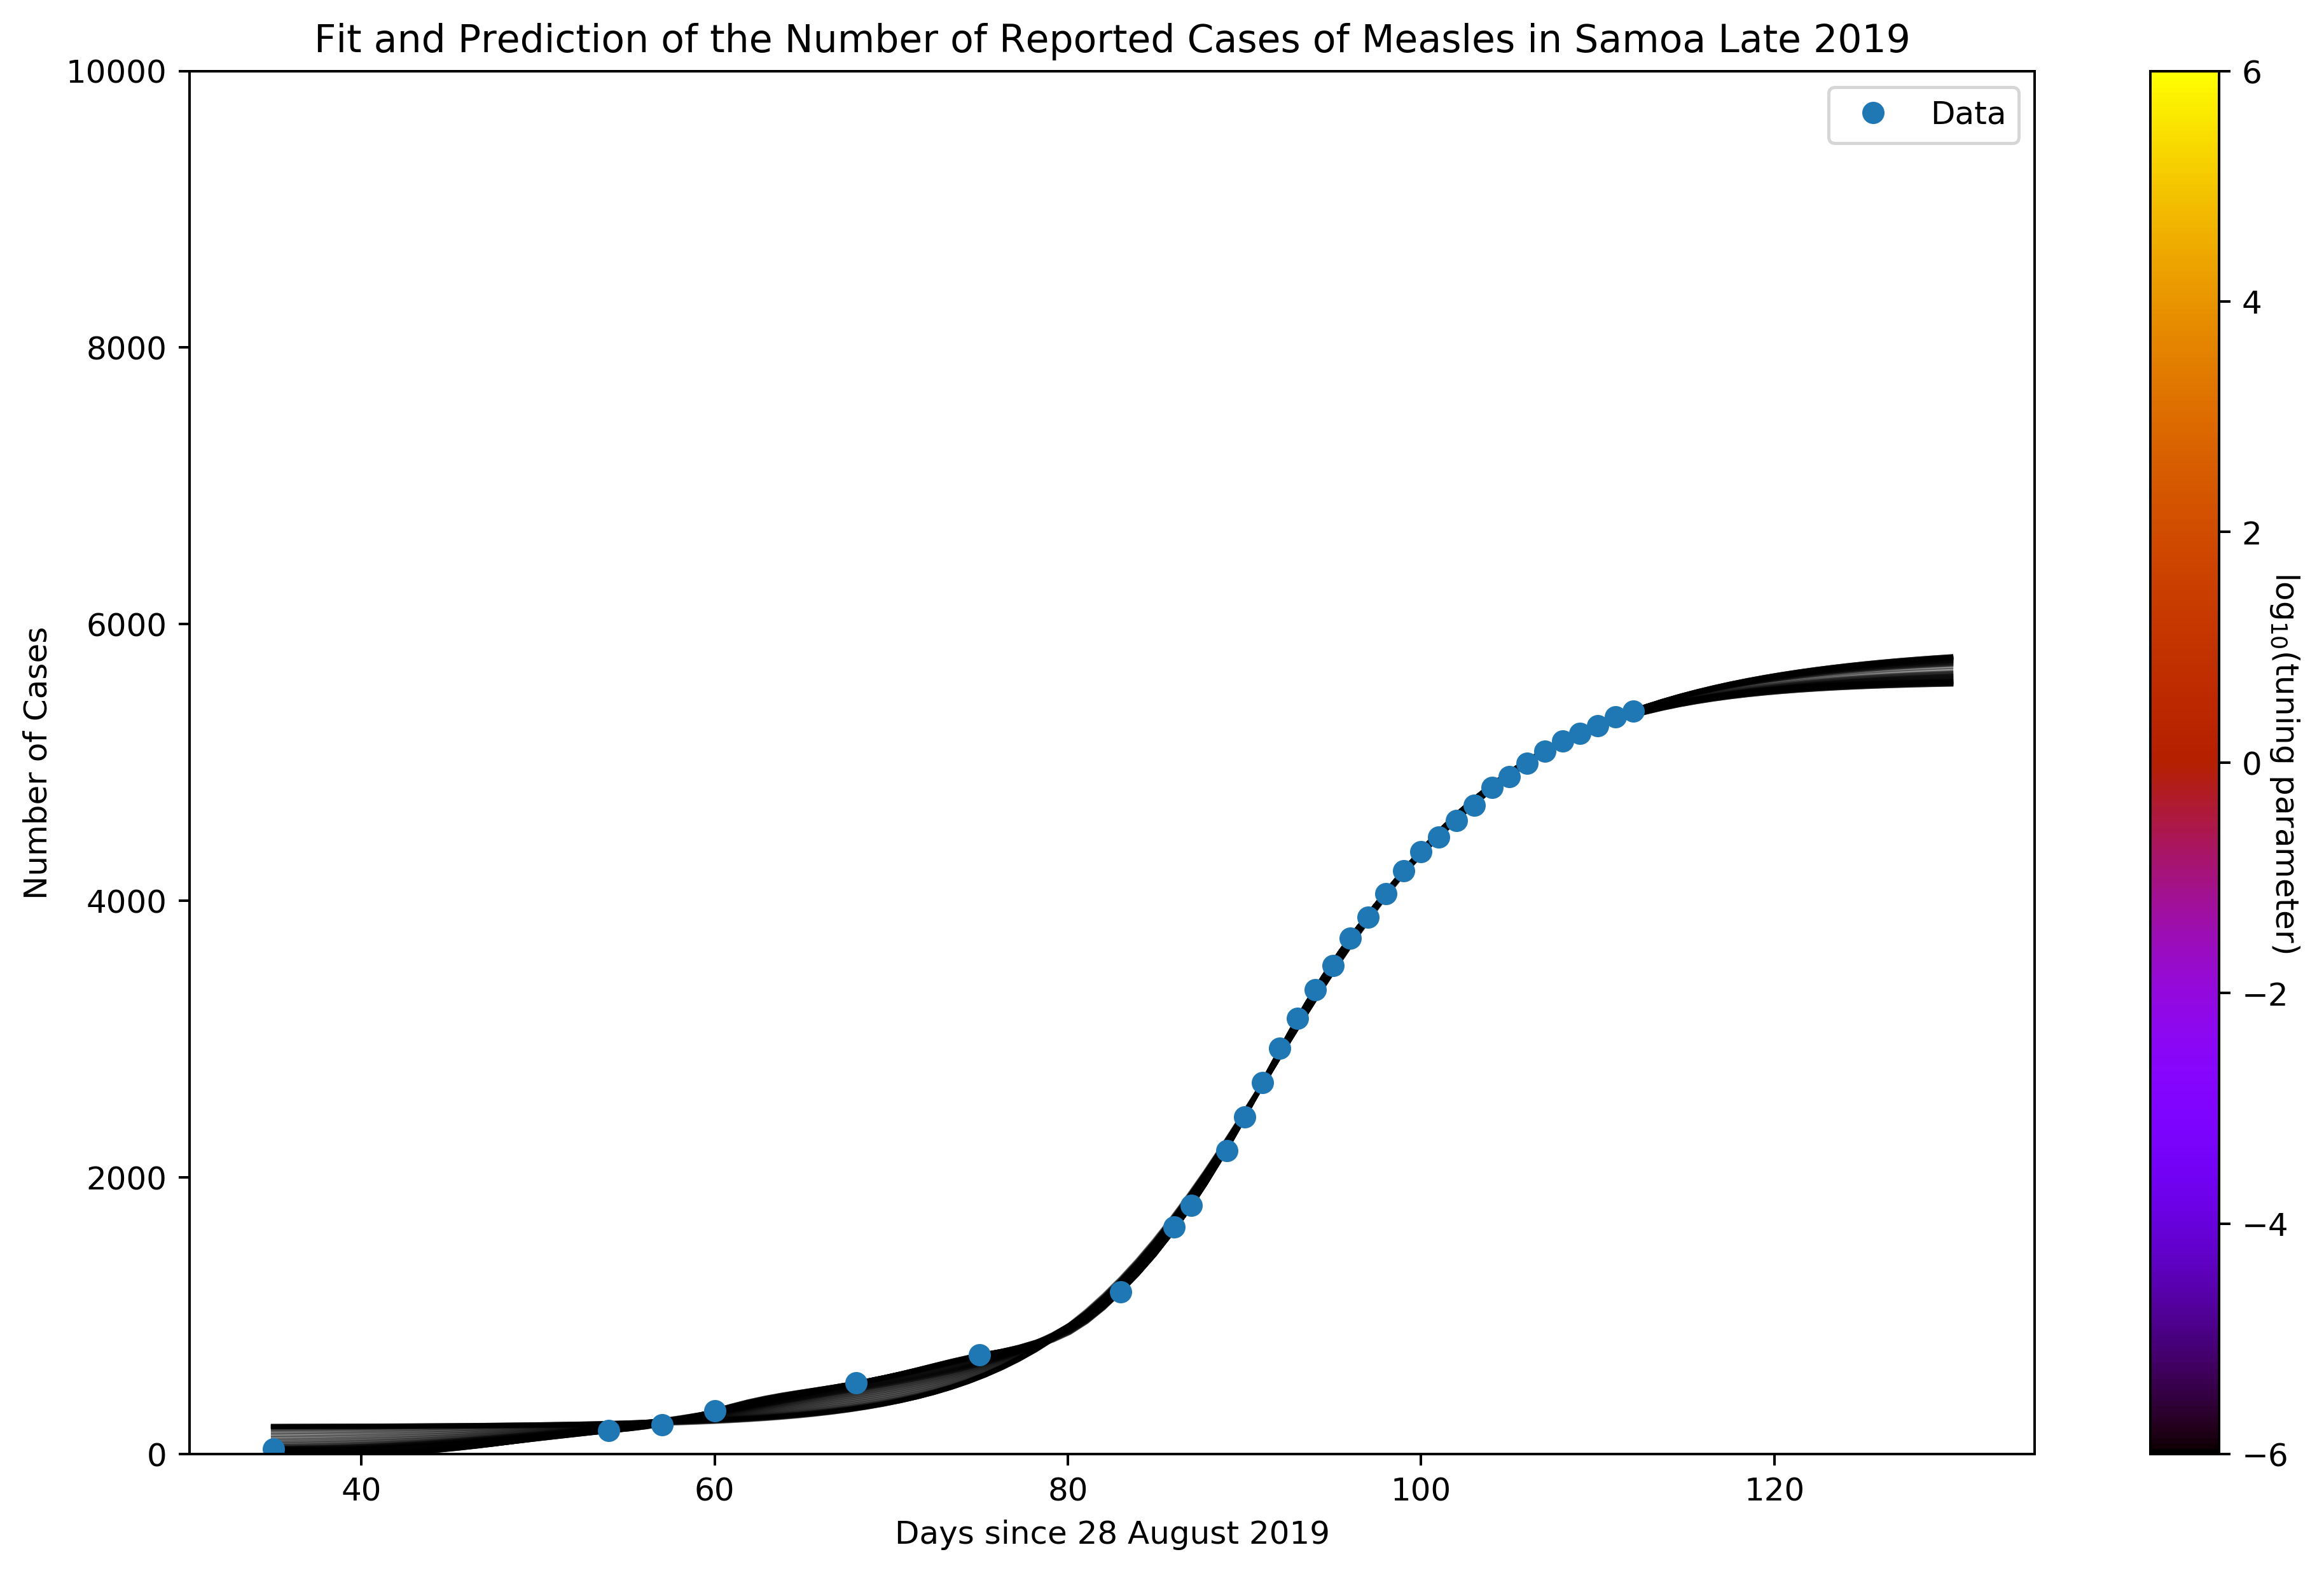

In [31]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

plt.figure(figsize=[13,8], dpi=360)

cNorm = colors.Normalize(vmin=np.log10(prange[0]), vmax=np.log10(prange[-1]))
cm = plt.get_cmap('gnuplot')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[40:-15:]):
    plt.plot(model.observation_times, getx(sols[i+40]['x'])[-1], color='k', alpha=0.4)
plt.plot(times, cumdata, 'o', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 28 August 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()
plt.ylim(0, 10000)

In [32]:
fsvals[idx]

array([155.82752589,  59.44897883])

In [33]:
getc = ca.Function('getx', [solver_setup['x']], model.cs)
np.sqrt(ca.sumsqr(cumdata - objective.collocation_matrices[0]@getc(sols[idx]['x'])[-1])/(len(times)-1))

DM(nan)

In [34]:
getp(sols[idx]['x'])

(DM(0.207428), DM(1.49741), DM(0.100839))

In [35]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
}
opts = {'ipopt': {'dual_inf_tol': 1e-1, 'print_frequency_iter': 10}}
profiler = ca.nlpsol('solver', 'ipopt', profiler_setup, opts)

In [36]:
rho = prange[idx]
pref = getp(sols[idx]['x'])
lbx = [-np.inf]*(config['basis_number']*config['model_form']['state']) + [0]*config['model_form']['parameters']
ubx = [np.inf]*(config['basis_number']*config['model_form']['state'] + config['model_form']['parameters'])

profiles = []
for pdx in range(config['model_form']['parameters']):
    pdx_mod = config['basis_number']*config['model_form']['state'] + pdx
    pvals = np.logspace(-1.5, 0.5, num=50)
    profiles.append([])
    for pval in pvals:
        lbx0 = np.array(lbx)
        ubx0 = np.array(ubx)
        lbx0[pdx_mod] = pval
        ubx0[pdx_mod] = pval
        profiles[pdx].append(profiler(x0=np.array(sols[idx]['x']).flatten(), p=[rho, alpha], lbx=lbx0, ubx=ubx0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1761

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  30  4.6241365e+02 0.00e+00 2.83e-07  -8.6 6.86e-01 -11.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:   9.7260606967311647e-02    4.6240329281513283e+02
Dual infeasibility......:   8.7638407869635976e-09    4.1665674973234696e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909486627119345e-10    4.3220834493292282e-06
Overall NLP error.......:   8.7638407869635976e-09    4.1665674973234696e-05


Number of objective function evaluations             = 63
Number of objective gradient evaluations             = 39
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 38
Total CPU secs in IPOPT (w/o

 760  1.6285566e+02 0.00e+00 1.51e+01  -8.6 1.02e-02  -3.8 1.00e+00 1.00e+00f  1
 770  1.6283919e+02 0.00e+00 2.09e+02  -8.6 6.86e-03  -3.6 1.00e+00 1.00e+00f  1
 780  1.6281891e+02 0.00e+00 2.21e+02  -8.6 1.23e-02  -3.9 1.00e+00 1.00e+00f  1
 790  1.6280696e+02 0.00e+00 8.67e+01  -8.6 2.50e-02  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.6279117e+02 0.00e+00 9.24e+01  -8.6 4.50e-02  -4.4 1.00e+00 1.00e+00f  1
 810  1.6277141e+02 0.00e+00 3.91e+02  -8.6 3.03e-02  -4.2 1.00e+00 1.00e+00f  1
 820  1.6275441e+02 0.00e+00 3.90e+02  -8.6 2.65e-04  -1.8 1.00e+00 1.00e+00f  1
 830  1.6274529e+02 0.00e+00 1.71e+00  -8.6 1.93e-04  -2.0 1.00e+00 1.00e+00f  1
 840  1.6273194e+02 0.00e+00 3.44e+02  -8.6 2.20e-02  -4.1 1.00e+00 1.00e+00f  1
 850  1.6271534e+02 0.00e+00 1.30e+03  -8.6 3.96e-02  -4.4 1.00e+00 1.00e+00f  1
 860  1.6269857e+02 0.00e+00 3.18e+02  -8.6 2.67e-02  -4.2 1.00e+00 1.00e+00f  1
 870  1.6268482e+02 0.00e+00

1780  1.6214159e+02 0.00e+00 1.31e+01  -8.6 5.35e-04  -2.5 1.00e+00 1.00e+00f  1
1790  1.6214074e+02 0.00e+00 3.17e+00  -8.6 9.64e-04  -2.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  1.6213996e+02 0.00e+00 3.99e+00  -8.6 6.50e-04  -2.6 1.00e+00 1.00e+00f  1
1810  1.6213933e+02 0.00e+00 2.64e+02  -8.6 1.18e-03  -2.8 1.00e+00 1.00e+00f  1
1820  1.6213878e+02 0.00e+00 2.65e+01  -8.6 2.64e-04  -2.2 1.00e+00 1.00e+00f  1
1830  1.6213917e+02 0.00e+00 7.60e+00  -8.6 3.40e-07   3.2 1.00e+00 1.00e+00f  1
1840  1.6213904e+02 0.00e+00 2.74e-01  -8.6 6.62e-05  -1.6 1.00e+00 1.00e+00f  1
1850  1.6213766e+02 0.00e+00 2.79e-01  -8.6 1.20e-04  -1.9 1.00e+00 1.00e+00f  1
1860  1.6213662e+02 0.00e+00 1.16e+01  -8.6 2.17e-04  -2.1 1.00e+00 1.00e+00f  1
1870  1.6213579e+02 0.00e+00 1.28e+00  -8.6 4.89e-05  -1.5 1.00e+00 1.00e+00f  1
1880  1.6213507e+02 0.00e+00 1.41e+03  -8.6 5.77e-03  -3.5 1.00e+00 5.00e-01f  2
1890  1.6213421e+02 0.00e+00

2700  1.6212190e+02 0.00e+00 1.41e+01  -8.6 2.43e-04  -2.2 1.00e+00 1.00e+00f  1
2710  1.6212171e+02 0.00e+00 4.68e+01  -8.6 9.99e-04  -2.4 1.00e+00 1.00e+00f  1
2720  1.6212156e+02 0.00e+00 1.77e+00  -8.6 9.88e-05  -1.8 1.00e+00 1.00e+00f  1
2730  1.6212140e+02 0.00e+00 2.96e+01  -8.6 1.78e-04  -2.0 1.00e+00 1.00e+00f  1
2740  1.6212125e+02 0.00e+00 2.65e+01  -8.6 1.21e-04  -1.9 1.00e+00 1.00e+00f  1
2750  1.6212111e+02 0.00e+00 3.92e+00  -8.6 8.17e-05  -1.7 1.00e+00 1.00e+00f  1
2760  1.6212100e+02 0.00e+00 4.98e+01  -8.6 2.43e-04  -1.9 1.00e+00 1.00e+00f  1
2770  1.6212092e+02 0.00e+00 1.97e+01  -8.6 9.97e-05  -1.8 1.00e+00 1.00e+00f  1
2780  1.6212083e+02 0.00e+00 9.01e+01  -8.6 2.78e-04  -2.0 1.00e+00 1.00e+00f  1
2790  1.6212078e+02 0.00e+00 2.55e+01  -8.6 4.06e-05  -1.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  1.6212074e+02 0.00e+00 8.67e+00  -8.6 7.32e-05  -1.6 1.00e+00 1.00e+00f  1
2810  1.6212070e+02 0.00e+00

  80  3.6274875e+02 0.00e+00 2.30e+00  -8.6 4.17e+01  -6.8 1.00e+00 1.00e+00f  1
  90  2.4621685e+02 0.00e+00 2.02e+01  -8.6 2.73e+01  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9480840e+02 0.00e+00 1.88e+01  -8.6 4.92e+00  -5.9 1.00e+00 5.00e-01f  2
 110  1.9156322e+02 0.00e+00 1.37e-03  -8.6 1.91e-02  -3.5 1.00e+00 1.00e+00f  1
 120  1.8805232e+02 0.00e+00 1.80e-02  -8.6 1.49e-01  -3.7 1.00e+00 1.00e+00f  1
 130  1.8526557e+02 0.00e+00 3.18e-04  -8.6 1.02e-03  -1.3 1.00e+00 1.00e+00f  1
 140  1.8349909e+02 0.00e+00 7.30e+01  -8.6 4.41e+00  -6.0 1.00e+00 1.00e+00f  1
 150  1.8201807e+02 0.00e+00 1.94e-02  -8.6 1.14e-03  -0.9 1.00e+00 1.00e+00f  1
 160  1.8145781e+02 0.00e+00 6.49e+01  -8.6 1.82e+00  -5.7 1.00e+00 1.00e+00f  1
 170  1.8013188e+02 0.00e+00 1.37e+01  -8.6 3.98e-01  -5.0 1.00e+00 1.00e+00f  1
 180  1.7928035e+02 0.00e+00 2.91e+01  -8.6 7.86e-02  -4.4 1.00e+00 1.00e+00f  1
 190  1.7851778e+02 0.00e+00

CasADi - 2019-12-18 18:59:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:25 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 460  1.7456358e+02 0.00e+00 8.86e+11  -8.6 2.03e-09  12.5 1.00e+00 1.00e+00w  1
 470  1.7362596e+02 0.00e+00 3.90e+11  -8.6 3.89e-11  11.4 1.00e+00 5.68e-14f 45
 480  1.7362596e+02 0.00e+00 3.90e+11  -8.6 8.16e-12  14.9 1.00e+00 4.55e-13f 42
 490  4.0475904e+02 0.00e+00 2.20e+14  -8.6 2.07e-10  15.6 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.7392562e+02 0.00e+00 3.00e+11  -8.6 4.58e-12  14.4 1.00e+00 1.82e-12f 40
 510  1.7345921e+02 0.00e+00 1.54e+12  -8.6 5.81e-09   9.6 1.00e+00 1.11e-16f 54
 520  1.7413681e+02 0.00e+00 1.97e+10  -8.6 4.00e-12  17.5 1.00e+00 1.00e+00f  1
 530  1.7374309e+02 0.00e+00 2.24e+10  -8.6 6.08e-11  12.7 1.00e+00 5.00e-01f  2
 540  1.7384226e+02 0.00e+00 1.12e+09  -8.6 7.35e-10   9.8 1.00e+00 1.00e+00f  1
 550  1.7375909e+02 0.00e+00 3.61e+09  -8.6 2.41e-09  11.3 1.00e+00 1.14e-13f 44
 560  1.7455192e+02 0.00e+00 8.12e+11  -8.6 2.10e-11  12.9 1.00e+00 6.25e-02f  5
 570  2.6125949e+02 0.00e+00

 480  1.6812087e+02 0.00e+00 2.57e+02  -8.6 7.26e-03  -3.4 1.00e+00 1.00e+00f  1
 490  1.6809779e+02 0.00e+00 1.22e+03  -8.6 6.84e-03  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.6808321e+02 0.00e+00 1.83e+03  -8.6 1.37e-02  -3.7 1.00e+00 1.00e+00f  1
 510  1.6807013e+02 0.00e+00 7.21e+03  -8.6 1.13e-02  -3.6 1.00e+00 1.00e+00f  1
 520  1.6805835e+02 0.00e+00 5.92e+03  -8.6 9.00e-03  -3.5 1.00e+00 1.00e+00f  1
 530  1.6804611e+02 0.00e+00 7.14e+03  -8.6 2.38e-02  -3.9 1.00e+00 1.00e+00f  1
 540  1.6803966e+02 0.00e+00 6.27e+02  -8.6 6.18e-03  -3.4 1.00e+00 1.00e+00f  1
 550  1.6803450e+02 0.00e+00 6.47e+02  -8.6 2.12e-03  -2.8 1.00e+00 1.00e+00f  1
 560  1.6803110e+02 0.00e+00 1.85e+03  -8.6 1.42e-03  -2.7 1.00e+00 1.00e+00f  1
 570  1.6802770e+02 0.00e+00 5.10e+03  -8.6 3.04e-03  -3.1 1.00e+00 1.00e+00f  1
 580  1.6802342e+02 0.00e+00 8.74e+03  -8.6 7.71e-04  -2.5 1.00e+00 1.00e+00f  1
 590  1.6802062e+02 0.00e+00

CasADi - 2019-12-18 18:59:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 840  1.6776846e+02 0.00e+00 1.23e+12  -8.6 1.17e-11  14.2 1.00e+00 5.68e-14f 45
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 849

                                   (scaled)                 (unscaled)
Objective...............:   2.2759549837729605e+00    9.0132276718000448e+03
Dual infeasibility......:   8.6636650934980560e+15    3.4309811273365008e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    9.9238690870450361e-06
Overall NLP error.......:   8.6636650934980560e+15    3.4309811273365008e+19


Number of objective function evaluations             = 2835
Number of objective gradient evaluations             = 850
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number

 710  1.6923754e+02 0.00e+00 8.12e+09  -8.6 1.33e-08  10.5 1.00e+00 1.25e-01f  4
 720  1.6904304e+02 0.00e+00 3.79e+10  -8.6 1.34e-09  12.1 1.00e+00 2.84e-14f 46
 730  1.6896268e+02 0.00e+00 1.71e+11  -8.6 6.38e-10  12.7 1.00e+00 1.56e-02f  7
 740  2.0994770e+02 0.00e+00 7.88e+12  -8.6 1.86e-08  12.5 1.00e+00 1.00e+00w  1
 750  1.6863742e+02 0.00e+00 6.81e+10  -8.6 2.82e-10  11.3 1.00e+00 1.22e-04f 14
 760  1.6888500e+02 0.00e+00 5.41e+11  -8.6 2.03e-10  12.9 1.00e+00 1.00e+00w  1
 770  1.6840719e+02 0.00e+00 2.23e+11  -8.6 9.78e-09  12.6 1.00e+00 4.44e-16f 52
 780  1.6834434e+02 0.00e+00 4.14e+11  -8.6 4.00e-10  14.1 1.00e+00 7.81e-03f  8
 790  1.6990425e+02 0.00e+00 1.60e+09  -8.6 5.43e-07  10.3 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.6912668e+02 0.00e+00 1.82e+09  -8.6 1.91e-08   8.2 1.00e+00 5.00e-01f  2
 810  1.6857491e+02 0.00e+00 8.86e+10  -8.6 1.53e-09  12.5 1.00e+00 3.91e-03f  9
 820  1.6855767e+02 0.00e+00

CasADi - 2019-12-18 18:59:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 850  1.6818721e+02 0.00e+00 3.34e+11  -8.6 2.63e-08  10.6 1.00e+00 1.78e-15f 50
 860  1.6883244e+02 0.00e+00 2.48e+11  -8.6 1.78e-09  13.0 1.00e+00 1.95e-03f 10
 870  1.7051633e+02 0.00e+00 1.34e+10  -8.6 7.53e-11  11.8 1.00e+00 1.00e+00S 21
 880  1.6908916e+02 0.00e+00 1.94e+10  -8.6 1.70e-09  11.6 1.00e+00 2.84e-14f 46
 890  1.6908916e+02 0.00e+00 1.94e+10  -8.6 4.03e-09  11.3 1.00e+00 1.42e-14f 47
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  1.6907604e+02 0.00e+00 1.52e+08  -8.6 8.26e-10  10.2 1.00e+00 1.00e+00f  1
 910  1.6891443e+02 0.00e+00 1.17e+10  -8.6 6.75e-10  12.6 1.00e+00 2.50e-01f  3
 920  1.6890564e+02 0.00e+00 3.34e+10  -8.6 1.54e-11  14.2 1.00e+00 1.95e-03f 10
 930  1.6890564e+02 0.00e+00 3.34e+10  -8.6 4.55e-09  12.1 1.00e+00 7.11e-15f 48
 940  1.6862404e+02 0.00e+00 5.72e+10  -8.6 9.55e-09   9.2 1.00e+00 1.00e+00f  1
 950  1.6849090e+02 0.00e+00 2.14e+11  -8.6 3.32e-10  13.4 1.00e+00 1.42e-14f 47
 960  1.6909142e+02 0.00e+00

CasADi - 2019-12-18 18:59:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1080  1.6822257e+02 0.00e+00 3.85e+11  -8.6 2.23e-07  10.7 1.00e+00 1.91e-06f 20
1090  1.6929591e+02 0.00e+00 7.05e+08  -8.6 9.48e-10  11.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.6905865e+02 0.00e+00 1.41e+10  -8.6 1.15e-09  12.0 1.00e+00 5.68e-14f 45
1110  1.6887503e+02 0.00e+00 9.36e+10  -8.6 1.34e-09  12.7 1.00e+00 7.11e-15f 48
1120  2.0895249e+02 0.00e+00 6.19e+12  -8.6 1.39e-09  14.2 1.00e+00 1.00e+00w  1
1130  1.6825449e+02 0.00e+00 8.50e+10  -8.6 1.24e-10  14.0 1.00e+00 1.00e+00f  1
1140  1.6825430e+02 0.00e+00 1.86e+10  -8.6 2.30e-10  13.7 1.00e+00 2.27e-13f 43
1150  1.6868496e+02 0.00e+00 3.83e+11  -8.6 2.21e-10  13.5 1.00e+00 1.42e-14f 47
1160  1.8035804e+02 0.00e+00 1.67e+13  -8.6 8.45e-12  17.0 1.00e+00 5.00e-01f  2
1170  1.6877351e+02 0.00e+00 7.29e+11  -8.6 9.08e-11  12.2 1.00e+00 2.50e-01f  3
1180  1.8046441e+02 0.00e+00 2.94e+12  -8.6 2.24e-09  12.9 1.00e+00 1.00e+00w  1
1190  1.6824747e+02 0.00e+00

CasADi - 2019-12-18 18:59:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1210  1.6935222e+02 0.00e+00 1.10e+11  -8.6 3.54e-10  13.0 1.00e+00 1.00e+00w  1
1220  1.6908860e+02 0.00e+00 1.41e+11  -8.6 7.40e-10  12.8 1.00e+00 7.11e-15f 48
1230  1.6899644e+02 0.00e+00 2.41e+11  -8.6 2.18e-10  13.4 1.00e+00 2.84e-14f 46
1240  1.6927665e+02 0.00e+00 2.88e+11  -8.6 1.03e-12  15.9 1.00e+00 2.50e-01f  3
1250  1.6881906e+02 0.00e+00 1.43e+11  -8.6 2.05e-10  13.8 1.00e+00 9.77e-04f 11
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1258

                                   (scaled)                 (unscaled)
Objective...............:   3.7296210275994831e+01    1.3838680690165627e+05
Dual infeasibility......:   1.3166907452417250e+15    4.8855534265432596e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    9.2981026614068699e-06
Overall NLP error.......:   1.3166907452417250e+15    4.8855534265432596e+18


Number of objective function

 770  1.4819306e+02 0.00e+00 4.66e-03  -8.6 2.97e-03  -3.7 1.00e+00 1.00e+00f  1
 780  1.4818812e+02 0.00e+00 3.23e-01  -8.6 4.23e-02  -4.8 1.00e+00 1.00e+00f  1
 790  1.4818474e+02 0.00e+00 1.17e-03  -8.6 9.51e-03  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.4818068e+02 0.00e+00 1.93e-03  -8.6 2.14e-03  -3.5 1.00e+00 1.00e+00f  1
 810  1.4817604e+02 0.00e+00 6.25e-01  -8.6 3.08e-02  -4.7 1.00e+00 1.00e+00f  1
 820  1.4817227e+02 0.00e+00 2.23e+00  -8.6 3.21e-02  -4.1 1.00e+00 2.50e-01f  3
 830  1.4816764e+02 0.00e+00 1.92e-03  -8.6 1.55e-03  -3.4 1.00e+00 1.00e+00f  1
 840  1.4816386e+02 0.00e+00 1.06e+00  -8.6 2.24e-02  -4.6 1.00e+00 1.00e+00f  1
 850  1.4816123e+02 0.00e+00 7.37e-02  -8.6 5.06e-03  -3.9 1.00e+00 1.00e+00f  1
 860  1.4815791e+02 0.00e+00 2.22e-02  -8.6 1.12e-03  -3.3 1.00e+00 1.00e+00f  1
 870  1.4815489e+02 0.00e+00 1.63e-02  -8.6 2.05e-03  -3.5 1.00e+00 1.00e+00f  1
 880  1.4815156e+02 0.00e+00

1880  1.4804776e+02 0.00e+00 1.40e-01  -9.0 8.36e-03  -4.2 1.00e+00 1.00e+00f  1
1890  1.4804571e+02 0.00e+00 2.86e-01  -9.0 1.50e-02  -4.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900  1.4804348e+02 0.00e+00 1.26e+00  -9.0 3.66e-03  -3.8 1.00e+00 1.00e+00f  1
1910  1.4804160e+02 0.00e+00 4.99e-03  -9.0 7.53e-04  -3.1 1.00e+00 1.00e+00f  1
1920  1.4803960e+02 0.00e+00 3.85e-02  -9.0 1.38e-03  -3.4 1.00e+00 1.00e+00f  1
1930  1.4803826e+02 0.00e+00 2.60e-02  -9.0 2.45e-03  -3.6 1.00e+00 1.00e+00f  1
1940  1.4803699e+02 0.00e+00 8.28e-02  -9.0 4.41e-03  -3.9 1.00e+00 1.00e+00f  1
1950  1.4803582e+02 0.00e+00 1.25e-02  -9.0 9.98e-04  -3.3 1.00e+00 1.00e+00f  1
1960  1.4803451e+02 0.00e+00 9.87e-02  -9.0 1.77e-03  -3.5 1.00e+00 1.00e+00f  1
1970  1.4803355e+02 0.00e+00 5.14e+00  -9.0 2.63e-02  -4.7 1.00e+00 2.50e-01f  3
1980  1.4803284e+02 0.00e+00 1.31e-01  -9.0 5.78e-03  -4.0 1.00e+00 1.00e+00f  1
1990  1.4803244e+02 0.00e+00

 440  1.7324345e+02 0.00e+00 3.12e+05  -8.6 3.34e-11   9.9 1.00e+00 1.00e+00w  1
 450  1.7324285e+02 0.00e+00 3.30e+06  -8.6 5.86e-08   5.1 1.00e+00 1.16e-10f 34
 460  1.7324234e+02 0.00e+00 1.03e+07  -8.6 1.46e-06   3.9 1.00e+00 1.82e-12f 40
 470  1.7324744e+02 0.00e+00 6.58e+07  -8.6 1.78e-06   4.6 1.00e+00 1.00e+00w  1
 480  1.7324010e+02 0.00e+00 1.08e+07  -8.6 1.37e-05   4.3 1.00e+00 2.98e-08f 26
 490  1.7323746e+02 0.00e+00 1.55e+08  -8.6 4.20e-07   5.9 1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.7323193e+02 0.00e+00 4.81e+07  -8.6 3.41e-07   6.5 1.00e+00 5.00e-01f  2
 510  1.7318802e+02 0.00e+00 8.79e+09  -8.6 6.39e-07   8.1 1.00e+00 7.11e-15f 48
 520  1.7310772e+02 0.00e+00 8.96e+09  -8.6 2.39e-08   9.6 1.00e+00 1.14e-13f 44
 530  1.7310144e+02 0.00e+00 9.53e+09  -8.6 1.55e-12  15.7 1.00e+00 2.50e-01f  3
 540  1.7333318e+02 0.00e+00 1.04e+10  -8.6 9.13e-10  10.9 1.00e+00 1.00e+00w  1
 550  1.7309884e+02 0.00e+00

CasADi - 2019-12-18 18:59:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 710  2.7901863e+03 0.00e+00 1.88e+14  -8.6 1.68e-10  18.3 1.00e+00 1.00e+00w  1
 720  1.7441895e+02 0.00e+00 4.93e+11  -8.6 2.99e-12  15.7 1.00e+00 1.00e+00f  1
 730  1.7417580e+02 0.00e+00 4.65e+12  -8.6 1.41e-09  10.9 1.00e+00 7.11e-15f 48
 740  1.7340820e+02 0.00e+00 1.60e+11  -8.6 1.60e-11  14.3 1.00e+00 1.00e+00f  1
 750  1.7309968e+02 0.00e+00 2.75e+11  -8.6 4.21e-10  12.2 1.00e+00 2.44e-04f 13
 760  1.7424089e+02 0.00e+00 1.16e+12  -8.6 3.90e-07   7.5 1.00e+00 1.00e+00w  1
 770  1.7306831e+02 0.00e+00 3.34e+10  -8.6 6.28e-08   7.2 1.00e+00 3.81e-06f 19
 780  1.7306831e+02 0.00e+00 3.34e+10  -8.6 1.24e-07   5.1 1.00e+00 1.82e-12f 40
 790  1.8276013e+02 0.00e+00 1.14e+13  -8.6 2.22e-07   5.8 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 791

                                   (scaled)                 (unscaled)
Objective..

 700  1.6815511e+02 0.00e+00 1.31e+04  -8.6 1.60e-03  -2.6 1.00e+00 1.00e+00f  1
 710  1.6815081e+02 0.00e+00 1.02e+04  -8.6 1.08e-03  -2.4 1.00e+00 1.00e+00f  1
 720  1.6814758e+02 0.00e+00 1.75e+03  -8.6 2.57e-03  -2.7 1.00e+00 1.00e+00f  1
 730  1.6814507e+02 0.00e+00 1.87e+04  -8.6 1.67e-03  -2.6 1.00e+00 1.00e+00f  1
 740  1.6814310e+02 0.00e+00 5.04e+03  -8.6 3.76e-04  -2.0 1.00e+00 1.00e+00f  1
 750  1.6814092e+02 0.00e+00 1.00e+03  -8.6 8.75e-04  -2.3 1.00e+00 1.00e+00F  1
 760  1.6813939e+02 0.00e+00 1.13e+04  -8.6 5.79e-04  -2.1 1.00e+00 1.00e+00f  1
 770  1.6813810e+02 0.00e+00 3.36e+04  -8.6 4.69e-04  -2.0 1.00e+00 1.00e+00f  1
 780  1.6813656e+02 0.00e+00 5.20e+04  -8.6 2.97e-04  -1.8 1.00e+00 5.00e-01f  2
 790  1.6813562e+02 0.00e+00 2.59e+03  -8.6 7.37e-04  -2.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.6813534e+02 0.00e+00 1.20e+05  -8.6 8.50e-04  -2.0 1.00e+00 1.16e-10f 34
 810  1.6813511e+02 0.00e+00

CasADi - 2019-12-18 18:59:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1030  1.6861570e+02 0.00e+00 6.17e+07  -8.6 7.96e-09  10.1 1.00e+00 1.22e-04f 14
1040  1.6861159e+02 0.00e+00 5.92e+07  -8.6 3.06e-09   8.9 1.00e+00 3.05e-05f 16
1050  1.6860451e+02 0.00e+00 8.51e+07  -8.6 1.25e-08   8.7 1.00e+00 4.77e-07f 22
1060  1.6860280e+02 0.00e+00 1.01e+09  -8.6 1.02e-09   9.3 1.00e+00 1.00e+00w  1
1070  1.6859468e+02 0.00e+00 1.60e+09  -8.6 4.63e-08   9.1 1.00e+00 1.42e-14f 47
1080  1.6859194e+02 0.00e+00 1.01e+08  -8.6 1.46e-07   7.9 1.00e+00 5.00e-01f  2
1090  1.6862930e+02 0.00e+00 1.14e+08  -8.6 4.48e-06   7.7 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.6856711e+02 0.00e+00 1.61e+10  -8.6 1.49e-07   8.3 1.00e+00 1.00e+00f  1
1110  1.6853915e+02 0.00e+00 4.07e+08  -8.6 9.66e-10  11.7 1.00e+00 1.22e-04f 14
1120  1.6853712e+02 0.00e+00 4.93e+07  -8.6 2.24e-09  11.4 1.00e+00 3.81e-06f 19
1130  1.6853712e+02 0.00e+00 1.45e+07  -8.6 7.02e-09  11.2 1.00e+00 1.46e-11f 37
1140  1.6853712e+02 0.00e+00

CasADi - 2019-12-18 18:59:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1170  1.6846703e+02 0.00e+00 3.26e+10  -8.6 4.07e-13  17.4 1.00e+00 6.25e-02f  5
1180  1.6854247e+02 0.00e+00 8.61e+10  -8.6 1.19e-10  12.6 1.00e+00 1.00e+00w  1
1190  1.6846659e+02 0.00e+00 3.11e+10  -8.6 9.07e-10  12.3 1.00e+00 2.84e-14f 46
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.6856024e+02 0.00e+00 7.24e+08  -8.6 1.83e-09  11.2 1.00e+00 2.44e-04f 13
1210  1.6863279e+02 0.00e+00 8.56e+09  -8.6 4.11e-09  10.0 1.00e+00 5.00e-01f  2
1220  1.6848627e+02 0.00e+00 1.63e+10  -8.6 7.74e-10  12.5 1.00e+00 1.14e-13f 44
1230  1.6832679e+02 0.00e+00 2.30e+10  -8.6 2.82e-10  13.1 1.00e+00 1.22e-04f 14
1240  1.7010494e+02 0.00e+00 3.56e+12  -8.6 1.73e-10  15.6 1.00e+00 6.25e-02f  5
1250  1.7568038e+02 0.00e+00 2.00e+11  -8.6 7.54e-10  14.4 1.00e+00 1.00e+00w  1
1260  1.6846201e+02 0.00e+00 5.45e+10  -8.6 1.48e-10  13.3 1.00e+00 1.14e-13f 44
1270  1.6843428e+02 0.00e+00 5.20e+10  -8.6 1.01e-09  13.9 1.00e+00 2.27e-13f 42
1280  1.6881162e+02 0.00e+00

CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")


1310  1.6865961e+02 0.00e+00 1.13e+10  -8.6 3.48e-10  12.9 1.00e+00 1.00e+00w  1
1320  1.6816612e+02 0.00e+00 5.53e+11  -8.6 1.22e-09  13.5 1.00e+00 1.78e-15f 50
1330  1.6831831e+02 0.00e+00 6.93e+11  -8.6 2.11e-11  14.2 1.00e+00 1.14e-13f 44
1340  1.8273211e+02 0.00e+00 1.63e+13  -8.6 1.72e-08   9.4 1.00e+00 1.00e+00w  1
1350  1.6815152e+02 0.00e+00 4.95e+09  -8.6 4.50e-10  12.8 1.00e+00 6.25e-02f  5
1360  1.6814724e+02 0.00e+00 2.62e+11  -8.6 7.56e-10  12.5 1.00e+00 1.95e-03f 10
1370  1.6814047e+02 0.00e+00 4.12e+10  -8.6 9.78e-09   7.7 1.00e+00 1.53e-05f 17
1380  1.8008331e+02 0.00e+00 3.38e+13  -8.6 6.12e-09   6.6 1.00e+00 1.00e+00w  1
1390  1.6793062e+02 0.00e+00 6.46e+11  -8.6 1.52e-07   5.4 1.00e+00 2.44e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1400  1.7164818e+02 0.00e+00 4.98e+12  -8.6 3.55e-09  12.6 1.00e+00 2.22e-16f 53
1410  1.6845884e+02 0.00e+00 6.09e+11  -8.6 1.43e-11  15.9 1.00e+00 1.00e+00f  1
1420  1.6807970e+02 0.00e+00 5.89e+11  -8.6 5.69e-10  13.9 1.00e+00 3.55e-15f 49
1430  1.6807970e+02 0.00e+00 5.89e+11  -8.6 2.40e-09  13.6 1.00e+00 8.88e-16f 51
1440  1.6803983e+02 0.00e+00 2.78e+11  -8.6 1.87e-10  12.5 1.00e+00 1.42e-14f 47
1450  1.6803983e+02 0.00e+00 2.78e+11  -8.6 1.62e-10  13.1 1.00e+00 2.84e-14f 45
1460  1.8188152e+02 0.00e+00 2.34e+11  -8.6 5.12e-10   8.3 1.00e+00 1.00e+00w  1
1470  1.6803983e+02 0.00e+00 2.78e+11  -8.6 3.58e-08   6.3 1.00e+00 1.42e-14f 47
1480  1.6803239e+02 0.00e+00 1.88e+12  -8.6 3.64e-11  14.7 1.00e+00 7.81e-03f  8
1490  1.8102745e+02 0.00e+00 5.03e+12  -8.6 3.13e-09  10.0 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.7180882e+02 0.00e+00 4.06e+12  -8.6 1.22e-09   7.0 1.00e+00 7.11e-15f 48
1510  1.7180389e+02 0.00e+00

CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1520  1.7275710e+02 0.00e+00 1.51e+13  -8.6 5.73e-08   6.5 1.00e+00 1.00e+00w  1
1530  1.6971517e+02 0.00e+00 5.52e+12  -8.6 4.29e-10  12.0 1.00e+00 3.55e-15f 49
1540  1.6971517e+02 0.00e+00 5.52e+12  -8.6 2.65e-11  15.6 1.00e+00 3.55e-15f 48
1550  1.7412261e+02 0.00e+00 1.22e+13  -8.6 4.37e-10  10.8 1.00e+00 1.00e+00w  1
1560  1.6843036e+02 0.00e+00 5.95e+12  -8.6 2.97e-10  14.2 1.00e+00 4.44e-16f 52
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1568

                                   (scaled)                 (unscaled)
Objective...............:   7.7009853769387799e+00    2.1591605212902185e+04
Dual infeasibility......:   3.8725669682983210e+15    1.0857693275254684e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    7.0259165176763444e-06
Overall NLP error.......:   3.8725669682983210e+15    1.0857693275254684e+19


Number of objective function

 100  1.8896612e+02 0.00e+00 4.12e-03  -5.7 1.24e-02  -0.1 1.00e+00 6.25e-02f  5
 110  1.8896200e+02 0.00e+00 2.34e-03  -5.7 8.94e-06   1.5 1.00e+00 1.00e+00f  1
 120  1.8894464e+02 0.00e+00 8.31e-04  -5.7 2.51e-02  -3.3 1.00e+00 1.00e+00f  1
 130  1.8705886e+02 0.00e+00 2.27e-04  -5.7 7.50e-03  -2.7 1.00e+00 1.00e+00f  1
 140  1.8290655e+02 0.00e+00 9.54e+00  -5.7 2.17e+00  -4.7 1.00e+00 1.00e+00f  1
 150  1.8042781e+02 0.00e+00 9.48e+01  -5.7 2.19e-01  -4.0 1.00e+00 1.00e+00f  1
 160  1.7716612e+02 0.00e+00 4.07e+01  -5.7 1.12e+00  -5.2 1.00e+00 1.00e+00f  1
 170  1.7413977e+02 0.00e+00 1.88e+02  -5.7 1.30e-01  -3.6 1.00e+00 1.00e+00f  1
 180  1.7326272e+02 0.00e+00 9.94e-03  -5.7 9.63e-03  -3.0 1.00e+00 1.00e+00f  1
 190  1.7319973e+02 0.00e+00 1.09e-01  -5.7 1.11e-02  -3.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.7282944e+02 0.00e+00 6.79e+00  -8.6 6.83e-04  -0.3 1.00e+00 1.00e+00f  1
 210  1.7282428e+02 0.00e+00

CasADi - 2019-12-18 18:59:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 110  1.7391315e+02 0.00e+00 1.01e+02  -5.7 2.81e-01  -4.5 1.00e+00 1.00e+00f  1
 120  1.7272789e+02 0.00e+00 3.87e+01  -5.7 7.60e-02  -3.8 1.00e+00 1.00e+00f  1
 130  1.7133026e+02 0.00e+00 4.09e+02  -5.7 9.91e-01  -5.0 1.00e+00 1.00e+00f  1
 140  1.6767374e+02 0.00e+00 1.56e+01  -5.7 7.53e-03  -2.5 1.00e+00 1.00e+00f  1
 150  1.6259926e+02 0.00e+00 3.92e-02  -5.7 6.15e-05   1.8 1.00e+00 1.00e+00f  1
 160  1.6259860e+02 0.00e+00 1.21e-05  -8.6 1.53e-04  -1.1 1.00e+00 1.00e+00f  1
 170  1.6242411e+02 0.00e+00 3.48e+02  -8.6 6.83e-01  -5.0 1.00e+00 1.00e+00f  1
 180  1.6233535e+02 0.00e+00 1.44e+04  -8.6 4.39e-03  -2.6 1.00e+00 5.00e-01f  2
 190  1.6233445e+02 0.00e+00 4.72e+04  -8.6 1.48e-05  -0.1 1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.6233439e+02 0.00e+00 7.98e+04  -8.6 9.53e-07   2.4 1.00e+00 2.38e-07f 23
 210  1.6233438e+02 0.00e+00 4.40e+04  -8.6 1.16e-05   2.1 1.00e+00 6.25e-02f  5
 220  1.6233335e+02 0.00e+00

CasADi - 2019-12-18 18:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 360  1.6203735e+02 0.00e+00 5.13e+10  -8.6 6.96e-12  15.4 1.00e+00 1.56e-02f  7
 370  1.6235614e+02 0.00e+00 5.53e+11  -8.6 1.81e-09  13.3 1.00e+00 1.22e-04f 14
 380  1.6255222e+02 0.00e+00 1.19e+12  -8.6 2.15e-10  14.0 1.00e+00 1.00e+00w  1
 390  1.6217792e+02 0.00e+00 1.38e+12  -8.6 1.17e-10  14.6 1.00e+00 1.42e-14f 47
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.6212118e+02 0.00e+00 1.50e+10  -8.6 3.30e-12  16.2 1.00e+00 2.91e-11f 36
 410  8.2820464e+02 0.00e+00 8.28e+13  -8.6 5.26e-10  17.7 1.00e+00 1.00e+00w  1
 420  1.6327484e+02 0.00e+00 1.87e+13  -8.6 4.19e-11  13.8 1.00e+00 6.25e-02f  5
 430  1.6241260e+02 0.00e+00 3.92e+12  -8.6 7.32e-13  17.4 1.00e+00 1.82e-12f 40
 440  6.9378565e+02 0.00e+00 1.17e+14  -8.6 1.92e-10  17.1 1.00e+00 1.00e+00w  1
 450  1.6406508e+02 0.00e+00 1.98e+13  -8.6 4.93e-11  14.2 1.00e+00 7.11e-15f 48
 460  1.6333928e+02 0.00e+00 6.43e+12  -8.6 1.93e-07  13.0 1.00e+00 1.73e-18f 60
 470  1.6280808e+02 0.00e+00

CasADi - 2019-12-18 18:59:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 520  1.6284952e+02 0.00e+00 1.29e+09  -8.6 8.93e-10  10.6 1.00e+00 1.00e+00S 21
 530  1.6273632e+02 0.00e+00 1.84e+10  -8.6 1.44e-08  11.2 1.00e+00 7.11e-15f 48
 540  1.6266630e+02 0.00e+00 8.36e+10  -8.6 5.60e-10  12.8 1.00e+00 6.25e-02f  5
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 549

                                   (scaled)                 (unscaled)
Objective...............:   2.3129292892218722e+00    2.5894431009996815e+03
Dual infeasibility......:   4.2425588773199965e+15    4.7497625053453926e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    2.8054877054054288e-06
Overall NLP error.......:   4.2425588773199965e+15    4.7497625053453926e+18


Number of objective function evaluations             = 6925
Number of objective gradient evaluations             = 550
Number of equality constraint evaluations            = 0
Number of inequ

 660  1.5687335e+02 0.00e+00 2.67e+00  -5.7 4.79e-03  -2.6 1.00e+00 1.00e+00f  1
 670  1.5687035e+02 0.00e+00 2.61e+02  -5.7 8.59e-03  -2.9 1.00e+00 1.00e+00f  1
 680  1.5686891e+02 0.00e+00 1.64e+00  -5.7 1.94e-03  -2.2 1.00e+00 1.00e+00f  1
 690  1.5686684e+02 0.00e+00 1.95e+00  -5.7 3.50e-03  -2.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.5686463e+02 0.00e+00 1.57e+01  -5.7 6.30e-03  -2.7 1.00e+00 1.00e+00f  1
 710  1.5686350e+02 0.00e+00 4.49e+00  -5.7 1.42e-03  -2.1 1.00e+00 1.00e+00f  1
 720  1.5686287e+02 0.00e+00 4.32e+00  -5.7 2.56e-03  -2.3 1.00e+00 1.00e+00f  1
 730  1.5686219e+02 0.00e+00 3.06e+02  -5.7 4.63e-03  -2.6 1.00e+00 1.00e+00f  1
 740  1.5686162e+02 0.00e+00 2.84e+00  -5.7 1.04e-03  -2.0 1.00e+00 1.00e+00f  1
 750  1.5686131e+02 0.00e+00 1.21e-01  -5.7 2.88e-05  -0.4 1.00e+00 1.00e+00f  1
 760  1.5686084e+02 0.00e+00 1.42e-01  -5.7 5.29e-05  -0.7 1.00e+00 1.00e+00f  1
 770  1.5686045e+02 0.00e+00

 140  1.7174394e+02 0.00e+00 1.33e-01  -3.8 7.80e-04   0.6 1.00e+00 1.00e+00f  1
 150  1.7174315e+02 0.00e+00 6.77e-02  -3.8 1.29e-04   1.3 1.00e+00 1.00e+00f  1
 160  1.7137965e+02 0.00e+00 9.99e+04  -3.8 1.08e-01  -0.8 1.00e+00 2.50e-01f  3
 170  1.7130194e+02 0.00e+00 3.15e+01  -3.8 1.94e-02  -1.0 1.00e+00 1.00e+00f  1
 180  1.7099478e+02 0.00e+00 5.58e+02  -3.8 3.48e-02  -1.3 1.00e+00 1.00e+00f  1
 190  1.7088744e+02 0.00e+00 2.90e+00  -3.8 9.93e-04   0.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.7074961e+02 0.00e+00 1.70e+05  -3.8 1.52e-02  -0.9 1.00e+00 1.00e+00f  1
 210  1.7059074e+02 0.00e+00 9.03e+04  -3.8 3.53e-03  -0.2 1.00e+00 1.00e+00f  1
 220  1.7045752e+02 0.00e+00 2.78e+05  -3.8 3.54e-01  -2.3 1.00e+00 1.00e+00f  1
 230  1.7031962e+02 0.00e+00 6.39e+05  -3.8 6.70e-01  -2.6 1.00e+00 1.78e-01f  2
 240  1.7011568e+02 0.00e+00 1.43e+05  -3.8 1.43e-01  -1.9 1.00e+00 1.00e+00f  1
 250  1.6993513e+02 0.00e+00

1120  1.5917950e+02 0.00e+00 6.85e+05  -3.8 2.54e-08   7.1 1.00e+00 2.44e-04f 13
1130  1.5917950e+02 0.00e+00 2.17e+04  -3.8 1.86e-11   7.7 1.00e+00 1.00e+00f  1
1140  1.5917950e+02 0.00e+00 1.60e+04  -3.8 1.22e-07   3.8 1.00e+00 4.77e-07f 22
1150  1.5917950e+02 0.00e+00 3.44e+05  -3.8 1.06e-09   7.2 1.00e+00 4.77e-07f 22
1160  1.5917951e+02 0.00e+00 1.03e+07  -3.8 2.30e-08   8.7 1.00e+00 2.98e-08f 26
1170  1.5918124e+02 0.00e+00 2.07e+08  -3.8 2.65e-08  11.2 1.00e+00 1.00e+00w  1
1180  1.5917950e+02 0.00e+00 3.82e+04  -3.8 4.43e-11   7.3 1.00e+00 6.10e-05f 15
1190  1.5917950e+02 0.00e+00 3.80e+04  -5.7 1.30e-13  12.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.5917950e+02 0.00e+00 4.28e+04  -5.7 2.38e-11   7.7 1.00e+00 1.95e-03f 10
1210  1.5917950e+02 0.00e+00 4.23e+04  -5.7 2.18e-08  11.1 1.00e+00 3.81e-06f 18
1220  1.5918198e+02 0.00e+00 1.89e+08  -5.7 4.54e-10   6.3 1.00e+00 1.00e+00w  1
1230  1.5917950e+02 0.00e+00

  60  2.8144246e+02 0.00e+00 1.12e+00  -5.7 1.88e+01  -5.9 1.00e+00 1.00e+00f  1
  70  2.0181440e+02 0.00e+00 6.04e-01  -5.7 2.58e+00  -4.4 1.00e+00 1.00e+00f  1
  80  1.8606651e+02 0.00e+00 9.29e+01  -5.7 8.72e+00  -5.9 1.00e+00 1.00e+00f  1
  90  1.8223422e+02 0.00e+00 3.88e+00  -5.7 2.61e-01  -4.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8062811e+02 0.00e+00 6.22e+00  -5.7 5.61e-02  -3.7 1.00e+00 1.00e+00f  1
 110  1.7940396e+02 0.00e+00 5.24e+02  -5.7 6.65e+00  -5.8 1.00e+00 1.08e-01f  3
 120  1.7886015e+02 0.00e+00 2.58e+00  -5.7 2.37e-02  -3.4 1.00e+00 1.00e+00f  1
 130  1.7830239e+02 0.00e+00 8.50e+02  -5.7 4.03e-02  -3.6 1.00e+00 1.00e+00f  1
 140  1.7809123e+02 0.00e+00 6.64e+03  -5.7 6.17e-01  -4.8 1.00e+00 3.16e-01f  2
 150  1.7801187e+02 0.00e+00 2.94e+01  -5.7 1.74e-02  -3.2 1.00e+00 1.00e+00f  1
 160  1.7780875e+02 0.00e+00 3.57e+01  -5.7 7.67e-03  -2.6 1.00e+00 1.00e+00f  1
 170  1.7779626e+02 0.00e+00

  40  3.9866745e+02 0.00e+00 1.01e+01  -5.7 2.13e+02  -7.6 1.00e+00 5.00e-01f  2
  50  2.8306640e+02 0.00e+00 5.84e-01  -5.7 1.71e+01  -6.1 1.00e+00 1.00e+00f  1
  60  2.0905218e+02 0.00e+00 4.15e+00  -5.7 4.44e+00  -5.4 1.00e+00 1.00e+00f  1
  70  1.9073828e+02 0.00e+00 7.85e+00  -5.7 5.43e-01  -4.8 1.00e+00 1.00e+00f  1
  80  1.8765575e+02 0.00e+00 8.30e-01  -5.7 8.26e-01  -5.0 1.00e+00 1.00e+00f  1
  90  1.8567525e+02 0.00e+00 9.77e+01  -5.7 1.28e+00  -5.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8454060e+02 0.00e+00 2.11e+02  -5.7 2.39e+00  -5.6 1.00e+00 1.00e+00f  1
 110  1.8379611e+02 0.00e+00 1.13e+02  -5.7 5.43e-01  -4.9 1.00e+00 1.00e+00f  1
 120  1.8360526e+02 0.00e+00 4.66e-01  -5.7 1.79e-03  -1.5 1.00e+00 5.00e-01f  2
 130  1.8330752e+02 0.00e+00 1.28e+03  -5.7 1.25e-02  -1.8 1.00e+00 5.00e-01f  2
 140  1.8322756e+02 0.00e+00 1.26e+00  -5.7 6.53e-04  -2.1 1.00e+00 1.00e+00f  1
 150  1.8290675e+02 0.00e+00

CasADi - 2019-12-18 18:59:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 600  1.8032422e+02 0.00e+00 8.37e+10  -8.6 1.46e-10  12.7 1.00e+00 9.77e-04f 11
 610  1.8032271e+02 0.00e+00 2.24e+10  -8.6 1.54e-11  14.3 1.00e+00 1.82e-12f 40
 620  1.7984144e+02 0.00e+00 7.03e+11  -8.6 8.55e-08   9.5 1.00e+00 4.44e-16f 52
 630  1.8247571e+02 0.00e+00 2.52e+11  -8.6 5.43e-10  13.9 1.00e+00 1.00e+00S 21
 640  1.8025762e+02 0.00e+00 8.37e+10  -8.6 3.78e-08  10.1 1.00e+00 3.55e-15f 49
 650  1.8015751e+02 0.00e+00 1.59e+10  -8.6 4.73e-13  16.1 1.00e+00 1.00e+00f  1
 660  1.8015751e+02 0.00e+00 1.59e+10  -8.6 1.51e-09  11.4 1.00e+00 5.68e-14f 45
 670  1.8015751e+02 0.00e+00 1.59e+10  -8.6 5.59e-08  10.2 1.00e+00 1.42e-14f 47
 680  1.8015751e+02 0.00e+00 1.59e+10  -8.6 5.73e-09  10.9 1.00e+00 5.68e-14f 45
 690  1.7975557e+02 0.00e+00 5.92e+10  -8.6 6.37e-10  13.3 1.00e+00 1.42e-14f 47
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.8037379e+02 0.00e+00 3.35e+12  -8.6 2.08e-10  13.0 1.00e+00 1.00e+00w  1
 710  1.7921342e+02 0.00e+00

 580  1.8056343e+02 0.00e+00 1.41e-02  -5.7 6.40e-05  -1.4 1.00e+00 1.00e+00f  1
 590  1.8056335e+02 0.00e+00 1.66e+01  -5.7 1.82e-06   0.1 1.00e+00 2.38e-07f 23
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.8056335e+02 0.00e+00 2.53e+02  -5.7 2.92e-07   2.6 1.00e+00 9.77e-04f 11
 610  1.8056335e+02 0.00e+00 6.63e+01  -5.7 2.86e-07   1.4 1.00e+00 1.86e-09f 30
 620  1.8056335e+02 0.00e+00 1.48e+02  -5.7 2.53e-07   2.1 1.00e+00 1.86e-09f 30
 630  1.8056335e+02 0.00e+00 1.02e+02  -5.7 1.76e-09   3.6 1.00e+00 4.77e-07f 22
 640  1.8056683e+02 0.00e+00 1.98e+06  -5.7 1.78e-08   9.7 1.00e+00 1.00e+00w  1
 650  1.8056335e+02 0.00e+00 6.22e+00  -5.7 6.50e-12   5.8 1.00e+00 5.00e-01f  2
 660  1.8056337e+02 0.00e+00 2.11e+04  -5.7 2.84e-08   4.7 1.00e+00 1.00e+00w  1
 670  1.8056335e+02 0.00e+00 3.08e+01  -5.7 4.92e-08   1.7 1.00e+00 2.98e-08f 26
 680  1.8056335e+02 0.00e+00 3.08e+01  -5.7 1.11e-08   2.3 1.00e+00 5.96e-08f 25
 690  1.8056335e+02 0.00e+00

 550  1.8808884e+02 0.00e+00 6.86e+02  -5.7 4.26e-14  10.8 1.00e+00 1.25e-01f  4
 560  1.8808884e+02 0.00e+00 6.87e+02  -5.7 3.58e-15  12.4 1.00e+00 1.00e+00   0
 570  1.8808884e+02 0.00e+00 6.87e+02  -5.7 1.76e-12   7.6 1.00e+00 4.88e-04f 12
 580  1.8808884e+02 0.00e+00 6.87e+02  -5.7 3.16e-12   7.3 1.00e+00 2.44e-04f 13
 590  1.8808884e+02 0.00e+00 6.87e+02  -5.7 5.70e-12   7.1 1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.8808884e+02 0.00e+00 1.33e+01  -5.7 2.76e-09   5.0 1.00e+00 9.77e-04f 10
 610  1.8808884e+02 0.00e+00 4.75e+03  -5.7 3.19e-07   1.2 1.00e+00 1.00e+00w  1
 620  1.8808884e+02 0.00e+00 8.59e+01  -5.7 5.88e-09   2.7 1.00e+00 1.19e-07f 24
 630  1.8808884e+02 0.00e+00 8.59e+01  -5.7 2.03e-11   5.2 1.00e+00 3.05e-05f 16
 640  1.8808886e+02 0.00e+00 1.07e+04  -5.7 4.45e-08   7.6 1.00e+00 1.00e+00S 21
 650  1.8808884e+02 0.00e+00 4.88e+01  -5.7 3.16e-09   2.8 1.00e+00 4.77e-07f 22
 660  1.8808884e+02 0.00e+00

 170  2.0324453e+02 0.00e+00 8.14e+01  -5.7 3.57e+02    -  1.00e+00 9.68e-03f  5
 180  2.0251135e+02 0.00e+00 5.41e+02  -5.7 3.27e+02    -  3.35e-01 3.12e-02f  6
 190  2.0185246e+02 0.00e+00 3.21e-02  -5.7 3.30e-03  -3.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.0181290e+02 0.00e+00 6.92e-03  -5.7 5.74e-03  -3.4 1.00e+00 1.00e+00f  1
 210  2.0177412e+02 0.00e+00 1.21e-01  -5.7 7.90e-02  -4.6 1.00e+00 1.00e+00f  1
 220  2.0172931e+02 0.00e+00 4.19e+00  -5.7 1.34e-01  -4.9 1.00e+00 1.00e+00f  1
 230  2.0170316e+02 0.00e+00 2.97e-02  -5.7 3.08e-02  -4.2 1.00e+00 1.00e+00f  1
 240  2.0167243e+02 0.00e+00 1.68e+00  -5.7 5.56e-02  -4.5 1.00e+00 1.00e+00f  1
 250  2.0165680e+02 0.00e+00 8.97e-05  -5.7 1.21e-02  -3.8 1.00e+00 1.00e+00f  1
 260  2.0163339e+02 0.00e+00 1.62e-02  -5.7 2.16e-02  -4.1 1.00e+00 1.00e+00f  1
 270  2.0162366e+02 0.00e+00 4.64e-03  -5.7 4.81e-03  -3.4 1.00e+00 1.00e+00f  1
 280  2.0161773e+02 0.00e+00

  40  4.5658663e+02 0.00e+00 3.06e-01  -5.7 1.36e+02  -8.5 1.00e+00 5.00e-01f  2
  50  4.0187856e+02 0.00e+00 4.73e-01  -5.7 2.79e+01  -7.0 1.00e+00 1.00e+00f  1
  60  2.9733956e+02 0.00e+00 2.46e+00  -5.7 2.37e+01  -6.3 1.00e+00 1.00e+00f  1
  70  2.4070085e+02 0.00e+00 6.30e-01  -5.7 5.50e+00  -5.7 1.00e+00 1.00e+00f  1
  80  2.2612607e+02 0.00e+00 1.70e+01  -5.7 6.02e+00  -6.4 1.00e+00 1.00e+00f  1
  90  2.2259610e+02 0.00e+00 1.28e+01  -5.7 1.52e+00  -5.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2184811e+02 0.00e+00 1.46e+01  -5.7 2.95e+00  -6.0 1.00e+00 5.00e-01f  2
 110  2.2135359e+02 0.00e+00 3.16e+00  -5.7 5.84e-01  -5.3 1.00e+00 1.00e+00f  1
 120  2.2084115e+02 0.00e+00 2.86e-02  -5.7 2.05e-02  -3.8 1.00e+00 1.00e+00f  1
 130  2.2033874e+02 0.00e+00 5.07e-01  -5.7 3.35e-02  -4.0 1.00e+00 1.00e+00f  1
 140  2.1999305e+02 0.00e+00 1.54e+00  -5.7 5.88e-03  -3.4 1.00e+00 1.00e+00f  1
 150  2.1979591e+02 0.00e+00

CasADi - 2019-12-18 18:59:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:49 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 760  2.1050659e+02 0.00e+00 5.50e+08  -8.6 1.16e-08   9.8 1.00e+00 1.25e-01f  4
 770  2.1052606e+02 0.00e+00 5.59e+07  -8.6 1.94e-09   9.6 1.00e+00 1.00e+00w  1
 780  2.1049866e+02 0.00e+00 4.30e+07  -8.6 1.00e-08  10.2 1.00e+00 4.55e-13f 42
 790  2.1049866e+02 0.00e+00 2.13e+08  -8.6 7.83e-10  10.9 1.00e+00 9.09e-13f 41
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  2.1051464e+02 0.00e+00 6.08e+08  -8.6 5.64e-10  10.6 1.00e+00 1.95e-03f 10
 810  2.1110055e+02 0.00e+00 1.98e+10  -8.6 2.52e-09  11.3 1.00e+00 1.00e+00w  1
 820  2.1048308e+02 0.00e+00 8.27e+06  -8.6 2.05e-08  11.0 1.00e+00 9.09e-13f 41
 830  2.1045857e+02 0.00e+00 1.52e+10  -8.6 1.47e-09  11.7 1.00e+00 1.25e-01f  4
 840  2.1038022e+02 0.00e+00 2.66e+10  -8.6 9.11e-10  12.3 1.00e+00 7.11e-15f 48
 850  2.1033421e+02 0.00e+00 7.94e+09  -8.6 1.71e-13  19.3 1.00e+00 5.00e-01f  2
 860  2.1030438e+02 0.00e+00 3.99e+09  -8.6 1.64e-12  17.1 1.00e+00 6.25e-02f  5
 870  2.1029586e+02 0.00e+00

CasADi - 2019-12-18 18:59:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

 900  2.1043385e+02 0.00e+00 1.87e+10  -8.6 2.70e-10  12.6 1.00e+00 5.68e-14f 45
 910  2.1059765e+02 0.00e+00 2.63e+09  -8.6 9.81e-10  11.5 1.00e+00 1.00e+00w  1
 920  2.1052643e+02 0.00e+00 1.10e+09  -8.6 2.13e-09  10.3 1.00e+00 5.00e-01f  2
 930  2.1024913e+02 0.00e+00 1.98e+10  -8.6 6.48e-09  12.8 1.00e+00 1.78e-15f 50
 940  2.1024913e+02 0.00e+00 1.98e+10  -8.6 1.72e-10  13.4 1.00e+00 5.68e-14f 45
 950  2.1055048e+02 0.00e+00 1.17e+07  -8.6 3.12e-10  12.3 1.00e+00 1.00e+00w  1
 960  2.1024913e+02 0.00e+00 1.98e+10  -8.6 1.29e-09  12.9 1.00e+00 7.11e-15f 48
 970  2.1023625e+02 0.00e+00 1.68e+10  -8.6 1.60e-12  16.3 1.00e+00 5.82e-11f 35
 980  2.1023625e+02 0.00e+00 1.68e+10  -8.6 2.42e-10  13.3 1.00e+00 5.68e-14f 45
 990  2.1023625e+02 0.00e+00 1.68e+10  -8.6 1.48e-09  13.0 1.00e+00 1.14e-13f 43
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


CasADi - 2019-12-18 18:59:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:50 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1000  2.1074009e+02 0.00e+00 7.85e+09  -8.6 4.58e-09  12.8 1.00e+00 1.00e+00w  1
1010  2.1046215e+02 0.00e+00 3.15e+08  -8.6 2.21e-10  12.5 1.00e+00 1.22e-04f 14
1020  2.1126799e+02 0.00e+00 1.70e+10  -8.6 3.04e-09  12.3 1.00e+00 1.00e+00w  1
1030  2.1030645e+02 0.00e+00 2.32e+10  -8.6 3.35e-10  12.9 1.00e+00 5.00e-01f  2
1040  2.1025436e+02 0.00e+00 4.20e+09  -8.6 3.48e-13  17.2 1.00e+00 1.25e-01f  4
1050  2.1024675e+02 0.00e+00 2.47e+10  -8.6 8.33e-08  12.4 1.00e+00 1.11e-16f 54
1060  2.8370459e+02 0.00e+00 3.84e+13  -8.6 6.11e-11  16.7 1.00e+00 1.00e+00w  1
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1061

                                   (scaled)                 (unscaled)
Objective...............:   1.8300240588595820e-01    1.1032576180989900e+03
Dual infeasibility......:   1.1341629226760850e+14    6.8374723192850483e+17
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.......

 700  2.3031629e+02 0.00e+00 1.30e+00  -8.6 3.96e-03  -3.3 1.00e+00 1.00e+00f  1
 710  2.3031125e+02 0.00e+00 4.31e+01  -8.6 6.07e-02  -4.5 1.00e+00 2.02e-01f  3
 720  2.3030822e+02 0.00e+00 7.04e+00  -8.6 1.28e-02  -3.8 1.00e+00 1.00e+00f  1
 730  2.3030348e+02 0.00e+00 2.10e-01  -8.6 2.87e-03  -3.2 1.00e+00 1.00e+00f  1
 740  2.3029638e+02 0.00e+00 7.70e+01  -8.6 4.36e-02  -4.4 1.00e+00 5.00e-01f  2
 750  2.3029090e+02 0.00e+00 6.04e-01  -8.6 1.14e-03  -2.8 1.00e+00 1.00e+00f  1
 760  2.3028697e+02 0.00e+00 2.97e+00  -8.6 2.08e-03  -3.1 1.00e+00 1.00e+00f  1
 770  2.3027999e+02 0.00e+00 4.10e-01  -8.6 3.73e-03  -3.3 1.00e+00 1.00e+00f  1
 780  2.3027547e+02 0.00e+00 1.94e-01  -8.6 8.56e-04  -2.7 1.00e+00 1.00e+00f  1
 790  2.3024757e+02 0.00e+00 2.02e-01  -8.6 9.97e-05  -1.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  2.3024623e+02 0.00e+00 5.14e-03  -8.6 4.59e-06  -0.4 1.00e+00 1.00e+00f  1
 810  2.3016248e+02 0.00e+00

 590  2.5498005e+02 0.00e+00 9.20e-02  -5.7 9.63e-03  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.5494027e+02 0.00e+00 1.52e-02  -5.7 1.73e-02  -4.2 1.00e+00 1.00e+00f  1
 610  2.5486738e+02 0.00e+00 9.18e-02  -5.7 2.87e-02  -4.5 1.00e+00 1.00e+00f  1
 620  2.5481490e+02 0.00e+00 1.03e-03  -5.7 8.96e-04  -2.9 1.00e+00 1.00e+00f  1
 630  2.5478593e+02 0.00e+00 8.44e-02  -5.7 8.81e-02  -5.0 1.00e+00 1.00e+00f  1
 640  2.5468560e+02 0.00e+00 6.39e-01  -5.7 1.70e-01  -5.2 1.00e+00 2.50e-01f  3
 650  2.5466586e+02 0.00e+00 7.35e-03  -5.7 3.44e-02  -4.6 1.00e+00 1.00e+00f  1
 660  2.5463987e+02 0.00e+00 2.34e-04  -5.7 9.26e-04  -3.0 1.00e+00 1.00e+00f  1
 670  2.5462258e+02 0.00e+00 3.88e-02  -5.7 1.48e-02  -4.2 1.00e+00 1.00e+00f  1
 680  2.5461352e+02 0.00e+00 2.11e-01  -8.6 1.43e-02  -3.6 1.00e+00 2.50e-01f  3
 690  2.5461030e+02 0.00e+00 4.80e-01  -8.6 1.20e-02  -3.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

1650  2.5458450e+02 0.00e+00 4.16e-01  -8.6 4.93e-04  -2.8 1.00e+00 1.00e+00f  1
1660  2.5458443e+02 0.00e+00 5.93e-02  -8.6 1.15e-04  -2.1 1.00e+00 1.00e+00f  1
1670  2.5458429e+02 0.00e+00 1.92e-01  -8.6 3.95e-06  -0.6 1.00e+00 1.00e+00f  1
1680  2.5458421e+02 0.00e+00 1.86e+00  -8.6 4.59e-05  -1.7 1.00e+00 1.00e+00f  1
1690  2.5458415e+02 0.00e+00 2.48e+00  -8.6 7.79e-05  -2.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  2.5458408e+02 0.00e+00 7.19e-02  -8.6 1.84e-05  -1.3 1.00e+00 1.00e+00f  1
1710  2.5458399e+02 0.00e+00 2.26e+00  -8.6 2.62e-04  -2.5 1.00e+00 1.00e+00f  1
1720  2.5458391e+02 0.00e+00 2.30e-01  -8.6 5.85e-05  -1.8 1.00e+00 1.00e+00f  1
1730  2.5458385e+02 0.00e+00 1.28e+00  -8.6 1.29e-05  -1.2 1.00e+00 1.00e+00f  1
1740  2.5458378e+02 0.00e+00 4.30e+00  -8.6 1.87e-04  -2.3 1.00e+00 1.00e+00f  1
1750  2.5458371e+02 0.00e+00 1.20e+01  -8.6 5.19e-06  -0.8 1.00e+00 2.38e-07f 23
1760  2.5458366e+02 0.00e+00

2620  2.5457958e+02 0.00e+00 2.17e+01  -8.6 2.43e-06  -0.5 1.00e+00 4.77e-07f 22
2630  2.5457958e+02 0.00e+00 1.11e+00  -8.6 4.49e-06  -0.7 1.00e+00 1.00e+00w  1
2640  2.5457953e+02 0.00e+00 4.54e-01  -8.6 6.67e-05  -1.9 1.00e+00 1.00e+00f  1
2650  2.5457950e+02 0.00e+00 8.87e-01  -8.6 1.26e-04  -2.1 1.00e+00 1.00e+00f  1
2660  2.5457948e+02 0.00e+00 5.60e+00  -8.6 3.23e-06  -0.6 1.00e+00 3.91e-03f  9
2670  2.5457943e+02 0.00e+00 3.61e-01  -8.6 4.77e-05  -1.7 1.00e+00 1.00e+00f  1
2680  2.5457939e+02 0.00e+00 6.04e+01  -8.6 9.34e-05  -2.0 1.00e+00 1.00e+00f  1
2690  2.5457937e+02 0.00e+00 5.62e+00  -8.6 1.99e-05  -1.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  2.5457935e+02 0.00e+00 1.89e+01  -8.6 4.22e-05  -1.6 1.00e+00 1.00e+00f  1
2710  2.5457934e+02 0.00e+00 2.26e-01  -8.6 7.94e-06  -1.0 1.00e+00 1.00e+00f  1
2720  2.5457932e+02 0.00e+00 3.94e-01  -8.6 1.39e-05  -1.2 1.00e+00 1.00e+00f  1
2730  2.5457929e+02 0.00e+00

 340  2.8516319e+02 0.00e+00 2.40e+02  -8.6 7.17e-04  -2.8 1.00e+00 1.00e+00f  1
 350  2.8515526e+02 0.00e+00 9.17e+02  -8.6 3.20e+03    -  1.00e+00 1.03e-04f  3
 360  2.8511102e+02 0.00e+00 8.78e+02  -8.6 5.51e-04  -0.6 1.00e+00 1.51e-01f  3
 370  2.8510808e+02 0.00e+00 6.67e+00  -8.6 1.09e-03  -2.6 1.00e+00 5.00e-01f  2
 380  2.8509810e+02 0.00e+00 2.41e+01  -8.6 5.61e-03  -3.8 1.00e+00 1.00e+00f  1
 390  2.8508183e+02 0.00e+00 1.78e+02  -8.6 2.70e-02  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.8507631e+02 0.00e+00 2.01e+01  -8.6 5.82e-03  -3.8 1.00e+00 1.00e+00f  1
 410  2.8506325e+02 0.00e+00 9.75e+02  -8.6 8.10e-04  -1.4 1.00e+00 2.11e-01f  3
 420  2.8505416e+02 0.00e+00 1.25e+01  -8.6 1.24e-03  -1.6 1.00e+00 5.00e-01f  2
 430  2.8503600e+02 0.00e+00 1.59e+01  -8.6 1.10e-02  -4.1 1.00e+00 1.00e+00f  1
 440  2.8498849e+02 0.00e+00 5.48e+03  -8.6 1.18e-04   0.6 1.00e+00 1.00e+00f  1
 450  2.8498188e+02 0.00e+00

1370  2.8351495e+02 0.00e+00 2.83e+02  -8.6 3.38e-04  -2.7 1.00e+00 1.00e+00f  1
1380  2.8337888e+02 0.00e+00 1.60e+03  -8.6 1.29e-05  -0.6 1.00e+00 1.00e+00f  1
1390  2.8337408e+02 0.00e+00 5.83e+02  -8.6 1.90e-02  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  2.8336709e+02 0.00e+00 6.73e+02  -8.6 6.08e-04  -3.0 1.00e+00 1.00e+00f  1
1410  2.8336284e+02 0.00e+00 1.64e+00  -8.6 7.67e-03  -4.1 1.00e+00 1.00e+00f  1
1420  2.8335324e+02 0.00e+00 2.19e+01  -8.6 4.54e-06  -0.8 1.00e+00 1.00e+00f  1
1430  2.8334779e+02 0.00e+00 5.69e+02  -8.6 2.63e-02  -4.6 6.76e-01 1.00e+00f  1
1440  2.8334615e+02 0.00e+00 3.76e+00  -8.6 6.35e-05  -1.3 1.00e+00 1.00e+00f  1
1450  2.8334381e+02 0.00e+00 1.51e+01  -8.6 2.10e-04  -2.4 1.00e+00 1.00e+00f  1
1460  2.8333416e+02 0.00e+00 6.27e+02  -8.6 9.05e-05  -1.8 1.00e+00 1.00e+00f  1
1470  2.8332812e+02 0.00e+00 1.81e+01  -8.6 4.07e-03  -3.9 1.00e+00 1.00e+00f  1
1480  2.8331968e+02 0.00e+00

2400  2.8277830e+02 0.00e+00 5.19e+02  -8.6 1.20e-04  -1.9 1.00e+00 1.00e+00f  1
2410  2.8277493e+02 0.00e+00 1.41e+02  -8.6 5.54e-02  -4.8 1.00e+00 1.00e+00f  1
2420  2.8277294e+02 0.00e+00 1.82e+02  -8.6 1.60e-03  -3.3 1.00e+00 5.00e-01f  2
2430  2.8277016e+02 0.00e+00 4.19e+01  -8.6 2.89e-03  -3.5 1.00e+00 1.00e+00f  1
2440  2.8276676e+02 0.00e+00 3.43e+02  -8.6 4.24e-02  -4.7 1.00e+00 1.00e+00f  1
2450  2.8276337e+02 0.00e+00 4.51e+02  -8.6 1.78e-04  -2.2 1.00e+00 1.00e+00f  1
2460  2.8276145e+02 0.00e+00 5.77e+00  -8.6 2.21e-03  -3.4 1.00e+00 1.00e+00f  1
2470  2.8275708e+02 0.00e+00 6.20e+00  -8.6 3.26e-02  -4.6 1.00e+00 1.00e+00f  1
2480  2.8275302e+02 0.00e+00 1.51e+00  -8.6 9.34e-04  -3.0 1.00e+00 1.00e+00f  1
2490  2.8274867e+02 0.00e+00 3.15e+01  -8.6 1.39e-02  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  2.8274399e+02 0.00e+00 6.09e+01  -8.6 3.35e-03  -3.5 1.00e+00 2.29e-01f  3
2510  2.8274078e+02 0.00e+00

 150  3.2424761e+02 0.00e+00 1.20e-04  -8.6 5.39e-02  -3.6 1.00e+00 5.00e-01f  2
 160  3.2415231e+02 0.00e+00 8.71e-05  -8.6 2.09e-02  -3.8 1.00e+00 1.00e+00f  1
 170  3.2364070e+02 0.00e+00 1.28e-03  -8.6 3.55e-01  -5.0 1.00e+00 1.00e+00f  1
 180  3.2211699e+02 0.00e+00 2.32e-04  -8.6 2.15e-02  -3.9 1.00e+00 1.00e+00f  1
 190  3.2147969e+02 0.00e+00 9.09e-03  -8.6 2.69e-01  -5.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.2012640e+02 0.00e+00 7.17e-03  -8.6 8.76e-02  -4.4 1.00e+00 1.00e+00f  1
 210  3.1970402e+02 0.00e+00 3.18e-02  -8.6 4.99e-01  -5.6 1.00e+00 1.00e+00f  1
 220  3.1951496e+02 0.00e+00 2.54e-03  -8.6 1.06e-01  -4.9 1.00e+00 1.00e+00f  1
 230  3.1938983e+02 0.00e+00 1.54e-03  -8.6 2.30e-02  -4.3 1.00e+00 1.00e+00f  1
 240  3.1935403e+02 0.00e+00 1.57e-02  -8.6 4.25e-02  -4.5 1.00e+00 5.00e-01f  2
 250  3.1935187e+02 0.00e+00 1.59e-03  -8.6 9.07e-03  -3.9 1.00e+00 1.00e+00f  1
 260  3.1934695e+02 0.00e+00

CasADi - 2019-12-18 18:59:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 18:59:59 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 610  3.1782275e+02 0.00e+00 1.17e+09  -8.6 3.33e-10  12.2 1.00e+00 2.27e-13f 43
 620  7.5836548e+02 0.00e+00 3.00e+11  -8.6 5.53e-10  13.8 1.00e+00 1.00e+00w  1
 630  3.1760151e+02 0.00e+00 1.21e+11  -8.6 3.85e-10  13.5 1.00e+00 3.91e-03f  9
 640  3.1900163e+02 0.00e+00 7.88e+10  -8.6 1.26e-09  13.3 1.00e+00 1.00e+00w  1
 650  3.1746023e+02 0.00e+00 5.32e+08  -8.6 8.30e-11  13.9 1.00e+00 2.44e-04f 13
 660  3.1745921e+02 0.00e+00 7.48e+09  -8.6 2.73e-12  15.4 1.00e+00 7.28e-12f 38
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 667

                                   (scaled)                 (unscaled)
Objective...............:   2.7481985068390158e-01    3.2273458437467016e+03
Dual infeasibility......:   2.9984777860748038e+14    3.5212612176206950e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    2.9428068671304523e-05
Overall NLP error.......:  

 690  3.6010594e+02 0.00e+00 1.82e-03  -8.6 1.41e-02  -4.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  3.6009198e+02 0.00e+00 8.23e-03  -8.6 2.52e-02  -4.6 1.00e+00 1.00e+00f  1
 710  3.6008281e+02 0.00e+00 3.01e-04  -8.6 5.64e-03  -3.9 1.00e+00 1.00e+00f  1
 720  3.6007719e+02 0.00e+00 6.30e-05  -8.6 1.28e-03  -3.3 1.00e+00 1.00e+00f  1
 730  3.6007362e+02 0.00e+00 1.33e-04  -8.6 2.28e-03  -3.6 1.00e+00 1.00e+00f  1
 740  3.6007148e+02 0.00e+00 1.61e-02  -8.6 4.11e-03  -3.8 1.00e+00 1.00e+00f  1
 750  3.6007012e+02 0.00e+00 4.26e-03  -8.6 1.15e-04  -2.3 1.00e+00 1.00e+00f  1
 760  3.6006945e+02 0.00e+00 1.30e-02  -8.6 2.09e-04  -2.5 1.00e+00 1.00e+00f  1
 770  3.6006940e+02 0.00e+00 1.21e+00  -8.6 7.39e-07  -0.1 1.00e+00 1.00e+00f  1
 780  3.6006940e+02 0.00e+00 2.27e+00  -8.6 2.12e-07   0.6 1.00e+00 5.00e-01f  2
 790  3.6006940e+02 0.00e+00 1.19e+00  -8.6 2.39e-06  -0.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

CasADi - 2019-12-18 19:00:01 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 120  4.2575338e+02 0.00e+00 6.02e-04  -8.6 8.24e-03  -3.4 1.00e+00 1.00e+00f  1
 130  4.2553177e+02 0.00e+00 1.26e-03  -8.6 4.36e-01  -5.5 1.00e+00 1.00e+00f  1
 140  4.2375968e+02 0.00e+00 5.89e-05  -8.6 6.78e-01  -5.7 1.00e+00 1.00e+00f  1
 150  4.2290738e+02 0.00e+00 1.70e-03  -8.6 2.10e-01  -5.1 1.00e+00 1.00e+00f  1
 160  4.2120994e+02 0.00e+00 3.64e-04  -8.6 7.97e-03  -3.5 1.00e+00 1.00e+00f  1
 170  4.2100945e+02 0.00e+00 2.27e-03  -8.6 8.97e-02  -4.7 1.00e+00 1.00e+00f  1
 180  4.2092902e+02 0.00e+00 8.98e-04  -8.6 1.57e-01  -4.9 1.00e+00 1.00e+00f  1
 190  4.2016021e+02 0.00e+00 7.02e-03  -8.6 2.48e-01  -5.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.1847859e+02 0.00e+00 2.07e-04  -8.6 4.47e-02  -4.5 1.00e+00 1.00e+00f  1
 210  4.1782747e+02 0.00e+00 7.89e-03  -8.6 5.70e-01  -5.7 1.00e+00 1.00e+00f  1
 220  4.1709773e+02 0.00e+00 1.01e-03  -8.6 1.17e-01  -5.1 1.00e+00 1.00e+00f  1
 230  4.1650036e+02 0.00e+00

 130  4.9482419e+02 0.00e+00 5.94e-03  -8.6 6.45e-01  -5.7 1.00e+00 1.00e+00f  1
 140  4.9439909e+02 0.00e+00 1.23e-04  -8.6 2.98e-02  -4.2 1.00e+00 1.00e+00f  1
 150  4.9435047e+02 0.00e+00 5.16e-03  -8.6 2.56e-01  -5.3 1.00e+00 1.00e+00f  1
 160  4.9404976e+02 0.00e+00 5.79e-02  -8.6 2.77e+00  -6.5 1.00e+00 2.50e-01f  3
 170  4.9312776e+02 0.00e+00 1.65e-02  -8.6 1.07e+00  -5.9 1.00e+00 1.00e+00f  1
 180  4.9153011e+02 0.00e+00 2.92e-03  -8.6 4.35e-01  -5.6 1.00e+00 1.00e+00f  1
 190  4.9111352e+02 0.00e+00 6.85e+00  -8.6 8.22e+02    -  1.00e+00 5.27e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.8750093e+02 0.00e+00 1.28e-03  -8.6 4.10e-02  -4.7 1.00e+00 1.00e+00f  1
 210  4.8731738e+02 0.00e+00 1.41e-03  -8.6 4.75e-02  -5.0 1.00e+00 1.00e+00f  1
 220  4.8670604e+02 0.00e+00 2.27e+01  -8.6 1.86e+03    -  1.00e+00 3.19e-02f  5
 230  4.8655986e+02 0.00e+00 1.26e-02  -8.6 1.10e-01  -5.4 1.00e+00 1.00e+00f  1
 240  4.8648370e+02 0.00e+00

 380  5.6635342e+02 0.00e+00 7.89e+00  -8.6 1.46e+00  -6.8 1.00e+00 1.00e+00f  1
 390  5.6618066e+02 0.00e+00 7.44e+00  -8.6 2.57e+00  -7.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  5.6607615e+02 0.00e+00 5.22e-01  -8.6 5.69e-01  -6.4 1.00e+00 1.00e+00f  1
 410  5.6592021e+02 0.00e+00 3.78e-01  -8.6 6.24e-03  -3.1 1.00e+00 1.00e+00f  1
 420  5.6589452e+02 0.00e+00 1.88e-01  -8.6 2.22e-01  -6.1 1.00e+00 1.00e+00f  1
 430  5.6568823e+02 0.00e+00 1.10e-02  -8.6 3.31e-04  -3.1 1.00e+00 1.00e+00f  1
 440  5.6563770e+02 0.00e+00 2.55e-02  -8.6 7.67e-02  -5.6 1.00e+00 1.00e+00f  1
 450  5.6558880e+02 0.00e+00 2.52e+02  -8.6 2.11e+03    -  1.00e+00 5.97e-03f  4
 460  5.6553243e+02 0.00e+00 9.50e+01  -8.6 1.64e-01  -3.7 1.00e+00 6.25e-02f  5
 470  5.6493255e+02 0.00e+00 6.25e-02  -8.6 4.34e-03  -4.4 1.00e+00 1.00e+00f  1
 480  5.6487981e+02 0.00e+00 3.96e-02  -8.6 2.58e-03  -4.2 1.00e+00 1.00e+00f  1
 490  5.6441980e+02 0.00e+00

 250  6.7864440e+02 0.00e+00 6.08e-05  -8.6 1.07e-03  -3.3 1.00e+00 1.00e+00f  1
 260  6.7864283e+02 0.00e+00 6.00e-03  -8.6 4.79e-05  -1.8 1.00e+00 1.00e+00f  1
 270  6.7864221e+02 0.00e+00 8.10e-05  -8.6 3.46e-03  -3.9 1.00e+00 1.00e+00f  1
 280  6.7864059e+02 0.00e+00 1.02e-05  -8.6 9.81e-05  -2.3 1.00e+00 1.00e+00f  1
 290  6.7863394e+02 0.00e+00 1.35e-03  -8.6 1.12e-02  -4.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  6.7862436e+02 0.00e+00 2.09e-04  -8.6 2.97e-03  -2.8 1.00e+00 5.00e-01f  2
 310  6.7862376e+02 0.00e+00 2.33e-03  -8.6 3.12e-03  -0.4 1.00e+00 3.91e-03f  9
 320  6.7862357e+02 0.00e+00 3.36e-05  -8.6 1.03e-03  -3.3 1.00e+00 1.00e+00f  1
 330  6.7860817e+02 0.00e+00 5.31e-04  -8.6 5.41e-04  -1.8 1.00e+00 2.50e-01f  3
 340  6.7857488e+02 0.00e+00 1.05e-03  -8.6 9.70e-04  -2.0 1.00e+00 5.00e-01f  2
 350  6.7839000e+02 0.00e+00 7.45e-02  -8.6 5.47e-01  -5.0 1.00e+00 1.25e-01f  4
 360  6.7722223e+02 0.00e+00

1280  6.9266015e+04 0.00e+00 3.81e+06  -8.6 7.48e+00  -4.8 1.00e+00 1.00e+00f  1
1290  6.7892284e+04 0.00e+00 8.78e+05  -8.6 1.53e+00  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  6.7813005e+04 0.00e+00 2.10e+05  -8.6 1.26e-03   2.0 1.00e+00 6.25e-02f  5
1310  6.7810053e+04 0.00e+00 1.15e+03  -8.6 7.74e-02  -2.8 1.00e+00 1.00e+00f  1
1320  6.7786894e+04 0.00e+00 1.01e+03  -8.6 3.40e-05   0.5 1.00e+00 1.00e+00f  1
1330  6.7715246e+04 0.00e+00 3.76e+05  -8.6 2.00e+00  -4.2 1.00e+00 1.00e+00f  1
1340  6.3566671e+04 0.00e+00 4.13e+03  -8.6 4.15e-02  -2.7 1.00e+00 1.00e+00f  1
1350  6.2623721e+04 0.00e+00 1.13e+05  -8.6 6.71e-02  -2.9 1.00e+00 1.00e+00f  1
1360  6.2036841e+04 0.00e+00 5.53e+06  -8.6 9.10e-01  -4.1 1.00e+00 1.00e+00f  1
1370  6.1439391e+04 0.00e+00 7.79e+05  -8.6 8.14e-04  -0.7 1.00e+00 1.00e+00f  1
1380  6.1437439e+04 0.00e+00 1.52e+03  -8.6 5.40e-03  -1.9 1.00e+00 1.00e+00f  1
1390  6.0986867e+04 0.00e+00

CasADi - 2019-12-18 19:00:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:06 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 100  8.0575983e+02 0.00e+00 3.45e-06  -8.6 3.70e-03  -3.7 1.00e+00 1.00e+00f  1
 110  8.0427175e+02 0.00e+00 1.39e-05  -8.6 4.98e-02  -4.9 1.00e+00 1.00e+00f  1
 120  8.0210026e+02 0.00e+00 3.85e-02  -8.6 4.28e-01  -6.0 1.00e+00 5.00e-01f  2
 130  8.0201691e+02 0.00e+00 1.14e-04  -8.6 8.22e-03  -3.5 1.00e+00 2.50e-01f  3
 140  8.0198517e+02 0.00e+00 1.08e-04  -8.6 1.73e-02  -4.7 1.00e+00 1.00e+00f  1
 150  8.0198456e+02 0.00e+00 2.75e-03  -8.6 6.08e-05  -2.2 1.00e+00 1.00e+00f  1
 160  8.0198454e+02 0.00e+00 4.10e-02  -8.6 5.32e-10   5.9 1.00e+00 1.00e+00f  1
 170  8.0198454e+02 0.00e+00 1.97e-01  -8.6 4.38e-08   1.1 1.00e+00 1.00e+00f  1
 180  8.0198454e+02 0.00e+00 1.15e-01  -8.6 2.62e-08   1.7 1.00e+00 2.98e-08f 26
 190  8.0198454e+02 0.00e+00 4.32e-04  -8.6 6.41e-06  -1.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  8.0198446e+02 0.00e+00 1.07e-05  -8.6 1.15e-05  -1.5 1.00e+00 1.00e+00f  1
 210  8.0198381e+02 0.00e+00

1140  4.3010566e+04 0.00e+00 6.41e+03  -8.6 1.61e-02  -2.0 1.00e+00 1.00e+00f  1
1150  4.3146415e+04 0.00e+00 5.33e+03  -8.6 6.11e-02  -2.3 1.00e+00 1.00e+00f  1
1160  4.3133675e+04 0.00e+00 4.64e+04  -8.6 5.10e-02  -2.3 1.00e+00 1.00e+00f  1
1170  4.3114610e+04 0.00e+00 2.01e+04  -8.6 4.25e-02  -2.3 1.00e+00 1.00e+00f  1
1180  1.0394372e+06 0.00e+00 4.11e+09  -8.6 7.82e-06  10.8 1.00e+00 6.25e-02f  5
1190  1.0282506e+06 0.00e+00 4.44e+07  -8.6 6.66e-07   8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.0252442e+06 0.00e+00 8.35e+07  -8.6 7.46e-07   7.5 1.00e+00 1.00e+00f  1
1210  1.0249062e+06 0.00e+00 5.11e+04  -8.6 2.98e-03   2.8 1.00e+00 1.00e+00f  1
1220  1.0191261e+06 0.00e+00 3.44e+06  -8.6 3.05e-02   0.7 1.00e+00 5.00e-01f  2
1230  1.0163658e+06 0.00e+00 2.59e+04  -8.6 9.09e-03   0.4 1.00e+00 1.00e+00f  1
1240  9.0276523e+05 0.00e+00 4.04e+07  -8.6 5.17e-02  -0.3 1.00e+00 1.00e+00f  1
1250  8.9663397e+05 0.00e+00

2120  5.2149706e+05 0.00e+00 6.08e+06  -8.6 5.97e-03   0.5 1.00e+00 1.00e+00f  1
2130  5.2138338e+05 0.00e+00 1.73e+07  -8.6 1.20e-02   0.2 1.00e+00 1.00e+00f  1
2140  5.2128972e+05 0.00e+00 1.12e+07  -8.6 2.18e-02  -0.1 1.00e+00 1.00e+00f  1
2150  5.2118984e+05 0.00e+00 5.39e+06  -8.6 5.52e-03   0.5 1.00e+00 1.00e+00f  1
2160  5.2108831e+05 0.00e+00 1.82e+07  -8.6 3.73e-03   0.7 1.00e+00 1.00e+00f  1
2170  5.2101326e+05 0.00e+00 2.00e+07  -8.6 2.01e-02  -0.1 1.00e+00 1.00e+00f  1
2180  5.2093285e+05 0.00e+00 6.50e+06  -8.6 1.38e-02   0.1 1.00e+00 1.00e+00f  1
2190  5.2085035e+05 0.00e+00 2.27e+07  -8.6 3.45e-03   0.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  5.2073466e+05 0.00e+00 6.80e+06  -8.6 6.26e-03   0.4 1.00e+00 1.00e+00f  1
2210  5.2067435e+05 0.00e+00 1.41e+07  -8.6 4.19e-03   0.6 1.00e+00 1.00e+00f  1
2220  5.2060239e+05 0.00e+00 2.35e+07  -8.6 7.69e-03   0.4 1.00e+00 1.00e+00f  1
2230  5.2050533e+05 0.00e+00

 130  9.5077438e+02 0.00e+00 3.12e-03  -8.6 3.08e-01  -6.1 1.00e+00 1.00e+00f  1
 140  9.4995837e+02 0.00e+00 1.10e+00  -8.6 2.04e+01  -3.2 1.00e+00 9.77e-04f 11
 150  9.4974070e+02 0.00e+00 8.44e-01  -8.6 5.34e+03    -  1.00e+00 3.65e-03f  5
 160  9.4872884e+02 0.00e+00 6.04e-01  -8.6 1.72e-01  -4.5 1.00e+00 5.00e-01f  2
 170  9.4830999e+02 0.00e+00 9.53e-04  -8.6 2.36e-03  -2.9 1.00e+00 1.00e+00f  1
 180  9.4781351e+02 0.00e+00 1.31e-04  -8.6 3.55e-02  -5.0 1.00e+00 1.00e+00f  1
 190  9.4725671e+02 0.00e+00 4.47e-03  -8.6 2.17e-01  -6.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  9.4678199e+02 0.00e+00 9.09e-02  -8.6 1.30e+03    -  1.00e+00 4.48e-03f  7
 210  9.4677041e+02 0.00e+00 2.13e-04  -8.6 8.56e-03  -4.7 1.00e+00 1.00e+00f  1
 220  9.4670765e+02 0.00e+00 8.89e-04  -8.6 3.80e-04  -2.7 1.00e+00 1.00e+00f  1
 230  9.4669938e+02 0.00e+00 3.75e-03  -8.6 7.48e-02  -5.7 1.00e+00 1.00e+00f  1
 240  9.4669235e+02 0.00e+00

1140  4.7827880e+04 0.00e+00 2.88e+02  -8.6 5.77e-04  -0.7 1.00e+00 1.00e+00f  1
1150  4.7812436e+04 0.00e+00 3.35e+03  -8.6 5.61e-05   0.9 1.00e+00 1.00e+00f  1
1160  4.7684841e+04 0.00e+00 4.33e+04  -8.6 2.90e+00  -4.4 1.00e+00 1.00e+00f  1
1170  4.7105135e+04 0.00e+00 4.53e+07  -8.6 4.07e-02  -1.9 1.00e+00 1.00e+00f  1
1180  4.7095112e+04 0.00e+00 2.15e+11  -8.6 2.04e-04   3.2 1.00e+00 1.00e+00f  1
1190  4.6682922e+04 0.00e+00 1.92e+10  -8.6 1.11e-07   8.4 1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  4.6686440e+04 0.00e+00 1.31e+10  -8.6 3.16e-05   3.6 1.00e+00 1.00e+00w  1
1210  4.6678929e+04 0.00e+00 2.46e+09  -8.6 8.57e-04   0.7 1.00e+00 7.45e-09f 28
1220  4.6678929e+04 0.00e+00 2.46e+09  -8.6 8.68e-04   0.4 1.00e+00 1.86e-09f 30
1230  4.6685292e+04 0.00e+00 2.67e+09  -8.6 1.90e-04   0.6 1.00e+00 1.00e+00F  1
1240  4.6678909e+04 0.00e+00 2.30e+10  -8.6 1.06e-05   1.2 1.00e+00 1.86e-09f 30
1250  4.6681078e+04 0.00e+00

2110  4.6668751e+04 0.00e+00 1.73e+10  -8.6 1.64e-05   0.9 1.00e+00 4.77e-07f 22
2120  4.6664883e+04 0.00e+00 6.11e+09  -8.6 2.85e-05   0.7 1.00e+00 3.73e-09f 29
2130  4.6681116e+04 0.00e+00 5.37e+09  -8.6 9.84e-05   0.4 1.00e+00 1.00e+00w  1
2140  4.6663972e+04 0.00e+00 5.67e+09  -8.6 3.06e-03   0.1 1.00e+00 3.73e-09f 29
2150  4.6667414e+04 0.00e+00 7.71e+08  -8.6 1.91e-05   0.8 1.00e+00 2.98e-08f 26
2160  4.6675708e+04 0.00e+00 1.65e+10  -8.6 1.65e-05   1.0 1.00e+00 1.00e+00S 21
2170  4.6664266e+04 0.00e+00 9.41e+09  -8.6 3.05e-05   0.7 1.00e+00 9.31e-10f 31
2180  4.6671657e+04 0.00e+00 2.79e+09  -8.6 4.56e-05   0.5 1.00e+00 1.00e+00f  1
2190  4.6664410e+04 0.00e+00 1.88e+10  -8.6 1.43e-05   1.1 1.00e+00 1.86e-09f 30
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  4.6664410e+04 0.00e+00 1.88e+10  -8.6 2.36e-05   0.8 1.00e+00 9.31e-10f 31
2210  4.6673250e+04 0.00e+00 2.67e+10  -8.6 8.47e-05   0.6 1.00e+00 1.00e+00f  1
2220  4.6665803e+04 0.00e+00

  40  1.3231638e+03 0.00e+00 2.02e-02  -5.7 1.06e+02 -11.7 1.00e+00 1.00e+00f  1
  50  1.3221137e+03 0.00e+00 9.53e-04  -5.7 1.30e+02 -11.1 1.00e+00 1.00e+00f  1
  60  1.3183656e+03 0.00e+00 3.02e-03  -5.7 1.60e+02 -10.4 1.00e+00 1.00e+00f  1
  70  1.2874038e+03 0.00e+00 3.33e-02  -5.7 1.61e+02  -8.9 1.00e+00 5.00e-01f  2
  80  1.1565126e+03 0.00e+00 3.34e-01  -5.7 5.03e+01  -8.2 1.00e+00 1.00e+00f  1
  90  1.1413532e+03 0.00e+00 2.30e+00  -5.7 1.07e+03    -  1.00e+00 7.20e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1396142e+03 0.00e+00 2.02e+00  -8.6 7.53e+02    -  1.00e+00 7.34e-02f  4
 110  1.1390644e+03 0.00e+00 1.39e-04  -8.6 1.79e-03  -3.5 1.00e+00 1.00e+00f  1
 120  1.1365104e+03 0.00e+00 1.05e-04  -8.6 1.07e-02  -4.2 1.00e+00 1.00e+00f  1
 130  1.1349860e+03 0.00e+00 7.70e-06  -8.6 6.83e-03  -4.4 1.00e+00 1.00e+00f  1
 140  1.1325961e+03 0.00e+00 2.75e-01  -8.6 2.76e+02    -  1.00e+00 1.02e-01f  4
 150  1.1321075e+03 0.00e+00

1130  1.1266621e+03 0.00e+00 4.97e-05  -8.6 2.45e-03  -5.0 1.00e+00 1.00e+00f  1
1140  1.1266598e+03 0.00e+00 8.55e-03  -8.6 2.45e-02  -6.1 1.00e+00 1.00e+00f  1
1150  1.1266591e+03 0.00e+00 1.79e-02  -8.6 3.74e-02  -6.4 1.00e+00 1.00e+00f  1
1160  1.1266575e+03 0.00e+00 5.02e-02  -8.6 1.21e-02  -5.8 1.00e+00 2.50e-01f  3
1170  1.1266572e+03 0.00e+00 2.13e-03  -8.6 1.38e-02  -6.0 1.00e+00 1.00e+00f  1
1180  1.1266559e+03 0.00e+00 1.71e-02  -8.6 2.06e-01  -7.2 1.00e+00 1.00e+00f  1
1190  1.1266548e+03 0.00e+00 1.35e-04  -8.6 7.22e-04  -4.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.1266537e+03 0.00e+00 5.65e-02  -8.6 7.91e-02  -6.8 1.00e+00 1.00e+00f  1
1210  1.1266527e+03 0.00e+00 1.29e+00  -8.6 1.11e+00  -7.9 1.00e+00 2.50e-01f  3
1220  1.1266520e+03 0.00e+00 7.56e-02  -8.6 2.36e-01  -7.3 1.00e+00 1.00e+00f  1
1230  1.1266513e+03 0.00e+00 8.87e-01  -8.6 3.89e-01  -7.5 1.00e+00 1.00e+00f  1
1240  1.1266488e+03 0.00e+00

CasADi - 2019-12-18 19:00:17 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  60  1.5423706e+03 0.00e+00 2.68e-03  -5.7 5.73e+02 -11.3 1.00e+00 5.00e-01f  2
  70  1.5360832e+03 0.00e+00 9.25e-04  -5.7 9.72e+00  -8.8 1.00e+00 1.00e+00f  1
  80  1.4707737e+03 0.00e+00 2.69e-01  -5.7 2.31e+03  -9.1 1.00e+00 5.10e-02f  3
  90  1.3727180e+03 0.00e+00 1.32e-01  -5.7 1.18e+01  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3668257e+03 0.00e+00 2.84e-03  -5.7 7.68e-01  -6.4 1.00e+00 1.00e+00f  1
 110  1.3642411e+03 0.00e+00 3.61e-03  -8.6 8.72e-02  -4.8 1.00e+00 2.50e-01f  3
 120  1.3604771e+03 0.00e+00 4.40e-01  -8.6 2.76e-01  -2.7 1.00e+00 6.25e-02f  5
 130  1.3585937e+03 0.00e+00 1.54e-04  -8.6 1.53e-01  -3.8 1.00e+00 3.12e-02f  6
 140  1.3582868e+03 0.00e+00 3.17e+00  -8.6 7.90e+02    -  1.00e+00 1.25e-01f  4
 150  1.3569079e+03 0.00e+00 6.85e-02  -8.6 5.89e-02  -5.6 1.00e+00 1.00e+00f  1
 160  1.3561708e+03 0.00e+00 1.35e+00  -8.6 3.91e-01  -6.3 1.00e+00 1.00e+00f  1
 170  1.3560677e+03 0.00e+00

1070  1.3547119e+03 0.00e+00 1.44e+06  -8.6 8.94e-08   6.1 1.00e+00 7.28e-12f 38
1080  1.3547119e+03 0.00e+00 1.64e+06  -8.6 1.71e-12  11.2 1.00e+00 1.19e-07f 24
1090  1.3547191e+03 0.00e+00 2.15e+06  -8.6 2.72e-09   6.5 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.3547119e+03 0.00e+00 2.11e+06  -8.6 6.12e-08   6.2 1.00e+00 7.28e-12f 38
1110  1.3547119e+03 0.00e+00 2.11e+06  -8.6 1.29e-07   5.9 1.00e+00 3.64e-12f 39
1120  1.3547119e+03 0.00e+00 2.11e+06  -8.6 3.24e-07   5.7 1.00e+00 1.82e-12f 40
1130  1.3546997e+03 0.00e+00 5.54e+08  -8.6 5.04e-10  10.9 1.00e+00 1.00e+00f  1
1140  1.3545675e+03 0.00e+00 3.86e+09  -8.6 1.02e-10  12.4 1.00e+00 2.27e-13f 43
1150  1.3546452e+03 0.00e+00 1.17e+09  -8.6 1.11e-13  18.5 1.00e+00 5.00e-01f  2
1160  1.3548763e+03 0.00e+00 1.99e+09  -8.6 4.98e-12  13.7 1.00e+00 1.00e+00w  1
1170  1.3544761e+03 0.00e+00 5.62e+09  -8.6 3.31e-10  12.5 1.00e+00 5.68e-14f 45
1180  1.3544759e+03 0.00e+00

CasADi - 2019-12-18 19:00:19 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1440  1.3554547e+03 0.00e+00 4.38e+07  -8.6 6.84e-09   9.2 1.00e+00 1.00e+00w  1
1450  1.3553608e+03 0.00e+00 4.83e+08  -8.6 1.42e-08   9.0 1.00e+00 1.53e-05f 17
1460  1.3554456e+03 0.00e+00 2.44e+07  -8.6 2.34e-12  15.4 1.00e+00 1.00e+00f  1
1470  1.3554220e+03 0.00e+00 1.08e+07  -8.6 1.23e-10  10.7 1.00e+00 3.91e-03f  9
1480  1.3554064e+03 0.00e+00 5.94e+06  -8.6 1.78e-08   7.7 1.00e+00 1.46e-11f 37
1490  1.3553624e+03 0.00e+00 9.64e+07  -8.6 3.21e-08   8.4 1.00e+00 4.77e-07f 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.3553887e+03 0.00e+00 1.75e+08  -8.6 3.54e-08   7.2 1.00e+00 2.50e-01f  3
1510  1.3554955e+03 0.00e+00 3.79e+09  -8.6 1.24e-08   9.7 1.00e+00 1.00e+00w  1
1520  1.3553023e+03 0.00e+00 1.25e+08  -8.6 5.25e-08   9.4 1.00e+00 7.81e-03f  8
1530  1.3552705e+03 0.00e+00 8.76e+06  -9.6 7.74e-14  17.6 1.00e+00 9.54e-07f 21
1540  1.3553484e+03 0.00e+00 9.44e+08  -9.6 1.73e-12  12.8 1.00e+00 1.00e+00w  1
1550  1.3548808e+03 0.00e+00

CasADi - 2019-12-18 19:00:20 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:20 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]



1620  1.3553862e+03 0.00e+00 9.12e+10  -9.6 2.52e-08   5.1 1.00e+00 2.84e-14f 46
1630  1.3536003e+03 0.00e+00 1.14e+10  -9.6 1.89e-08   4.8 1.00e+00 7.63e-06f 18
1640  1.3536003e+03 0.00e+00 1.14e+10  -9.6 3.38e-08   4.5 1.00e+00 4.77e-07f 22
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1649

                                   (scaled)                 (unscaled)
Objective...............:   3.5355109330064133e-01    1.2727461615934959e+04
Dual infeasibility......:   1.0944580677795358e+14    3.9399321093512556e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5253274731259457e-10    9.0909090909090927e-06
Overall NLP error.......:   1.0944580677795358e+14    3.9399321093512556e+18


Number of objective function evaluations             = 17387
Number of objective gradient evaluations             = 1650
Number of equality constraint evaluations            = 0
Number of i

CasADi - 2019-12-18 19:00:21 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 720  1.6296234e+03 0.00e+00 3.65e+08  -8.6 7.27e-14  18.7 1.00e+00 1.00e+00   0
 730  1.6295357e+03 0.00e+00 1.36e+09  -8.6 2.26e-12  14.0 1.00e+00 7.81e-03f  8
 740  1.6408838e+03 0.00e+00 4.22e+11  -8.6 7.83e-11  14.6 1.00e+00 1.00e+00w  1
 750  1.6294471e+03 0.00e+00 3.74e+09  -8.6 2.53e-10  12.5 1.00e+00 1.14e-13f 44
 760  1.6299981e+03 0.00e+00 3.08e+10  -8.6 2.48e-12  15.0 1.00e+00 1.82e-12f 40
 770  1.6293883e+03 0.00e+00 6.01e+09  -8.6 5.02e-10  10.2 1.00e+00 5.68e-14f 45
 780  1.6311441e+03 0.00e+00 1.33e+10  -8.6 7.29e-13  17.2 1.00e+00 2.50e-01f  3
 790  1.6331711e+03 0.00e+00 8.05e+10  -8.6 2.43e-11  12.4 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.6297448e+03 0.00e+00 7.20e+08  -8.6 4.83e-09   7.7 1.00e+00 2.91e-11f 36
 810  1.6298322e+03 0.00e+00 3.58e+10  -8.6 7.33e-12  13.2 1.00e+00 1.82e-12f 40
 820  1.6306214e+03 0.00e+00 9.65e+10  -8.6 7.29e-10   8.4 1.00e+00 1.00e+00w  1
 830  1.6290883e+03 0.00e+00

CasADi - 2019-12-18 19:00:21 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:22 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 960  1.6294944e+03 0.00e+00 2.88e+10  -8.6 1.11e-10  12.9 1.00e+00 7.81e-03f  8
 970  1.6298099e+03 0.00e+00 5.90e+09  -8.6 1.37e-11  14.4 1.00e+00 5.00e-01f  2
 980  1.6301428e+03 0.00e+00 2.50e+09  -8.6 1.01e-10  13.2 1.00e+00 1.00e+00w  1
 990  1.6297419e+03 0.00e+00 4.35e+10  -8.6 1.16e-10  13.9 1.00e+00 2.44e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.6295803e+03 0.00e+00 3.92e+10  -8.6 7.96e-13  16.3 1.00e+00 2.50e-01f  3
1010  1.6294675e+03 0.00e+00 8.11e+09  -8.6 3.17e-13  17.9 1.00e+00 5.82e-11f 35
1020  1.6324848e+03 0.00e+00 1.53e+11  -8.6 6.84e-12  13.1 1.00e+00 1.00e+00w  1
1030  1.6294612e+03 0.00e+00 2.18e+08  -8.6 1.76e-10   8.4 1.00e+00 1.82e-12f 40
1040  1.6294612e+03 0.00e+00 2.18e+08  -8.6 1.66e-10  11.9 1.00e+00 1.82e-12f 40
1050  1.6294612e+03 0.00e+00 2.18e+08  -8.6 5.76e-11  13.5 1.00e+00 7.28e-12f 38
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1059



CasADi - 2019-12-18 19:00:22 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  60  2.0602830e+03 0.00e+00 4.27e-02  -5.7 2.30e+02  -9.1 1.00e+00 5.00e-01f  2
  70  1.9826758e+03 0.00e+00 1.40e+00  -5.7 3.55e+01  -8.4 1.00e+00 1.00e+00f  1
  80  1.9758091e+03 0.00e+00 1.50e-05  -5.7 1.06e-02  -4.6 1.00e+00 1.00e+00f  1
  90  1.9750912e+03 0.00e+00 4.95e-04  -8.6 4.25e-03  -3.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.9741522e+03 0.00e+00 2.35e-03  -8.6 1.04e-01  -4.2 1.00e+00 1.00e+00f  1
 110  1.9721959e+03 0.00e+00 1.92e-05  -8.6 1.48e-02  -4.4 1.00e+00 1.00e+00f  1
 120  1.9689602e+03 0.00e+00 3.58e-03  -8.6 2.45e-02  -5.0 1.00e+00 1.00e+00f  1
 130  1.9669835e+03 0.00e+00 6.73e-05  -8.6 2.41e-02  -5.2 1.00e+00 1.00e+00f  1
 140  1.9662599e+03 0.00e+00 6.83e-05  -8.6 1.29e-02  -4.5 1.00e+00 5.00e-01f  2
 150  1.9659119e+03 0.00e+00 6.56e-04  -8.6 1.93e-02  -4.7 1.00e+00 1.00e+00f  1
 160  1.9658287e+03 0.00e+00 9.79e-07  -8.6 3.58e-03  -4.5 1.00e+00 1.00e+00f  1
 170  1.9657167e+03 0.00e+00

CasADi - 2019-12-18 19:00:23 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:23 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:23 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 780  1.9641797e+03 0.00e+00 2.63e+10  -8.6 2.42e-08   5.9 1.00e+00 1.82e-12f 40
 790  1.9647881e+03 0.00e+00 4.23e+10  -8.6 4.38e-09   9.4 1.00e+00 4.44e-16f 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.9714514e+03 0.00e+00 3.86e+11  -8.6 3.56e-12  17.0 1.00e+00 1.00e+00w  1
 810  1.9645698e+03 0.00e+00 6.14e+10  -8.6 5.02e-10  13.1 1.00e+00 3.55e-15f 49
 820  1.9843366e+03 0.00e+00 1.80e+11  -8.6 9.06e-12  12.9 1.00e+00 1.14e-13f 44
 830  1.9728292e+03 0.00e+00 8.47e+10  -8.6 2.82e-11   8.1 1.00e+00 5.00e-01f  2
 840  1.9683449e+03 0.00e+00 7.94e+10  -8.6 1.96e-08   5.1 1.00e+00 1.56e-02f  7
 850  1.9676803e+03 0.00e+00 1.03e+11  -8.6 6.49e-08   4.9 1.00e+00 1.00e+00f  1
 860  1.9652724e+03 0.00e+00 2.89e+09  -8.6 9.11e-12  13.1 1.00e+00 7.81e-03f  8
 870  1.9652018e+03 0.00e+00 1.92e+10  -8.6 3.64e-11   8.4 1.00e+00 9.09e-13f 40
 880  2.9493301e+03 0.00e+00 5.52e+12  -8.6 9.38e-11  13.9 1.00e+00 1.00e+00w  1
ERROR: Problem in step compu

 600  2.3706719e+03 0.00e+00 4.81e-01  -8.6 7.81e-08   1.0 1.00e+00 7.63e-06f 18
 610  2.3706719e+03 0.00e+00 4.59e+00  -8.6 1.07e-05  -1.0 1.00e+00 1.00e+00w  1
 620  2.3706719e+03 0.00e+00 2.43e+00  -8.6 2.74e-06  -0.4 1.00e+00 2.98e-08f 26
 630  2.3706719e+03 0.00e+00 1.86e+00  -8.6 6.19e-06  -0.6 1.00e+00 4.77e-07f 22
 640  2.3706719e+03 0.00e+00 1.97e+00  -8.6 8.14e-07   0.0 1.00e+00 5.96e-08f 25
 650  2.3706719e+03 0.00e+00 3.82e+01  -8.6 1.84e-06   0.7 1.00e+00 1.00e+00w  1
 660  2.3706719e+03 0.00e+00 1.96e+00  -8.6 2.65e-06  -0.5 1.00e+00 2.33e-10f 33
 670  2.3706719e+03 0.00e+00 3.20e+00  -8.6 9.44e-09   2.0 1.00e+00 9.54e-07f 21
 680  2.3706719e+03 0.00e+00 4.00e+00  -8.6 1.34e-07   0.8 1.00e+00 6.25e-02f  5
 690  2.3706722e+03 0.00e+00 4.26e+01  -8.6 3.81e-05  -0.4 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.3706719e+03 0.00e+00 3.71e+00  -8.6 4.23e-07   0.3 1.00e+00 1.46e-11f 37
 710  2.3706719e+03 0.00e+00

 440  2.8646252e+03 0.00e+00 1.94e+00  -8.6 1.60e-03  -3.0 8.50e-01 1.00e+00f  1
 450  2.8646241e+03 0.00e+00 5.53e-01  -8.6 1.27e-03  -3.3 1.00e+00 1.00e+00f  1
 460  2.8646229e+03 0.00e+00 8.92e-02  -8.6 3.81e-04  -2.6 1.00e+00 1.00e+00f  1
 470  2.8646219e+03 0.00e+00 1.04e+00  -8.6 6.55e-04  -2.9 1.00e+00 1.00e+00f  1
 480  2.8646199e+03 0.00e+00 7.51e-02  -8.6 1.78e-04  -2.2 1.00e+00 1.00e+00f  1
 490  2.8646166e+03 0.00e+00 5.88e+00  -8.6 3.17e-03  -3.4 7.43e-01 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.8646075e+03 0.00e+00 2.17e-01  -8.6 4.59e-04  -2.7 1.00e+00 1.00e+00f  1
 510  2.8646029e+03 0.00e+00 3.42e-01  -8.6 7.25e-04  -3.0 1.00e+00 1.00e+00f  1
 520  2.8645968e+03 0.00e+00 4.61e-01  -8.6 1.24e-03  -3.2 1.00e+00 1.00e+00f  1
 530  2.8645954e+03 0.00e+00 2.22e-01  -8.6 2.81e-04  -2.6 1.00e+00 1.00e+00f  1
 540  2.8645948e+03 0.00e+00 4.47e-01  -8.6 5.04e-04  -2.9 1.00e+00 1.00e+00f  1
 550  2.8645940e+03 0.00e+00

CasADi - 2019-12-18 19:00:26 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


  70  3.5629778e+03 0.00e+00 1.72e-02  -5.7 7.37e+01  -8.9 1.00e+00 1.00e+00f  1
  80  3.4820605e+03 0.00e+00 4.66e-03  -5.7 1.06e+01  -7.7 1.00e+00 1.00e+00f  1
  90  3.4739841e+03 0.00e+00 5.31e-02  -5.7 2.22e+02    -  1.00e+00 3.82e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.4727493e+03 0.00e+00 2.50e-01  -8.6 2.17e-01  -5.0 1.00e+00 5.00e-01f  2
 110  3.4714660e+03 0.00e+00 4.33e-05  -8.6 1.48e-03  -2.1 1.00e+00 1.00e+00f  1
 120  3.4714327e+03 0.00e+00 6.95e-04  -8.6 1.17e-01  -6.0 1.00e+00 1.00e+00f  1
 130  3.4699028e+03 0.00e+00 6.92e-05  -8.6 1.56e-01  -6.2 1.00e+00 1.00e+00f  1
 140  3.4688837e+03 0.00e+00 3.28e-05  -8.6 4.29e-03  -4.1 1.00e+00 2.50e-01f  3
 150  3.4683575e+03 0.00e+00 1.75e-05  -8.6 4.98e-02  -5.7 1.00e+00 1.00e+00f  1
 160  3.4671227e+03 0.00e+00 8.86e-04  -8.6 3.10e-02  -5.0 1.00e+00 1.00e+00f  1
 170  3.4667730e+03 0.00e+00 2.29e-02  -8.6 9.89e-01  -4.8 1.00e+00 7.81e-03f  8
 180  3.4663433e+03 0.00e+00

CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1130  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.55e-12  18.6 1.00e+00 4.77e-07f 22
1140  3.4650228e+03 0.00e+00 9.03e+05  -8.6 6.45e-14  19.2 1.00e+00 1.53e-05f 17
1150  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.06e-16  17.6 1.00e+00 5.96e-08f 25
1160  3.4650228e+03 0.00e+00 9.03e+05  -8.6 8.32e-14  19.2 1.00e+00 1.53e-05f 16
1170  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.04e-13  18.9 1.00e+00 7.63e-06f 17
1180  3.4652379e+03 0.00e+00 4.98e+05  -8.6 1.07e-12  18.6 1.00e+00 1.00e+00w  1
1190  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.58e-14  19.3 1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.23e-13  19.0 1.00e+00 7.63e-06f 18


2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1210  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.64e-13  18.8 1.00e+00 3.81e-06f 19
1220  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.85e-14  19.4 1.00e+00 3.05e-05f 16
1230  3.4650228e+03 0.00e+00 9.03e+05  -8.6 7.92e-14  19.2 1.00e+00 1.53e-05f 17
1240  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.92e-13  18.9 1.00e+00 7.63e-06f 18
1250  3.4650228e+03 0.00e+00 9.03e+05  -8.6 8.97e-13  18.7 1.00e+00 1.91e-06f 20
1260  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.34e-14  19.3 1.00e+00 3.05e-05f 16
1270  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.16e-13  19.1 1.00e+00 7.63e-06f 18
1280  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.34e-13  18.8 1.00e+00 3.81e-06f 19


2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1290  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.69e-14  19.4 1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  3.4650228e+03 0.00e+00 9.03e+05  -8.6 7.55e-14  19.2 1.00e+00 1.53e-05f 17
1310  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.80e-13  18.9 1.00e+00 7.63e-06f 18
1320  3.4650228e+03 0.00e+00 9.03e+05  -8.6 7.66e-13  18.7 1.00e+00 1.91e-06f 20
1330  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.11e-14  19.3 1.00e+00 3.05e-05f 16
1340  3.4651908e+03 0.00e+00 1.13e+05  -8.6 1.06e-13  18.2 1.00e+00 1.00e+00w  1
1350  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.07e-13  18.8 1.00e+00 3.81e-06f 19
1360  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.22e-11  18.6 1.00e+00 2.98e-08f 26


2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1370  3.4650228e+03 0.00e+00 9.03e+05  -8.6 7.21e-14  19.2 1.00e+00 1.53e-05f 17
1380  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.69e-13  19.0 1.00e+00 7.63e-06f 18
1390  3.4650228e+03 0.00e+00 9.03e+05  -8.6 6.65e-13  18.7 1.00e+00 1.91e-06f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.89e-14  19.3 1.00e+00 3.05e-05f 16
1410  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.05e-13  19.1 1.00e+00 1.53e-05f 17
1420  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.84e-13  18.8 1.00e+00 3.81e-06f 19
1430  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.77e-12  18.6 1.00e+00 2.38e-07f 23
1440  3.4650228e+03 0.00e+00 9.03e+05  -8.6 6.88e-14  19.2 1.00e+00 1.53e-05f 17


2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:28 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1450  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.59e-13  19.0 1.00e+00 7.63e-06f 18
1460  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.86e-13  18.7 1.00e+00 1.91e-06f 20
1470  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.68e-14  19.4 1.00e+00 3.05e-05f 16
1480  3.4650228e+03 0.00e+00 9.03e+05  -8.6 9.93e-14  19.1 1.00e+00 1.53e-05f 17
1490  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.63e-13  18.8 1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  3.4651908e+03 0.00e+00 1.13e+05  -8.6 1.65e-13  17.7 1.00e+00 1.00e+00w  1
1510  3.4650228e+03 0.00e+00 9.03e+05  -8.6 6.56e-14  19.2 1.00e+00 1.53e-05f 17
1520  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.50e-13  19.0 1.00e+00 7.63e-06f 18


2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1530  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.21e-13  18.7 1.00e+00 1.91e-06f 20
1540  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.49e-14  19.4 1.00e+00 3.05e-05f 16
1550  3.4650228e+03 0.00e+00 9.03e+05  -8.6 9.44e-14  19.1 1.00e+00 1.53e-05f 17
1560  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.44e-13  18.9 1.00e+00 3.81e-06f 19
1570  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.04e-12  18.6 1.00e+00 4.77e-07f 22
1580  3.4650228e+03 0.00e+00 9.03e+05  -8.6 6.27e-14  19.3 1.00e+00 1.53e-05f 17
1590  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.41e-13  19.0 1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1600  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.67e-13  18.7 1.00e+00 1.91e-06f 20
1610  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.30e-14  19.4 1.00e+00 3.05e-05f 16
1620  3.4650228e+03 0.00e+00 9.03e+05  -8.6 8.98e-14  19.1 1.00e+00 1.53e-05f 17
1630  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.28e-13  18.9 1.00e+00 3.81e-06f 19
1640  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.52e-12  18.6 1.00e+00 9.54e-07f 21
1650  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.99e-14  19.3 1.00e+00 1.53e-05f 17
1660  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.14e-13  17.2 1.00e+00 9.54e-07f 20
1670  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.22e-13  18.8 1.00e+00 3.81e-06f 18


 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_fun

1680  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.12e-14  19.4 1.00e+00 3.05e-05f 15
1690  3.4650228e+03 0.00e+00 9.03e+05  -8.6 8.55e-14  19.2 1.00e+00 1.53e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.12e-13  18.9 1.00e+00 7.63e-06f 17
1710  3.4652060e+03 0.00e+00 2.08e+05  -8.6 1.21e-12  18.6 1.00e+00 1.00e+00w  1
1720  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.73e-14  19.3 1.00e+00 1.53e-05f 17
1730  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.26e-13  19.0 1.00e+00 7.63e-06f 18
1740  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.84e-13  18.8 1.00e+00 3.81e-06f 19
1750  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.95e-14  19.4 1.00e+00 3.05e-05f 16

2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas


1760  3.4650228e+03 0.00e+00 9.03e+05  -8.6 8.15e-14  19.2 1.00e+00 1.53e-05f 17
1770  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.99e-13  18.9 1.00e+00 7.63e-06f 18
1780  3.4650228e+03 0.00e+00 9.03e+05  -8.6 9.91e-13  18.7 1.00e+00 9.54e-07f 21
1790  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.48e-14  19.3 1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.20e-13  19.0 1.00e+00 7.63e-06f 18
1810  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.51e-13  18.8 1.00e+00 3.81e-06f 19
1820  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.78e-14  19.4 1.00e+00 3.05e-05f 16


CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:29 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1830  3.4650228e+03 0.00e+00 9.03e+05  -8.6 7.76e-14  19.2 1.00e+00 1.53e-05f 17
1840  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.86e-13  18.9 1.00e+00 7.63e-06f 18
1850  3.4650228e+03 0.00e+00 9.03e+05  -8.6 8.36e-13  18.7 1.00e+00 1.91e-06f 20
1860  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.24e-14  19.3 1.00e+00 3.05e-05f 16
1870  3.4651908e+03 0.00e+00 1.13e+05  -8.6 6.89e-14  18.2 1.00e+00 1.00e+00w  1
1880  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.22e-13  18.8 1.00e+00 3.81e-06f 19
1890  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.63e-14  19.5 1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls


2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1900  3.4650228e+03 0.00e+00 9.03e+05  -8.6 7.40e-14  19.2 1.00e+00 1.53e-05f 17
1910  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.75e-13  18.9 1.00e+00 7.63e-06f 18
1920  3.4650228e+03 0.00e+00 9.03e+05  -8.6 7.20e-13  18.7 1.00e+00 1.91e-06f 20
1930  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.02e-14  19.3 1.00e+00 3.05e-05f 16
1940  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.08e-13  19.1 1.00e+00 1.53e-05f 17
1950  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.97e-13  18.8 1.00e+00 3.81e-06f 19


2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1960  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.15e-11  18.6 1.00e+00 1.19e-07f 24
1970  3.4650228e+03 0.00e+00 9.03e+05  -8.6 7.06e-14  19.2 1.00e+00 1.53e-05f 17
1980  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.65e-13  19.0 1.00e+00 7.63e-06f 18
1990  3.4650228e+03 0.00e+00 9.03e+05  -8.6 6.29e-13  18.7 1.00e+00 1.91e-06f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.80e-14  19.4 1.00e+00 3.05e-05f 16
2010  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.02e-13  19.1 1.00e+00 1.53e-05f 17
2020  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.75e-13  18.8 1.00e+00 3.81e-06f 19
2030  3.4651908e+03 0.00e+00 1.13e+05  -8.6 1.67e-13  17.7 1.00e+00 1.00e+00w  1


2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2040  3.4650228e+03 0.00e+00 9.03e+05  -8.6 6.74e-14  19.2 1.00e+00 1.53e-05f 17
2050  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.55e-13  19.0 1.00e+00 7.63e-06f 18
2060  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.56e-13  18.7 1.00e+00 1.91e-06f 20
2070  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.60e-14  19.4 1.00e+00 3.05e-05f 16
2080  3.4650228e+03 0.00e+00 9.03e+05  -8.6 9.72e-14  19.1 1.00e+00 1.53e-05f 17
2090  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.55e-13  18.9 1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.52e-12  18.6 1.00e+00 4.77e-07f 22


2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:30 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2110  3.4650228e+03 0.00e+00 9.03e+05  -8.6 6.44e-14  19.2 1.00e+00 1.53e-05f 17
2120  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.46e-13  19.0 1.00e+00 7.63e-06f 18
2130  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.97e-13  18.7 1.00e+00 1.91e-06f 20
2140  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.40e-14  19.4 1.00e+00 3.05e-05f 16
2150  3.4650228e+03 0.00e+00 9.03e+05  -8.6 9.24e-14  19.1 1.00e+00 1.53e-05f 17
2160  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.37e-13  18.9 1.00e+00 3.81e-06f 19
2170  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.78e-12  18.6 1.00e+00 9.54e-07f 21
2180  3.4650228e+03 0.00e+00 9.03e+05  -8.6 6.15e-14  19.3 1.00e+00 1.53e-05f 17


2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2190  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.17e-13  17.2 1.00e+00 9.54e-07f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.47e-13  18.8 1.00e+00 3.81e-06f 18
2210  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.22e-14  19.4 1.00e+00 3.05e-05f 15
2220  3.4650228e+03 0.00e+00 9.03e+05  -8.6 8.80e-14  19.1 1.00e+00 1.53e-05f 16
2230  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.21e-13  18.9 1.00e+00 7.63e-06f 17
2240  3.4651819e+03 0.00e+00 7.11e+04  -8.6 1.37e-12  18.6 1.00e+00 1.00e+00w  1
2250  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.88e-14  19.3 1.00e+00 1.53e-05f 17


2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2260  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.31e-13  19.0 1.00e+00 7.63e-06f 18
2270  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.05e-13  18.8 1.00e+00 3.81e-06f 19
2280  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.04e-14  19.4 1.00e+00 3.05e-05f 16
2290  3.4650228e+03 0.00e+00 9.03e+05  -8.6 8.37e-14  19.2 1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.06e-13  18.9 1.00e+00 7.63e-06f 18
2310  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.10e-12  18.6 1.00e+00 9.54e-07f 21
2320  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.62e-14  19.3 1.00e+00 3.05e-05f 16
2330  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.24e-13  19.0 1.00e+00 7.63e-06f 18


CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2340  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.69e-13  18.8 1.00e+00 3.81e-06f 19
2350  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.88e-14  19.4 1.00e+00 3.05e-05f 16
2360  3.4653456e+03 0.00e+00 2.36e+06  -8.6 1.17e-13  18.3 1.00e+00 1.00e+00w  1
2370  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.93e-13  18.9 1.00e+00 7.63e-06f 18
2380  3.4650228e+03 0.00e+00 9.03e+05  -8.6 9.19e-13  18.7 1.00e+00 9.54e-07f 21
2390  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.38e-14  19.3 1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.17e-13  19.1 1.00e+00 7.63e-06f 18
2410  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.38e-13  18.8 1.00e+00 3.81e-06f 19
2420  3.4651647e+03 0.00e+00 1.71e+04  -8.6 3.81e-14  17.6 1.00e+00 1.00e+00w  1


]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).

2430  3.4650228e+03 0.00e+00 9.03e+05  -8.6 7.61e-14  19.2 1.00e+00 1.53e-05f 17
2440  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.81e-13  18.9 1.00e+00 7.63e-06f 18
2450  3.4650228e+03 0.00e+00 9.03e+05  -8.6 7.83e-13  18.7 1.00e+00 1.91e-06f 20
2460  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.14e-14  19.3 1.00e+00 3.05e-05f 16
2470  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.30e-13  17.3 1.00e+00 1.91e-06f 19
2480  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.11e-13  18.8 1.00e+00 3.81e-06f 18
2490  3.4651483e+03 0.00e+00 1.57e+00  -8.6 4.03e-10  18.6 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.19e-13  18.7 1.00e+00 1.91e-06f 20


solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:31 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:

2510  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.48e-14  19.4 1.00e+00 3.05e-05f 16
2520  3.4650228e+03 0.00e+00 9.03e+05  -8.6 9.43e-14  19.1 1.00e+00 1.53e-05f 17
2530  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.44e-13  18.9 1.00e+00 3.81e-06f 19
2540  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.02e-12  18.6 1.00e+00 4.77e-07f 22
2550  3.4650228e+03 0.00e+00 9.03e+05  -8.6 6.26e-14  19.3 1.00e+00 1.53e-05f 17
2560  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.41e-13  19.0 1.00e+00 7.63e-06f 18
2570  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.66e-13  18.7 1.00e+00 1.91e-06f 20
2580  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.29e-14  19.4 1.00e+00 3.05e-05f 16


2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2590  3.4650228e+03 0.00e+00 9.03e+05  -8.6 8.97e-14  19.1 1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.27e-13  18.9 1.00e+00 7.63e-06f 18
2610  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.51e-12  18.6 1.00e+00 9.54e-07f 21
2620  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.98e-14  19.3 1.00e+00 1.53e-05f 17
2630  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.14e-13  17.2 1.00e+00 9.54e-07f 20
2640  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.21e-13  18.8 1.00e+00 3.81e-06f 18
2650  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.11e-14  19.4 1.00e+00 3.05e-05f 15
2660  3.4650228e+03 0.00e+00 9.03e+05  -8.6 8.54e-14  19.2 1.00e+00 1.53e-05f 16


2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2670  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.12e-13  18.9 1.00e+00 7.63e-06f 17
2680  3.4652060e+03 0.00e+00 2.08e+05  -8.6 1.20e-12  18.6 1.00e+00 1.00e+00w  1
2690  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.72e-14  19.3 1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.26e-13  19.0 1.00e+00 7.63e-06f 18
2710  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.83e-13  18.8 1.00e+00 3.81e-06f 19
2720  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.94e-14  19.4 1.00e+00 3.05e-05f 16
2730  3.4650228e+03 0.00e+00 9.03e+05  -8.6 8.13e-14  19.2 1.00e+00 1.53e-05f 17


2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2740  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.98e-13  18.9 1.00e+00 7.63e-06f 18
2750  3.4650228e+03 0.00e+00 9.03e+05  -8.6 9.86e-13  18.7 1.00e+00 9.54e-07f 21
2760  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.47e-14  19.3 1.00e+00 3.05e-05f 16
2770  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.20e-13  19.0 1.00e+00 7.63e-06f 18
2780  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.50e-13  18.8 1.00e+00 3.81e-06f 19
2790  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.78e-14  19.4 1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  3.4650228e+03 0.00e+00 9.03e+05  -8.6 7.75e-14  19.2 1.00e+00 1.53e-05f 17
2810  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.86e-13  18.9 1.00e+00 7.63e-06f 18


2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2820  3.4650228e+03 0.00e+00 9.03e+05  -8.6 8.33e-13  18.7 1.00e+00 1.91e-06f 20
2830  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.23e-14  19.3 1.00e+00 3.05e-05f 16
2840  3.4651908e+03 0.00e+00 1.13e+05  -8.6 6.88e-14  18.2 1.00e+00 1.00e+00w  1
2850  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.21e-13  18.8 1.00e+00 3.81e-06f 19
2860  3.4650228e+03 0.00e+00 9.03e+05  -8.6 3.62e-14  19.5 1.00e+00 3.05e-05f 16
2870  3.4650228e+03 0.00e+00 9.03e+05  -8.6 7.39e-14  19.2 1.00e+00 1.53e-05f 17
2880  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.75e-13  18.9 1.00e+00 7.63e-06f 18


CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:32 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2890  3.4650228e+03 0.00e+00 9.03e+05  -8.6 7.17e-13  18.7 1.00e+00 1.91e-06f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  3.4650228e+03 0.00e+00 9.03e+05  -8.6 5.01e-14  19.3 1.00e+00 3.05e-05f 16
2910  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.08e-13  19.1 1.00e+00 1.53e-05f 17
2920  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.96e-13  18.8 1.00e+00 3.81e-06f 19
2930  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.10e-11  18.6 1.00e+00 1.19e-07f 24
2940  3.4650228e+03 0.00e+00 9.03e+05  -8.6 7.05e-14  19.2 1.00e+00 1.53e-05f 17
2950  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.64e-13  19.0 1.00e+00 7.63e-06f 18
2960  3.4650228e+03 0.00e+00 9.03e+05  -8.6 6.27e-13  18.7 1.00e+00 1.91e-06f 20


2019-12-18 19:00:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2970  3.4650228e+03 0.00e+00 9.03e+05  -8.6 4.80e-14  19.4 1.00e+00 3.05e-05f 16
2980  3.4650228e+03 0.00e+00 9.03e+05  -8.6 1.02e-13  19.1 1.00e+00 1.53e-05f 17
2990  3.4650228e+03 0.00e+00 9.03e+05  -8.6 2.74e-13  18.8 1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  3.4651908e+03 0.00e+00 1.13e+05  -8.6 1.67e-13  17.7 1.00e+00 1.00e+00w  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   5.6354748296704893e-02    3.4651907837133317e+03
Dual infeasibility......:   1.1328086107823883e+05    6.9655141340126543e+09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    1.5408522231631560e-04
Overall NLP error.......:   1.1328086107823883e+05    6.9655141340126543e+09


Number of objective function evaluations             = 43375
Number of objective gradient evaluations   

.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:33 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:33 WARNING("solver:nlp_f failed: Inf de

 100  4.3548179e+03 0.00e+00 5.59e-03  -8.6 4.02e+02 -11.3 1.00e+00 1.00e+00f  1
 110  4.3305888e+03 0.00e+00 1.66e-02  -8.6 6.91e+01  -8.8 1.00e+00 1.00e+00f  1
 120  4.2187242e+03 0.00e+00 9.52e-02  -8.6 1.06e+02  -9.1 1.00e+00 2.50e-01f  3
 130  4.2062994e+03 0.00e+00 4.28e-01  -8.6 6.96e+03    -  1.00e+00 2.05e-02f  5
 140  4.2029720e+03 0.00e+00 4.68e-02  -8.6 9.23e-02  -4.1 1.00e+00 5.00e-01f  2
 150  4.2006515e+03 0.00e+00 8.77e-05  -8.6 9.14e-03  -4.3 1.00e+00 1.00e+00f  1
 160  4.2006400e+03 0.00e+00 1.81e-05  -8.6 5.71e-04  -3.6 1.00e+00 1.00e+00f  1
 170  4.2005527e+03 0.00e+00 2.93e-04  -8.6 7.67e-02  -5.7 1.00e+00 1.00e+00f  1
 180  4.2005386e+03 0.00e+00 2.39e-04  -8.6 3.25e-04  -3.3 1.00e+00 1.00e+00f  1
 190  4.1992025e+03 0.00e+00 6.95e-04  -8.6 2.15e-03  -2.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.1980735e+03 0.00e+00 1.70e-01  -8.6 1.42e+00  -2.8 1.00e+00 7.81e-03f  8
 210  4.1969359e+03 0.00e+00

CasADi - 2019-12-18 19:00:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 900  4.1932560e+03 0.00e+00 1.23e+03  -8.6 2.12e-08   6.2 1.00e+00 2.50e-01f  3
 910  4.1933066e+03 0.00e+00 7.64e+03  -8.6 4.83e-07   6.8 1.00e+00 1.00e+00w  1
 920  4.1932560e+03 0.00e+00 1.59e+03  -8.6 4.24e-14  10.4 1.00e+00 3.91e-03f  9
 930  4.1932560e+03 0.00e+00 1.62e+03  -8.6 2.74e-10   6.5 1.00e+00 9.54e-07f 21
 940  4.1932560e+03 0.00e+00 1.62e+03  -8.6 1.36e-08   8.9 1.00e+00 1.49e-08f 26
 950  4.1932584e+03 0.00e+00 8.34e+04  -8.6 8.52e-09   5.1 1.00e+00 1.00e+00w  1
 960  4.1932565e+03 0.00e+00 3.43e+04  -8.6 3.07e-08   7.5 1.00e+00 6.25e-02f  5
 970  4.1932560e+03 0.00e+00 7.12e+02  -8.6 1.41e-09   4.6 1.00e+00 4.77e-07f 22
 980  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.52e-15  19.7 1.00e+00 1.00e+00w  1
 990  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.01e-13  18.6 1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.37e-13  18.3 1.00e+00 9.54e-07f 21
1010  4.1933637e+03 0.00e+00

CasADi - 2019-12-18 19:00:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:34 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1040  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.97e-13  18.2 1.00e+00 9.54e-07f 21
1050  4.1933637e+03 0.00e+00 2.88e+05  -8.6 8.03e-12  17.9 1.00e+00 2.98e-08f 26
1060  4.1933637e+03 0.00e+00 2.88e+05  -8.6 9.63e-14  18.6 1.00e+00 3.81e-06f 19
1070  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.23e-13  18.3 1.00e+00 1.91e-06f 20
1080  4.1933637e+03 0.00e+00 2.88e+05  -8.6 8.20e-13  18.1 1.00e+00 4.77e-07f 22
1090  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.56e-14  18.7 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.39e-13  18.5 1.00e+00 1.91e-06f 20
1110  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.68e-13  18.2 1.00e+00 9.54e-07f 21
1120  4.1933637e+03 0.00e+00 2.88e+05  -8.6 4.25e-12  17.9 1.00e+00 5.96e-08f 25
1130  4.1933637e+03 0.00e+00 2.88e+05  -8.6 9.20e-14  18.6 1.00e+00 3.81e-06f 19
1140  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.48e-13  16.5 1.00e+00 1.19e-07f 23
1150  4.1933637e+03 0.00e+00

]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).

1160  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.28e-14  18.7 1.00e+00 1.00e+00w  1
1170  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.32e-13  18.5 1.00e+00 1.91e-06f 20
1180  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.42e-13  18.2 1.00e+00 9.54e-07f 21
1190  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.85e-12  18.0 1.00e+00 1.19e-07f 24
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  4.1933637e+03 0.00e+00 2.88e+05  -8.6 8.78e-14  18.6 1.00e+00 1.00e+00w  1
1210  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.98e-13  18.4 1.00e+00 1.91e-06f 20
1220  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.54e-13  18.1 1.00e+00 4.77e-07f 22
1230  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.02e-14  18.7 1.00e+00 3.81e-06f 19
1240  4.1934948e+03 0.00e+00 1.91e+05  -8.6 2.22e-13  17.6 1.00e+00 1.00e+00w  1
1250  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.19e-13  18.2 1.00e+00 9.54e-07f 21
1260  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.13e-12  18.0 1.00e+00 1.19e-07f 24
1270  4.1933637e+03 0.00e+00

CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1310  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.20e-13  18.5 1.00e+00 1.91e-06f 20
1320  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.98e-13  18.3 1.00e+00 9.54e-07f 21
1330  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.69e-12  18.0 1.00e+00 2.38e-07f 23
1340  4.1933637e+03 0.00e+00 2.88e+05  -8.6 8.02e-14  18.6 1.00e+00 3.81e-06f 19
1350  4.1934529e+03 0.00e+00 1.56e+04  -8.6 4.93e-14  17.5 1.00e+00 1.00e+00w  1
1360  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.38e-13  18.1 1.00e+00 4.77e-07f 22
1370  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.53e-14  18.8 1.00e+00 7.63e-06f 18
1380  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.14e-13  18.5 1.00e+00 1.91e-06f 20
1390  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.78e-13  18.3 1.00e+00 9.54e-07f 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  4.1934948e+03 0.00e+00 1.91e+05  -8.6 2.55e-13  17.1 1.00e+00 1.00e+00w  1
1410  4.1933637e+03 0.00e+00 2.88e+05  -8.6 7.67e-14  18.7 1.00e+00 3.81e-06f 19


CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1420  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.68e-13  18.4 1.00e+00 1.91e-06f 20
1430  4.1933637e+03 0.00e+00 2.88e+05  -8.6 4.91e-13  18.1 1.00e+00 4.77e-07f 22
1440  4.1933637e+03 0.00e+00 2.88e+05  -8.6 7.76e-14  17.0 1.00e+00 1.91e-06f 19
1450  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.09e-13  18.5 1.00e+00 1.00e+00w  1
1460  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.61e-13  18.3 1.00e+00 9.54e-07f 21
1470  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.17e-12  18.0 1.00e+00 2.38e-07f 23
1480  4.1933637e+03 0.00e+00 2.88e+05  -8.6 7.34e-14  18.7 1.00e+00 3.81e-06f 19
1490  4.1934794e+03 0.00e+00 1.04e+05  -8.6 2.03e-13  17.5 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  4.1933637e+03 0.00e+00 2.88e+05  -8.6 4.51e-13  18.2 1.00e+00 9.54e-07f 21
1510  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.08e-14  18.8 1.00e+00 7.63e-06f 18
1520  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.04e-13  18.6 1.00e+00 3.81e-06f 19
1530  4.1933637e+03 0.00e+00

2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:35 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

1540  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.01e-12  18.0 1.00e+00 2.38e-07f 23
1550  4.1933637e+03 0.00e+00 2.88e+05  -8.6 7.02e-14  18.7 1.00e+00 1.00e+00w  1
1560  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.51e-13  18.4 1.00e+00 1.91e-06f 20
1570  4.1933637e+03 0.00e+00 2.88e+05  -8.6 4.16e-13  18.2 1.00e+00 9.54e-07f 21
1580  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.59e-11  17.9 1.00e+00 1.49e-08f 27
1590  4.1933637e+03 0.00e+00 2.88e+05  -8.6 9.89e-14  18.6 1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.93e-13  16.5 1.00e+00 5.96e-08f 24
1610  4.1935273e+03 0.00e+00 4.57e+05  -8.6 8.81e-13  18.1 1.00e+00 1.00e+00w  1
1620  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.73e-14  18.7 1.00e+00 3.81e-06f 19
1630  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.43e-13  18.5 1.00e+00 1.91e-06f 20
1640  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.84e-13  18.2 1.00e+00 9.54e-07f 21
1650  4.1934449e+03 0.00e+00

CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1690  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.44e-14  18.7 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.36e-13  18.5 1.00e+00 1.91e-06f 20
1710  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.57e-13  18.2 1.00e+00 9.54e-07f 21
1720  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.52e-12  18.0 1.00e+00 1.19e-07f 24
1730  4.1933637e+03 0.00e+00 2.88e+05  -8.6 9.02e-14  18.6 1.00e+00 3.81e-06f 19
1740  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.91e-13  16.5 1.00e+00 1.19e-07f 23
1750  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.96e-13  18.1 1.00e+00 4.77e-07f 21
1760  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.17e-14  18.7 1.00e+00 1.00e+00w  1
1770  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.29e-13  18.5 1.00e+00 1.91e-06f 20
1780  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.32e-13  18.2 1.00e+00 9.54e-07f 21
1790  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.50e-12  18.0 1.00e+00 1.19e-07f 24
iter    objective    inf_pr 

CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1810  4.1934441e+03 0.00e+00 3.47e+03  -8.6 1.20e-14  17.5 1.00e+00 1.00e+00w  1
1820  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.26e-13  18.1 1.00e+00 4.77e-07f 22
1830  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.91e-14  18.8 1.00e+00 3.81e-06f 19
1840  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.23e-13  18.5 1.00e+00 1.91e-06f 20
1850  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.09e-13  18.2 1.00e+00 1.00e+00w  1
1860  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.92e-12  18.0 1.00e+00 1.19e-07f 24
1870  4.1933637e+03 0.00e+00 2.88e+05  -8.6 8.23e-14  18.6 1.00e+00 3.81e-06f 19
1880  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.83e-13  18.4 1.00e+00 1.91e-06f 20
1890  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.67e-13  18.1 1.00e+00 3.81e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.66e-14  18.8 1.00e+00 1.00e+00w  1
1910  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.17e-13  18.5 1.00e+00 1.91e-06f 20
1920  4.1933637e+03 0.00e+00

CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1940  4.1933637e+03 0.00e+00 2.88e+05  -8.6 7.87e-14  18.7 1.00e+00 3.81e-06f 19
1950  4.1934529e+03 0.00e+00 1.56e+04  -8.6 4.86e-14  17.5 1.00e+00 1.00e+00w  1
1960  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.17e-13  18.1 1.00e+00 4.77e-07f 22
1970  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.43e-14  18.8 1.00e+00 7.63e-06f 18
1980  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.12e-13  18.5 1.00e+00 3.81e-06f 19
1990  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.71e-13  18.3 1.00e+00 9.54e-07f 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.29e-12  18.0 1.00e+00 2.38e-07f 23
2010  4.1933637e+03 0.00e+00 2.88e+05  -8.6 7.53e-14  18.7 1.00e+00 1.00e+00w  1
2020  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.64e-13  18.4 1.00e+00 1.91e-06f 20
2030  4.1933637e+03 0.00e+00 2.88e+05  -8.6 4.73e-13  18.2 1.00e+00 4.77e-07f 22
2040  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.21e-14  18.8 1.00e+00 7.63e-06f 18
2050  4.1933637e+03 0.00e+00

2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:36 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2060  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.54e-13  18.3 1.00e+00 1.00e+00w  1
2070  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.10e-12  18.0 1.00e+00 2.38e-07f 23
2080  4.1933637e+03 0.00e+00 2.88e+05  -8.6 7.20e-14  18.7 1.00e+00 3.81e-06f 19
2090  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.55e-13  18.4 1.00e+00 1.91e-06f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  4.1933637e+03 0.00e+00 2.88e+05  -8.6 4.35e-13  18.2 1.00e+00 1.00e+00w  1
2110  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.85e-10  17.9 1.00e+00 9.31e-10f 31
2120  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.02e-13  18.6 1.00e+00 3.81e-06f 19
2130  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.39e-13  18.3 1.00e+00 9.54e-07f 21
2140  4.1933637e+03 0.00e+00 2.88e+05  -8.6 9.50e-13  18.1 1.00e+00 2.38e-07f 23
2150  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.89e-14  18.7 1.00e+00 1.00e+00w  1
2160  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.48e-13  18.4 1.00e+00 1.91e-06f 20


CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2170  4.1933637e+03 0.00e+00 2.88e+05  -8.6 4.02e-13  18.2 1.00e+00 9.54e-07f 21
2180  4.1933637e+03 0.00e+00 2.88e+05  -8.6 9.18e-12  17.9 1.00e+00 2.98e-08f 26
2190  4.1933637e+03 0.00e+00 2.88e+05  -8.6 9.70e-14  18.6 1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.43e-13  16.5 1.00e+00 5.96e-08f 24
2210  4.1936369e+03 0.00e+00 2.16e+06  -8.6 8.35e-13  18.1 1.00e+00 1.00e+00w  1
2220  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.60e-14  18.7 1.00e+00 3.81e-06f 19
2230  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.40e-13  18.5 1.00e+00 1.91e-06f 20
2240  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.72e-13  18.2 1.00e+00 9.54e-07f 21
2250  4.1934481e+03 0.00e+00 7.88e+03  -8.6 4.56e-12  17.9 1.00e+00 1.00e+00w  1
2260  4.1933637e+03 0.00e+00 2.88e+05  -8.6 9.26e-14  18.6 1.00e+00 3.81e-06f 19
2270  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.12e-13  18.3 1.00e+00 1.91e-06f 20
2280  4.1933637e+03 0.00e+00

CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2300  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.33e-13  18.5 1.00e+00 1.91e-06f 20
2310  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.46e-13  18.2 1.00e+00 9.54e-07f 21
2320  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.00e-12  18.0 1.00e+00 1.19e-07f 24
2330  4.1933637e+03 0.00e+00 2.88e+05  -8.6 8.84e-14  18.6 1.00e+00 3.81e-06f 19
2340  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.14e-13  16.5 1.00e+00 1.19e-07f 23
2350  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.64e-13  18.1 1.00e+00 4.77e-07f 21
2360  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.06e-14  18.7 1.00e+00 1.00e+00w  1
2370  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.27e-13  18.5 1.00e+00 1.91e-06f 20
2380  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.22e-13  18.2 1.00e+00 9.54e-07f 21
2390  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.21e-12  18.0 1.00e+00 1.19e-07f 24
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  4.1933637e+03 0.00e+00 2.88e+05  -8.6 8.45e-14  18.6 1.00e+00 3.81e-06f 19
2410  4.1934481e+03 0.00e+00

CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2420  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.00e-13  18.1 1.00e+00 4.77e-07f 22
2430  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.80e-14  18.8 1.00e+00 3.81e-06f 19
2440  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.21e-13  18.5 1.00e+00 1.91e-06f 20
2450  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.00e-13  18.3 1.00e+00 1.00e+00w  1
2460  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.74e-12  18.0 1.00e+00 2.38e-07f 23
2470  4.1933637e+03 0.00e+00 2.88e+05  -8.6 8.08e-14  18.6 1.00e+00 3.81e-06f 19
2480  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.79e-13  18.4 1.00e+00 1.91e-06f 20
2490  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.45e-13  18.1 1.00e+00 3.81e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.56e-14  18.8 1.00e+00 1.00e+00w  1
2510  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.15e-13  18.5 1.00e+00 1.91e-06f 20


CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:37 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2520  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.81e-13  18.3 1.00e+00 9.54e-07f 21
2530  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.42e-12  18.0 1.00e+00 2.38e-07f 23
2540  4.1933637e+03 0.00e+00 2.88e+05  -8.6 7.72e-14  18.7 1.00e+00 3.81e-06f 19
2550  4.1934548e+03 0.00e+00 1.94e+04  -8.6 5.87e-14  17.5 1.00e+00 1.00e+00w  1
2560  4.1933637e+03 0.00e+00 2.88e+05  -8.6 4.98e-13  18.1 1.00e+00 4.77e-07f 22
2570  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.33e-14  18.8 1.00e+00 7.63e-06f 18
2580  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.09e-13  18.5 1.00e+00 3.81e-06f 19
2590  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.63e-13  18.3 1.00e+00 9.54e-07f 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.20e-12  18.0 1.00e+00 2.38e-07f 23
2610  4.1933637e+03 0.00e+00 2.88e+05  -8.6 7.39e-14  18.7 1.00e+00 1.00e+00w  1
2620  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.60e-13  18.4 1.00e+00 1.91e-06f 20


CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2630  4.1933637e+03 0.00e+00 2.88e+05  -8.6 4.57e-13  18.2 1.00e+00 4.77e-07f 22
2640  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.11e-14  18.8 1.00e+00 7.63e-06f 18
2650  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.16e-13  17.7 1.00e+00 9.54e-07f 20
2660  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.47e-13  18.3 1.00e+00 1.00e+00w  1
2670  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.03e-12  18.0 1.00e+00 2.38e-07f 23
2680  4.1933637e+03 0.00e+00 2.88e+05  -8.6 7.07e-14  18.7 1.00e+00 3.81e-06f 19
2690  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.52e-13  18.4 1.00e+00 1.91e-06f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  4.1933637e+03 0.00e+00 2.88e+05  -8.6 4.21e-13  18.2 1.00e+00 1.00e+00w  1
2710  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.10e-11  17.9 1.00e+00 1.49e-08f 27
2720  4.1933637e+03 0.00e+00 2.88e+05  -8.6 9.96e-14  18.6 1.00e+00 3.81e-06f 19
2730  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.33e-13  18.3 1.00e+00 9.54e-07f 21
2740  4.1933637e+03 0.00e+00

2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../cas

2760  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.44e-13  18.4 1.00e+00 1.91e-06f 20
2770  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.89e-13  18.2 1.00e+00 9.54e-07f 21
2780  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.43e-12  17.9 1.00e+00 5.96e-08f 25
2790  4.1933637e+03 0.00e+00 2.88e+05  -8.6 9.51e-14  18.6 1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.73e-13  16.5 1.00e+00 5.96e-08f 24
2810  4.1933637e+03 0.00e+00 2.88e+05  -8.6 7.93e-13  18.1 1.00e+00 4.77e-07f 21
2820  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.48e-14  18.7 1.00e+00 1.00e+00w  1
2830  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.37e-13  18.5 1.00e+00 1.91e-06f 20
2840  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.60e-13  18.2 1.00e+00 9.54e-07f 21
2850  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.74e-12  18.0 1.00e+00 5.96e-08f 25
2860  4.1933637e+03 0.00e+00 2.88e+05  -8.6 9.08e-14  18.6 1.00e+00 1.00e+00w  1
2870  4.1933637e+03 0.00e+00

CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2880  4.1933637e+03 0.00e+00 2.88e+05  -8.6 7.07e-13  18.1 1.00e+00 4.77e-07f 22
2890  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.21e-14  18.7 1.00e+00 3.81e-06f 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  4.1934948e+03 0.00e+00 1.91e+05  -8.6 2.29e-13  17.6 1.00e+00 1.00e+00w  1
2910  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.35e-13  18.2 1.00e+00 9.54e-07f 21
2920  4.1933637e+03 0.00e+00 2.88e+05  -8.6 2.61e-12  18.0 1.00e+00 1.19e-07f 24
2930  4.1933637e+03 0.00e+00 2.88e+05  -8.6 8.67e-14  18.6 1.00e+00 3.81e-06f 19
2940  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.11e-13  16.6 1.00e+00 1.19e-07f 23
2950  4.1933637e+03 0.00e+00 2.88e+05  -8.6 6.35e-13  18.1 1.00e+00 4.77e-07f 21
2960  4.1933637e+03 0.00e+00 2.88e+05  -8.6 5.95e-14  18.8 1.00e+00 1.00e+00w  1
2970  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.24e-13  18.5 1.00e+00 1.91e-06f 20
2980  4.1933637e+03 0.00e+00 2.88e+05  -8.6 3.12e-13  18.2 1.00e+00 9.54e-07f 21


CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:38 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

2990  4.1933637e+03 0.00e+00 2.88e+05  -8.6 1.98e-12  18.0 1.00e+00 1.19e-07f 24
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  4.1933637e+03 0.00e+00 2.88e+05  -8.6 8.29e-14  18.6 1.00e+00 3.81e-06f 19

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   6.1497062929893716e-02    4.1933636897866891e+03
Dual infeasibility......:   2.8770647538328305e+05    1.9618138325794868e+10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    1.7087263190518264e-04
Overall NLP error.......:   2.8770647538328305e+05    1.9618138325794868e+10


Number of objective function evaluations             = 47654
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint J

 690  5.0765631e+03 0.00e+00 1.41e-01  -8.6 8.85e-09   1.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  5.0765630e+03 0.00e+00 3.52e-01  -8.6 7.87e-06  -1.1 1.00e+00 1.00e+00f  1
 710  5.0765630e+03 0.00e+00 1.01e+00  -8.6 1.91e-06  -0.5 1.00e+00 9.31e-10f 31
 720  5.0765631e+03 0.00e+00 2.99e-01  -8.6 3.06e-06  -0.8 1.00e+00 2.50e-01f  3
 730  5.0765630e+03 0.00e+00 9.53e-01  -8.6 3.63e-04  -2.8 1.00e+00 1.00e+00f  1
 740  5.0765629e+03 0.00e+00 1.55e-01  -8.6 7.99e-05  -2.2 1.00e+00 1.00e+00f  1
 750  5.0765627e+03 0.00e+00 3.41e-01  -8.6 1.45e-04  -2.4 1.00e+00 1.00e+00f  1
 760  5.0765623e+03 0.00e+00 1.22e-01  -8.6 2.64e-04  -2.7 1.00e+00 1.00e+00f  1
 770  5.0765615e+03 0.00e+00 1.41e-01  -8.6 5.71e-05  -2.0 1.00e+00 1.00e+00f  1
 780  5.0765606e+03 0.00e+00 1.17e-01  -8.6 1.07e-03  -3.2 1.00e+00 5.00e-01f  2
 790  5.0765601e+03 0.00e+00 1.29e-01  -8.6 1.60e-03  -3.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

CasADi - 2019-12-18 19:00:40 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1380  5.0759557e+03 0.00e+00 3.63e+07  -8.6 9.24e-09   9.3 1.00e+00 4.55e-13f 42
1390  5.0759563e+03 0.00e+00 5.01e+07  -8.6 9.61e-10  10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  5.0758369e+03 0.00e+00 1.81e+09  -8.6 1.96e-09  11.5 1.00e+00 2.44e-04f 13
1410  5.0759647e+03 0.00e+00 8.99e+07  -8.6 1.98e-13  16.7 1.00e+00 1.00e+00f  1
1420  5.0757604e+03 0.00e+00 8.97e+08  -8.6 8.59e-10  11.9 1.00e+00 1.25e-01f  4
1430  5.0762323e+03 0.00e+00 1.19e+09  -8.6 2.40e-10  12.6 1.00e+00 1.00e+00w  1
1440  5.0756905e+03 0.00e+00 1.11e+09  -8.6 3.42e-10  12.3 1.00e+00 4.55e-13f 42
1450  5.0756905e+03 0.00e+00 1.11e+09  -8.6 1.24e-09  12.1 1.00e+00 1.14e-13f 44
1460  5.0756905e+03 0.00e+00 1.11e+09  -8.6 9.94e-11  12.7 1.00e+00 9.09e-13f 41
1470  5.1430565e+03 0.00e+00 1.61e+10  -8.6 4.75e-10  12.4 1.00e+00 1.00e+00w  1
1480  5.0757951e+03 0.00e+00 1.36e+09  -8.6 8.78e-13  15.8 1.00e+00 9.31e-10f 31
1490  5.0761109e+03 0.00e+00

CasADi - 2019-12-18 19:00:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:41 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1510  5.0758604e+03 0.00e+00 3.80e+08  -8.6 1.16e-10  12.3 1.00e+00 7.63e-06f 18
1520  5.0752262e+03 0.00e+00 8.54e+09  -8.6 7.39e-13  15.7 1.00e+00 1.25e-01f  4
1530  5.0982741e+03 0.00e+00 4.34e+10  -8.6 3.98e-13  19.0 1.00e+00 1.00e+00w  1
1540  5.0751300e+03 0.00e+00 2.03e+09  -8.6 6.46e-12  14.3 1.00e+00 7.28e-12f 38
1550  5.0751097e+03 0.00e+00 5.97e+09  -8.6 2.64e-10  13.1 1.00e+00 1.14e-13f 44
1560  5.0866724e+03 0.00e+00 1.16e+10  -8.6 1.08e-09  13.8 1.00e+00 1.00e+00w  1
1570  5.0764079e+03 0.00e+00 2.54e+10  -8.6 8.14e-10  13.5 1.00e+00 7.11e-15f 48
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1573

                                   (scaled)                 (unscaled)
Objective...............:   1.1801991970542949e+00    8.9160883527716491e+04
Dual infeasibility......:   1.2015628384004972e+15    9.0774849324804751e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.......

 540  6.1467292e+03 0.00e+00 1.11e+01  -8.6 2.85e-02  -3.5 1.00e+00 2.50e-01f  3
 550  6.1467051e+03 0.00e+00 1.22e+01  -8.6 6.81e-03  -2.9 1.00e+00 5.00e-01f  2
 560  6.1466881e+03 0.00e+00 5.16e-01  -8.6 1.49e-03  -2.3 1.00e+00 1.00e+00f  1
 570  6.1466775e+03 0.00e+00 7.57e-02  -8.6 3.58e-04  -1.6 1.00e+00 1.00e+00f  1
 580  6.1466744e+03 0.00e+00 2.20e+00  -8.6 3.36e-05  -0.1 1.00e+00 1.00e+00f  1
 590  6.1466735e+03 0.00e+00 1.72e+00  -8.6 5.18e-05  -0.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  6.1466733e+03 0.00e+00 8.69e+00  -8.6 3.88e-04  -0.6 1.00e+00 3.12e-02f  6
 610  6.1466732e+03 0.00e+00 3.36e+01  -8.6 1.60e-06   1.0 1.00e+00 3.91e-03f  9
 620  6.1466733e+03 0.00e+00 6.43e+02  -8.6 3.39e-07   2.5 1.00e+00 1.00e+00w  1
 630  6.1466732e+03 0.00e+00 9.59e+00  -8.6 6.34e-06   0.5 1.00e+00 3.64e-12f 39
 640  6.1466732e+03 0.00e+00 6.08e+01  -8.6 1.44e-07   2.0 1.00e+00 4.88e-04f 12
 650  6.1466732e+03 0.00e+00

CasADi - 2019-12-18 19:00:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

  70  7.5993365e+03 0.00e+00 8.15e-03  -8.6 1.30e+02 -10.7 1.00e+00 1.00e+00f  1
  80  7.5834014e+03 0.00e+00 2.87e-03  -8.6 1.56e+02 -10.0 1.00e+00 1.00e+00f  1
  90  7.4738773e+03 0.00e+00 2.38e-01  -8.6 9.27e+01  -9.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.4532643e+03 0.00e+00 4.86e-02  -8.6 5.94e+01  -8.7 1.00e+00 5.00e-01f  2
 110  7.4506604e+03 0.00e+00 1.54e-01  -8.6 2.12e+02    -  1.00e+00 9.11e-02f  4
 120  7.4484867e+03 0.00e+00 1.49e-06  -8.6 8.08e-03  -5.1 1.00e+00 1.00e+00f  1
 130  7.4470153e+03 0.00e+00 1.87e-06  -8.6 8.52e-03  -5.3 1.00e+00 1.00e+00f  1
 140  7.4467591e+03 0.00e+00 1.13e-04  -8.6 2.13e-04  -3.2 1.00e+00 2.50e-01f  3
 150  7.4467549e+03 0.00e+00 2.45e-05  -8.6 7.09e-02  -6.2 1.00e+00 1.00e+00f  1
 160  7.4465460e+03 0.00e+00 5.09e-07  -8.6 5.09e-03  -5.1 1.00e+00 1.00e+00f  1
 170  7.4462512e+03 0.00e+00 1.01e-03  -8.6 4.93e-01  -7.1 1.00e+00 1.00e+00f  1
 180  7.4458629e+03 0.00e+00

CasADi - 2019-12-18 19:00:43 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


 470  7.4450720e+03 0.00e+00 1.14e+01  -8.6 2.83e-14   8.9 1.00e+00 1.00e+00w  1
 480  7.4450720e+03 0.00e+00 7.02e+00  -8.6 6.95e-10   4.1 1.00e+00 4.88e-04f 12
 490  7.4450721e+03 0.00e+00 3.79e+02  -8.6 1.99e-07   3.9 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  7.4450720e+03 0.00e+00 8.73e+01  -8.6 1.84e-06   1.8 1.00e+00 2.98e-08f 26
 510  7.4450720e+03 0.00e+00 1.97e+02  -8.6 3.02e-08   4.3 1.00e+00 5.00e-01f  2
 520  7.4450720e+03 0.00e+00 4.22e+01  -8.6 4.03e-08   2.2 1.00e+00 2.98e-08f 26
 530  7.4450720e+03 0.00e+00 4.22e+01  -8.6 1.43e-10   4.7 1.00e+00 1.53e-05f 17
 540  7.4450720e+03 0.00e+00 4.35e+02  -8.6 2.66e-11   7.1 1.00e+00 1.53e-05f 17
 550  7.4450720e+03 0.00e+00 5.14e+01  -8.6 2.82e-08   2.4 1.00e+00 7.63e-06f 18
 560  7.4450720e+03 0.00e+00 1.25e+02  -8.6 7.61e-07   1.2 1.00e+00 1.00e+00w  1
 570  7.4450720e+03 0.00e+00 4.77e+01  -8.6 5.49e-08   1.8 1.00e+00 2.38e-07f 23
 580  7.4450720e+03 0.00e+00

CasADi - 2019-12-18 19:00:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:44 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")

1170  7.4436982e+03 0.00e+00 1.63e+09  -8.6 3.38e-12  14.7 1.00e+00 3.91e-03f  9
1180  7.4436954e+03 0.00e+00 2.77e+08  -8.6 2.30e-10   9.9 1.00e+00 7.63e-06f 18
1190  7.4436953e+03 0.00e+00 2.83e+07  -8.6 2.75e-09   5.1 1.00e+00 2.91e-11f 36
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  7.4436953e+03 0.00e+00 1.29e+07  -8.6 4.31e-13  17.2 1.00e+00 7.81e-03f  8
1210  8.1453518e+03 0.00e+00 2.11e+12  -8.6 1.52e-10  12.4 1.00e+00 1.00e+00w  1
1220  7.4436953e+03 0.00e+00 9.37e+05  -8.6 6.77e-13  15.7 1.00e+00 3.81e-06f 19
1230  7.4437056e+03 0.00e+00 8.79e+09  -8.6 6.42e-11  13.6 1.00e+00 2.27e-13f 43
1240  7.4459421e+03 0.00e+00 9.29e+09  -8.6 5.85e-11  14.3 1.00e+00 1.00e+00S 21
1250  7.4442853e+03 0.00e+00 4.83e+09  -8.6 4.09e-09  12.2 1.00e+00 7.11e-15f 48
1260  7.4442112e+03 0.00e+00 5.40e+08  -8.6 3.83e-13  17.4 1.00e+00 3.12e-02f  6
1270  7.4444808e+03 0.00e+00 3.67e+08  -8.6 2.84e-10  12.6 1.00e+00 7.81e-03f  8
1280  7.4539773e+03 0.00e+00

CasADi - 2019-12-18 19:00:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).")


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  7.4450331e+03 0.00e+00 2.42e+10  -8.6 1.28e-12  15.7 1.00e+00 6.25e-02f  5
1310  7.4695699e+03 0.00e+00 9.28e+10  -8.6 3.14e-10  10.9 1.00e+00 1.00e+00w  1
1320  7.4450331e+03 0.00e+00 2.42e+10  -8.6 6.36e-12  11.5 1.00e+00 4.55e-13f 42
1330  7.4450331e+03 0.00e+00 2.42e+10  -8.6 6.02e-12  13.1 1.00e+00 4.55e-13f 42
1340  7.4450331e+03 0.00e+00 2.42e+10  -8.6 3.21e-12  14.6 1.00e+00 9.09e-13f 41
1350  1.2461732e+04 0.00e+00 5.55e+11  -8.6 2.38e-10  15.3 1.00e+00 1.00e+00w  1
1360  7.4450312e+03 0.00e+00 2.41e+10  -8.6 5.96e-12  13.2 1.00e+00 4.55e-13f 42
1370  7.4449161e+03 0.00e+00 1.42e+10  -8.6 4.42e-13  16.6 1.00e+00 2.91e-11f 36
1380  7.4444208e+03 0.00e+00 5.94e+09  -8.6 1.32e-10  11.8 1.00e+00 1.14e-13f 44
1390  7.5146879e+03 0.00e+00 5.96e+11  -8.6 1.98e-12  17.4 1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  7.5402767e+03 0.00e+0

CasADi - 2019-12-18 19:00:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1420  7.4625396e+03 0.00e+00 1.12e+10  -8.6 1.75e-08   4.9 1.00e+00 1.00e+00f  1
1430  7.4534745e+03 0.00e+00 6.24e+10  -8.6 4.85e-08   4.6 1.00e+00 7.63e-06f 18
1440  7.4595780e+03 0.00e+00 1.02e+11  -8.6 1.49e-12  16.9 1.00e+00 4.55e-13f 42
1450  7.4557776e+03 0.00e+00 4.31e+10  -8.6 8.05e-11  12.1 1.00e+00 2.27e-13f 43
1460  7.4538004e+03 0.00e+00 1.47e+10  -8.6 4.29e-10   7.3 1.00e+00 4.88e-04f 12
1470  7.4530536e+03 0.00e+00 1.05e+10  -8.6 7.51e-09   4.3 1.00e+00 2.44e-04f 13
1480  7.4629090e+03 0.00e+00 7.18e+10  -8.6 6.47e-08   4.1 1.00e+00 1.00e+00w  1
1490  7.4520342e+03 0.00e+00 1.02e+09  -8.6 1.92e-09   4.7 1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  7.4533477e+03 0.00e+00 8.88e+09  -8.6 1.23e-10  13.0 1.00e+00 1.00e+00f  1
1510  7.4524548e+03 0.00e+00 7.09e+09  -8.6 1.41e-10   8.2 1.00e+00 3.05e-05f 16
1520  7.4522912e+03 0.00e+00 8.56e+09  -8.6 1.13e-10  12.7 1.00e+00 4.55e-13f 42
1530  7.4516222e+03 0.00e+00

CasADi - 2019-12-18 19:00:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:45 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1640  7.4515142e+03 0.00e+00 6.66e+08  -8.6 5.06e-09  11.6 1.00e+00 9.54e-07f 21
1650  7.4520664e+03 0.00e+00 7.86e+07  -8.6 1.59e-11  12.3 1.00e+00 1.56e-02f  7
1660  7.4522359e+03 0.00e+00 4.17e+06  -8.6 2.55e-09  10.2 1.00e+00 1.00e+00w  1
1670  7.4519135e+03 0.00e+00 9.32e+08  -8.6 3.36e-09  10.8 1.00e+00 2.44e-04f 13
1680  7.4518081e+03 0.00e+00 2.15e+09  -8.6 2.09e-08  10.6 1.00e+00 2.44e-04f 13
1690  7.4523005e+03 0.00e+00 3.98e+09  -8.6 7.21e-11  12.1 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  7.4516301e+03 0.00e+00 1.40e+09  -8.6 6.31e-08  11.0 1.00e+00 7.11e-15f 48
1710  7.4521438e+03 0.00e+00 1.94e+09  -8.6 3.49e-12  14.3 1.00e+00 1.46e-11f 37
1720  7.4518830e+03 0.00e+00 8.13e+09  -8.6 9.41e-10  12.3 1.00e+00 5.68e-14f 45
1730  7.4965737e+03 0.00e+00 8.52e+11  -8.6 8.09e-12  15.6 1.00e+00 2.50e-01f  3
1740  7.4632657e+03 0.00e+00 9.11e+10  -8.6 4.61e-11  10.9 1.00e+00 1.14e-13f 44
1750  7.4626745e+03 0.00e+00

CasADi - 2019-12-18 19:00:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1790  7.4615433e+03 0.00e+00 1.36e+11  -8.6 1.89e-12  16.0 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  7.4523587e+03 0.00e+00 4.89e+10  -8.6 1.45e-11  11.2 1.00e+00 9.77e-04f 11
1810  7.4522749e+03 0.00e+00 3.88e+10  -8.6 1.49e-10   6.4 1.00e+00 1.22e-04f 14
1820  7.4522518e+03 0.00e+00 3.57e+10  -8.6 1.54e-12  14.9 1.00e+00 9.77e-04f 11
1830  7.4522048e+03 0.00e+00 2.82e+10  -8.6 1.64e-10  14.6 1.00e+00 4.88e-04f 11
1840  7.4611551e+03 0.00e+00 4.89e+10  -8.6 2.55e-11   9.9 1.00e+00 1.00e+00w  1
1850  7.4521339e+03 0.00e+00 1.12e+10  -8.6 2.65e-11  11.4 1.00e+00 4.88e-04f 12
1860  7.4521228e+03 0.00e+00 3.53e+09  -8.6 5.71e-11   6.6 1.00e+00 2.44e-04f 13
1870  7.4512378e+03 0.00e+00 3.62e+10  -8.6 3.38e-13  18.0 1.00e+00 1.00e+00f  1
1880  7.4510092e+03 0.00e+00 2.84e+08  -8.6 5.15e-11  13.2 1.00e+00 2.44e-04f 13
1890  7.4510092e+03 0.00e+00 6.45e+06  -8.6 7.44e-13  16.6 1.00e+00 2.98e-08f 26
iter    objective    inf_pr 

CasADi - 2019-12-18 19:00:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]



1930  7.4571653e+03 0.00e+00 7.13e+10  -8.6 2.95e-10   7.6 1.00e+00 1.00e+00w  1
1940  7.4513159e+03 0.00e+00 1.64e+09  -8.6 7.75e-07   3.7 1.00e+00 3.05e-05f 16
1950  7.4512890e+03 0.00e+00 4.46e+08  -8.6 1.13e-10  12.9 1.00e+00 2.98e-08f 25
1960  7.4529106e+03 0.00e+00 1.87e+09  -8.6 3.21e-09   8.1 1.00e+00 1.00e+00w  1
1970  7.4512860e+03 0.00e+00 7.93e+08  -8.6 4.56e-10  12.4 1.00e+00 1.82e-12f 40
1980  7.4518068e+03 0.00e+00 3.98e+09  -8.6 5.30e-10  12.1 1.00e+00 2.50e-01f  3
1990  7.4539922e+03 0.00e+00 2.13e+05  -8.6 2.20e-08  11.0 1.00e+00 1.00e+00S 21
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  7.4520219e+03 0.00e+00 2.93e+07  -8.6 1.53e-09   9.8 1.00e+00 4.88e-04f 12
2010  7.4520609e+03 0.00e+00 2.26e+08  -8.6 1.06e-10   6.9 1.00e+00 1.00e+00f  1
2020  7.4519743e+03 0.00e+00 4.24e+08  -8.6 4.75e-09  10.2 1.00e+00 2.27e-13f 43
2030  7.4519242e+03 0.00e+00 1.95e+08  -8.6 2.31e-08  10.0 1.00e+00 1.25e-01f  4
2040  7.4519191e+03 0.00e+0

CasADi - 2019-12-18 19:00:46 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2190  7.4564189e+03 0.00e+00 4.13e+10  -8.6 6.77e-12  15.2 1.00e+00 4.55e-13f 42
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  7.4607429e+03 0.00e+00 1.81e+11  -8.6 5.71e-11  10.5 1.00e+00 5.68e-14f 45
2210  7.4607429e+03 0.00e+00 1.81e+11  -8.6 4.07e-09   5.7 1.00e+00 5.68e-14f 45
2220  7.4706376e+03 0.00e+00 3.96e+11  -8.6 3.75e-09   5.4 1.00e+00 1.00e+00w  1
2230  7.4524170e+03 0.00e+00 3.41e+10  -8.6 5.46e-09   4.3 1.00e+00 1.25e-01f  4
2240  7.4555464e+03 0.00e+00 1.84e+10  -8.6 1.48e-08   4.9 1.00e+00 1.00e+00w  1
2250  7.4511610e+03 0.00e+00 3.54e+10  -8.6 2.09e-09   4.7 1.00e+00 3.12e-02f  6
2260  7.4510825e+03 0.00e+00 1.95e+10  -8.6 1.03e-08   4.4 1.00e+00 1.91e-06f 20
2270  7.4550730e+03 0.00e+00 8.12e+10  -8.6 4.97e-12  15.4 1.00e+00 5.00e-01f  2
2280  7.4556891e+03 0.00e+00 3.60e+10  -8.6 3.91e-11  10.6 1.00e+00 1.00e+00w  1
2290  7.4532190e+03 0.00e+00 3.00e+10  -8.6 1.07e-11  14.2 1.00e+00 4.55e-13f 42
iter    objective    inf_pr 

CasADi - 2019-12-18 19:00:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2400  7.4531401e+03 0.00e+00 1.35e+09  -8.6 7.49e-11   8.5 1.00e+00 7.28e-12f 38
2410  7.4526575e+03 0.00e+00 1.52e+10  -8.6 3.94e-13  16.8 1.00e+00 5.00e-01f  2
2420  7.4518743e+03 0.00e+00 5.45e+09  -8.6 1.04e-10  12.0 1.00e+00 9.09e-13f 41
2430  7.4530067e+03 0.00e+00 2.30e+10  -8.6 4.89e-13  16.3 1.00e+00 7.28e-12f 38
2440  7.9511730e+03 0.00e+00 7.32e+12  -8.6 3.78e-11  11.5 1.00e+00 1.00e+00w  1
2450  7.4520237e+03 0.00e+00 1.05e+10  -8.6 3.80e-12  15.0 1.00e+00 1.82e-12f 40
2460  7.4528255e+03 0.00e+00 2.67e+10  -8.6 2.97e-11  10.3 1.00e+00 1.82e-12f 40
2470  7.4524961e+03 0.00e+00 1.10e+10  -8.6 7.13e-10   5.5 1.00e+00 2.50e-01f  3
2480  7.4517552e+03 0.00e+00 9.63e+08  -8.6 5.88e-08   4.3 1.00e+00 1.00e+00f  1
2490  7.4509709e+03 0.00e+00 7.10e+09  -8.6 6.14e-10  11.5 1.00e+00 1.22e-04f 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  7.4509133e+03 0.00e+00 9.81e+08  -8.6 6.14e-10   6.7 1.00e+00 3.05e-05f 16
2510  7.4507807e+03 0.00e+00

CasADi - 2019-12-18 19:00:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi - 2019-12-18 19:00:47 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


2560  7.4550803e+03 0.00e+00 5.15e+10  -8.6 8.50e-10   5.1 1.00e+00 9.77e-04f 11
2570  7.4524324e+03 0.00e+00 1.86e+10  -8.6 4.36e-09   4.8 1.00e+00 4.88e-04f 12
2580  7.4524312e+03 0.00e+00 2.19e+10  -8.6 1.06e-08   4.5 1.00e+00 9.09e-13f 41
2590  7.4532398e+03 0.00e+00 3.59e+10  -8.6 2.25e-09   5.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  7.4524757e+03 0.00e+00 1.81e+10  -8.6 1.70e-07   4.9 1.00e+00 2.84e-14f 46
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 2608

                                   (scaled)                 (unscaled)
Objective...............:   2.7584088549651550e+01    2.5518847809035066e+06
Dual infeasibility......:   8.9397677983115362e+14    8.2704408914068111e+19
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    2.3182847404397026e-04
Overall NLP error.......: 

  60  3.2741032e+02 0.00e+00 5.45e-01  -3.8 7.75e+01  -7.8 1.00e+00 1.00e+00f  1
  70  2.9293766e+02 0.00e+00 4.73e-01  -3.8 8.82e+02    -  1.00e+00 1.25e-01f  4
  80  2.7579489e+02 0.00e+00 1.46e-01  -3.8 9.97e+01    -  1.00e+00 1.00e+00f  1
  90  2.7311810e+02 0.00e+00 9.01e-08  -8.6 8.76e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.7311810e+02 0.00e+00 9.07e-08  -8.6 8.82e-06    -  1.00e+00 1.49e-08f 27

Number of Iterations....: 101

                                   (scaled)                 (unscaled)
Objective...............:   3.8767727028076092e-02    2.7311810434131206e+02
Dual infeasibility......:   7.2531466888474192e-14    5.1098318782858489e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    1.7654056153106617e-05
Overall NLP error.......:   2.5059035596800618e-09    1.7654056153106617e-05


Number of objective func

  60  3.5057151e+02 0.00e+00 1.13e+00  -3.8 1.09e+02  -8.1 1.00e+00 1.00e+00f  1
  70  3.2525299e+02 0.00e+00 2.15e-01  -3.8 1.24e+02    -  1.00e+00 1.00e+00f  1
  80  3.1176736e+02 0.00e+00 3.02e-03  -3.8 9.37e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 85

                                   (scaled)                 (unscaled)
Objective...............:   4.4842790984805772e-02    3.1176434907771466e+02
Dual infeasibility......:   8.2860548102059759e-14    5.7607843481496042e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596911158e-09    1.7422006413546889e-05
Overall NLP error.......:   2.5059035596911158e-09    1.7422006413546889e-05


Number of objective function evaluations             = 245
Number of objective gradient evaluations             = 86
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

  10  3.8218093e+03 0.00e+00 9.17e+00  -2.5 1.81e+03  -8.3 1.00e+00 1.00e+00f  1
  20  6.7340399e+02 0.00e+00 2.23e+00  -2.5 5.36e+02    -  1.00e+00 5.00e-01f  2
  30  5.4684521e+02 0.00e+00 1.33e+00  -2.5 2.51e+02    -  1.00e+00 5.00e-01f  2
  40  4.7387879e+02 0.00e+00 6.23e-01  -2.5 8.64e+01  -7.7 1.00e+00 1.00e+00f  1
  50  4.1939250e+02 0.00e+00 2.71e-01  -2.5 2.21e+03    -  4.78e-01 3.12e-02f  6
  60  3.9835653e+02 0.00e+00 2.87e-01  -3.8 1.09e+03    -  9.63e-01 6.25e-02f  5
  70  3.7242024e+02 0.00e+00 5.83e-01  -3.8 1.82e+02    -  1.00e+00 5.00e-01f  2
  80  3.6538726e+02 0.00e+00 8.12e-04  -5.7 5.60e+00    -  1.00e+00 1.00e+00f  1
  90  3.6538725e+02 0.00e+00 3.41e-08  -8.6 2.62e-06    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 96

                                   (scaled)                 (unscaled)
Objective...............:   5.3930778978471407e-02    3.6538725003682640e+02
Dual infeas

  10  2.9162608e+03 0.00e+00 4.16e+00  -2.5 2.79e+02  -6.5 1.00e+00 5.00e-01f  2
  20  6.2550140e+02 0.00e+00 6.45e-01  -2.5 1.48e+02    -  1.00e+00 5.00e-01f  2
  30  5.3650354e+02 0.00e+00 2.10e-02  -3.8 1.14e+01  -7.2 1.00e+00 1.00e+00f  1
  40  4.8688764e+02 0.00e+00 5.42e-02  -3.8 2.10e+01  -7.7 1.00e+00 1.00e+00f  1
  50  4.5112590e+02 0.00e+00 6.57e-01  -3.8 3.05e+03    -  1.00e+00 3.45e-02f  5
  60  4.2690554e+02 0.00e+00 9.70e-01  -3.8 9.87e+02    -  1.00e+00 1.25e-01f  4
  70  4.0749656e+02 0.00e+00 8.32e-01  -5.7 2.43e+02    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 78

                                   (scaled)                 (unscaled)
Objective...............:   6.2511922604153697e-02    4.0579670627015224e+02
Dual infeasibility......:   1.9810287027895811e-14    1.2859865592507442e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035606302206e-09    1.6267095439915677e-05
Overall NLP error......

  30  5.2428242e+02 0.00e+00 2.27e-02  -3.8 1.19e+01  -7.3 1.00e+00 1.00e+00f  1
  40  4.7894999e+02 0.00e+00 5.98e-03  -3.8 6.20e+00  -7.4 1.00e+00 1.00e+00f  1
  50  4.6477361e+02 0.00e+00 1.76e-01  -3.8 8.66e+01    -  1.00e+00 1.00e+00f  1
  60  4.4006257e+02 0.00e+00 4.53e-01  -3.8 9.25e+01    -  1.00e+00 1.00e+00f  1
  70  4.2349355e+02 0.00e+00 2.58e-01  -3.8 6.61e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 75

                                   (scaled)                 (unscaled)
Objective...............:   7.0124352035056126e-02    4.2339532484172031e+02
Dual infeasibility......:   1.0197956280501971e-13    6.1573004053517425e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035625299703e-09    1.5130091360402141e-05
Overall NLP error.......:   2.5059035625299703e-09    1.5130091360402141e-05


Number of objective function evaluations             = 223
Number of objective gradient evaluations       

  40  4.7251421e+02 0.00e+00 2.77e-02  -3.8 4.95e+01    -  1.00e+00 1.00e+00f  1
  50  4.6500551e+02 0.00e+00 8.66e-02  -3.8 5.37e+01  -9.0 1.00e+00 1.00e+00f  1
  60  4.3676108e+02 0.00e+00 3.41e-01  -3.8 6.59e+01  -8.2 1.00e+00 1.00e+00f  1
  70  4.2841275e+02 0.00e+00 5.42e-07  -5.7 9.42e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 72

                                   (scaled)                 (unscaled)
Objective...............:   7.5910886890355453e-02    4.2841274812751800e+02
Dual infeasibility......:   3.3013519599343529e-14    1.8631599809056336e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035628262461e-09    1.4142385576966925e-05
Overall NLP error.......:   2.5059035628262461e-09    1.4142385576966925e-05


Number of objective function evaluations             = 202
Number of objective gradient evaluations             = 73
Number of equality constraint evaluations            = 0
Number of ine

  10  5.0748878e+02 0.00e+00 5.95e-01  -1.7 6.12e+02    -  1.00e+00 1.00e+00f  1
  20  4.8958027e+02 0.00e+00 1.25e+00  -1.7 3.88e+02    -  1.00e+00 5.00e-01f  2
  30  4.7668526e+02 0.00e+00 1.94e-01  -3.8 1.06e+03    -  1.00e+00 6.25e-02f  5
  40  4.7388675e+02 0.00e+00 1.02e-01  -3.8 4.53e+01    -  1.00e+00 1.00e+00f  1
  50  4.6706946e+02 0.00e+00 3.94e-01  -3.8 8.02e+01    -  1.00e+00 1.00e+00f  1
  60  4.3902866e+02 0.00e+00 2.62e-01  -3.8 2.50e+02  -8.7 1.00e+00 1.25e-01f  4
  70  4.3220025e+02 0.00e+00 2.45e-14  -8.6 1.27e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:   8.7997286360879487e-02    4.3220025067793023e+02
Dual infeasibility......:   2.4450862698443027e-14    1.2009085080442602e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035608455419e-09    1.2307790296288595e-05
Overall NLP error......

  50  4.6771018e+02 0.00e+00 4.53e-02  -3.8 4.99e+01  -9.0 1.00e+00 1.00e+00f  1
  60  4.4204845e+02 0.00e+00 2.42e-01  -3.8 2.41e+03  -9.6 4.57e-01 1.56e-02f  7
  70  4.3385086e+02 0.00e+00 4.31e-03  -5.7 4.73e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 73

                                   (scaled)                 (unscaled)
Objective...............:   1.0452899985768276e-01    4.3385079462350336e+02
Dual infeasibility......:   5.0044776430770415e-14    2.0771236738901516e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035616518552e-09    1.0400828984805575e-05
Overall NLP error.......:   2.5059035616518552e-09    1.0400828984805575e-05


Number of objective function evaluations             = 247
Number of objective gradient evaluations             = 74
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobia

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2220824e+04 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  4.4024797e+02 0.00e+00 1.71e-01  -2.5 4.04e+02    -  1.00e+00 1.00e+00f  1
  20  4.3557618e+02 0.00e+00 2.37e-01  -3.8 4.98e+01    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:   1.8993573864211949e-01    4.35436

  20  4.3670714e+02 0.00e+00 1.03e-01  -3.8 9.11e+01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 27

                                   (scaled)                 (unscaled)
Objective...............:   1.0159740336624623e-01    4.3665003627807539e+02
Dual infeasibility......:   3.5949820542218225e-14    1.5450680749548640e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035620356923e-09    1.0769988651459680e-05
Overall NLP error.......:   2.5059035620356923e-09    1.0769988651459680e-05


Number of objective function evaluations             = 45
Number of objective gradient evaluations             = 28
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 27
Total CPU secs in IPOPT (w/o

  90  1.7048005e+03 0.00e+00 1.69e+00  -3.8 2.46e+03 -13.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7043356e+03 0.00e+00 2.48e-01  -3.8 1.52e+06    -  7.03e-01 1.25e-01f  4
 110  1.7039695e+03 0.00e+00 1.08e-08  -8.6 1.08e+03 -16.5 1.00e+00 1.00e+00f  1

Number of Iterations....: 115

                                   (scaled)                 (unscaled)
Objective...............:   7.8629055159695249e-01    1.7039638743130968e+03
Dual infeasibility......:   1.3095149686837004e-09    2.8378392630782315e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0915492423390174e-10    1.9702222593188712e-06
Overall NLP error.......:   1.3095149686837004e-09    2.8378392630782315e-06


Number of objective function evaluations             = 445
Number of objective gradient evaluations             = 116
Number of equality constraint evaluations            = 0
Number of i

  10  1.0751076e+03 0.00e+00 5.23e-02  -1.7 6.24e+01  -6.5 1.00e+00 1.00e+00f  1
  20  9.9661783e+02 0.00e+00 5.20e-01  -2.5 8.28e+03    -  9.61e-01 1.00e+00f  1
  30  9.8567620e+02 0.00e+00 9.40e-01  -2.5 5.48e+01  -9.1 1.00e+00 1.00e+00f  1
  40  9.7992372e+02 0.00e+00 3.20e+00  -3.8 7.85e+03    -  1.00e+00 1.25e-01f  4
  50  9.7511128e+02 0.00e+00 1.53e+00  -3.8 9.04e+01 -10.8 1.00e+00 1.00e+00f  1
  60  9.7256837e+02 0.00e+00 6.91e-01  -3.8 4.61e+02 -12.7 1.00e+00 1.00e+00f  1
  70  9.7102521e+02 0.00e+00 8.87e-01  -3.8 1.20e+04 -14.7 1.00e+00 1.00e+00f  1
  80  9.6997303e+02 0.00e+00 9.17e-01  -3.8 5.77e+03 -14.9 1.00e+00 1.00e+00f  1
  90  9.6924125e+02 0.00e+00 3.60e-01  -3.8 2.07e+06    -  8.87e-01 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.6906882e+02 0.00e+00 3.01e-02  -3.8 7.48e+06    -  1.00e+00 1.00e+00f  1
 110  9.6874213e+02 0.00e+00 4.40e-01  -5.7 2.03e+07 -19.4 1.00e+00 2.03e-02f  2

Number of Iterations....: 1

  40  6.0714084e+02 0.00e+00 1.01e+00  -3.8 2.12e+03 -12.0 1.00e+00 5.00e-01f  2
  50  6.0664817e+02 0.00e+00 3.30e-03  -3.8 4.66e+01 -11.3 1.00e+00 1.00e+00f  1
  60  6.0658502e+02 0.00e+00 9.76e-02  -3.8 6.64e+03 -13.7 1.00e+00 5.00e-01f  2
  70  6.0655142e+02 0.00e+00 8.15e-01  -3.8 1.21e+04 -13.9 1.00e+00 1.00e+00f  1
  80  6.0651369e+02 0.00e+00 1.55e-03  -8.6 2.74e+05    -  6.87e-01 1.00e+00f  1
  90  6.0650471e+02 0.00e+00 2.71e-07  -9.0 1.63e+06    -  9.84e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.0650425e+02 0.00e+00 1.44e-03  -9.0 1.75e+06    -  1.00e+00 2.50e-01f  3
 110  1.7947674e+05 0.00e+00 2.20e-02  -9.0 7.56e+01  -3.5 1.00e+00 1.00e+00f  1
 120  2.2700227e+04 0.00e+00 1.18e+00  -9.0 5.76e+01  -8.3 1.00e+00 1.00e+00f  1
 130  2.2697428e+04 0.00e+00 1.92e+00  -9.0 4.51e+02  -8.6 1.00e+00 1.25e-01f  4
 140  2.2695694e+04 0.00e+00 1.83e-02  -9.0 9.69e+00  -7.9 1.00e+00 1.00e+00f  1
 150  2.2695655e+04 0.00e+00

1090  8.7211679e+02 0.00e+00 3.97e+14  -9.0 2.66e-04   4.4 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  3.5707652e+02 0.00e+00 3.18e+11  -9.0 3.73e-05   4.2 1.00e+00 5.00e-01f  2
1110  3.5510641e+02 0.00e+00 4.68e+13  -9.0 1.93e-05   4.8 1.00e+00 1.56e-02f  7
ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 1119

                                   (scaled)                 (unscaled)
Objective...............:   2.1517473089612863e+03    2.6802886402789257e+06
Dual infeasibility......:   5.1095762360275896e+18    6.3646595885252708e+21
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090910e-10    1.1323941368345145e-06
Overall NLP error.......:   5.1095762360275896e+18    6.3646595885252708e+21


Number of objective function evaluations             = 4143
Number of objective gradient evaluations         

 320  1.7047032e+02 0.00e+00 2.56e-02  -5.7 7.79e-04  -1.9 1.00e+00 1.00e+00f  1
 330  1.7045609e+02 0.00e+00 5.44e-03  -5.7 1.10e-02  -3.1 1.00e+00 1.00e+00f  1
 340  1.7044931e+02 0.00e+00 1.57e-01  -5.7 2.55e-03  -2.5 1.00e+00 1.00e+00f  1
 350  1.7044562e+02 0.00e+00 2.50e+00  -5.7 8.83e-04  -1.8 1.00e+00 1.00e+00f  1
 360  1.7044517e+02 0.00e+00 5.19e-01  -5.7 1.02e-03  -2.1 1.00e+00 1.00e+00f  1
 370  1.7044513e+02 0.00e+00 2.06e+00  -5.7 2.88e-05  -0.5 1.00e+00 1.00e+00f  1
 380  1.7044412e+02 0.00e+00 3.67e-01  -5.7 4.05e-04  -1.7 1.00e+00 1.00e+00f  1
 390  1.7044110e+02 0.00e+00 2.56e-01  -5.7 9.88e-04  -1.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.7043441e+02 0.00e+00 2.08e-02  -5.7 1.07e-02  -3.1 1.00e+00 1.00e+00f  1
 410  1.7041766e+02 0.00e+00 1.38e-02  -5.7 1.92e-02  -3.3 1.00e+00 1.00e+00f  1
 420  1.7040281e+02 0.00e+00 3.61e-02  -5.7 3.50e-02  -3.6 1.00e+00 1.00e+00f  1
 430  1.7038328e+02 0.00e+00

1280  1.6337904e+02 0.00e+00 6.59e-05  -9.0 3.70e-07    -  1.00e+00 1.00e+00w  1
1290  1.6337904e+02 0.00e+00 7.63e-05  -9.0 3.82e-07    -  1.00e+00 1.49e-08f 27
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.6337904e+02 0.00e+00 1.55e-05  -9.0 3.21e-07    -  1.00e+00 1.95e-03f 10
1310  1.6337904e+02 0.00e+00 3.83e-05  -9.0 4.54e-07    -  1.00e+00 1.00e+00w  1
1320  1.6337904e+02 0.00e+00 8.06e-05  -9.0 4.78e-07    -  1.00e+00 1.49e-08f 27
1330  1.6337904e+02 0.00e+00 8.15e-05  -9.0 4.78e-07    -  1.00e+00 1.49e-08f 27
1340  1.6337904e+02 0.00e+00 6.57e-05  -9.0 3.01e-07    -  1.00e+00 3.12e-02f  6
1350  1.6337904e+02 0.00e+00 1.22e-05  -9.0 3.14e-07    -  1.00e+00 1.00e+00w  1
1360  1.6337904e+02 0.00e+00 1.78e-06  -9.0 2.32e-07    -  1.00e+00 3.05e-05f 16
1370  1.6337904e+02 0.00e+00 7.01e-07  -9.0 2.14e-07    -  1.00e+00 5.00e-01f  2
1380  1.6337904e+02 0.00e+00 7.70e-06  -9.0 1.69e-07    -  1.00e+00 2.98e-08f 26
1390  1.6337904e+02 0.00e+00

2260  1.6337904e+02 0.00e+00 8.54e-06  -9.0 8.28e-07    -  1.00e+00 1.00e+00f  1
2270  1.6337904e+02 0.00e+00 7.12e-05  -9.0 8.69e-07    -  1.00e+00 2.98e-08f 26
2280  1.6337904e+02 0.00e+00 7.45e-05  -9.0 8.69e-07    -  1.00e+00 1.49e-08f 27
2290  1.6337904e+02 0.00e+00 7.62e-05  -9.0 8.69e-07    -  1.00e+00 1.49e-08f 27
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  1.6337904e+02 0.00e+00 7.80e-05  -9.0 4.03e-07    -  1.00e+00 1.49e-08f 26
2310  1.6337904e+02 0.00e+00 3.18e-05  -9.0 8.69e-07    -  1.00e+00 1.00e+00w  1
2320  1.6337904e+02 0.00e+00 8.21e-05  -9.0 8.69e-07    -  1.00e+00 7.45e-09f 28
2330  1.6337904e+02 0.00e+00 8.30e-05  -9.0 8.69e-07    -  1.00e+00 7.45e-09f 28
2340  1.6337904e+02 0.00e+00 2.96e-05  -9.0 7.42e-07    -  1.00e+00 1.00e+00f  1
2350  1.6337904e+02 0.00e+00 4.74e-05  -9.0 2.98e-07    -  1.00e+00 7.63e-06f 18
2360  1.6337904e+02 0.00e+00 2.60e-05  -9.0 4.58e-07    -  1.00e+00 1.00e+00w  1
2370  1.6337904e+02 0.00e+00

 190  1.6588375e+02 0.00e+00 3.22e-01  -5.7 3.88e-02  -3.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.6581696e+02 0.00e+00 1.72e+00  -5.7 9.86e-03  -2.1 1.00e+00 1.00e+00f  1
 210  1.6577865e+02 0.00e+00 5.49e-01  -5.7 1.25e-01  -4.1 1.00e+00 1.00e+00f  1
 220  1.6576337e+02 0.00e+00 5.04e-01  -5.7 2.88e-02  -3.5 1.00e+00 1.00e+00f  1
 230  1.6575694e+02 0.00e+00 9.49e-02  -5.7 6.51e-03  -2.8 1.00e+00 1.00e+00f  1
 240  1.6575495e+02 0.00e+00 1.93e+00  -5.7 1.85e-04  -1.3 1.00e+00 1.00e+00f  1
 250  1.6575368e+02 0.00e+00 4.55e-02  -5.7 2.66e-03  -2.4 1.00e+00 1.00e+00f  1
 260  1.6574627e+02 0.00e+00 6.92e-01  -5.7 3.75e-02  -3.6 1.00e+00 1.00e+00f  1
 270  1.6572582e+02 0.00e+00 2.67e-01  -5.7 6.85e-02  -3.9 1.00e+00 1.00e+00f  1
 280  1.6569501e+02 0.00e+00 1.40e-02  -5.7 1.57e-02  -3.2 1.00e+00 1.00e+00f  1
 290  1.6568082e+02 0.00e+00 7.78e-03  -5.7 3.55e-03  -2.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

CasADi - 2019-12-18 19:01:00 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


1220  1.5594008e+02 0.00e+00 3.59e+02  -9.0 2.76e-10   4.5 1.00e+00 1.19e-07f 24
1230  1.5594008e+02 0.00e+00 2.20e+03  -9.0 2.66e-08   5.1 1.00e+00 1.00e+00f  1
1240  1.5594008e+02 0.00e+00 1.48e+02  -9.0 1.05e-07   1.3 1.00e+00 4.66e-10f 32
1250  1.5594008e+02 0.00e+00 4.88e+03  -9.0 1.98e-07   3.7 1.00e+00 2.33e-10f 33
1260  1.5594008e+02 0.00e+00 3.42e+03  -9.0 1.52e-08  11.6 1.00e+00 1.86e-09f 29
1270  1.5594008e+02 0.00e+00 1.96e+04  -9.0 3.51e-11   6.8 1.00e+00 1.00e+00w  1
1280  1.5594008e+02 0.00e+00 2.32e+03  -9.0 1.52e-07   3.0 1.00e+00 2.33e-10f 33
1290  1.5594008e+02 0.00e+00 1.04e+03  -9.0 1.92e-12   7.2 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.5594008e+02 0.00e+00 1.51e+02  -9.0 8.63e-09   2.4 1.00e+00 2.98e-08f 26
1310  1.5594008e+02 0.00e+00 7.98e+03  -9.0 5.10e-13   9.4 1.00e+00 6.10e-05f 15
1320  1.5594008e+02 0.00e+00 9.47e+03  -9.0 1.12e-07   8.3 1.00e+00 1.00e+00S 21
1330  1.5594008e+02 0.00e+00

 690  1.7152556e+02 0.00e+00 1.43e+01  -5.7 3.08e-02  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.7151974e+02 0.00e+00 1.70e-01  -5.7 6.78e-03  -2.7 1.00e+00 1.00e+00f  1
 710  1.7151467e+02 0.00e+00 3.59e-01  -5.7 1.54e-03  -2.0 1.00e+00 1.00e+00f  1
 720  1.7151381e+02 0.00e+00 4.72e+00  -5.7 3.50e-04  -1.4 1.00e+00 1.00e+00f  1
 730  1.7151372e+02 0.00e+00 3.40e+01  -5.7 1.22e-06   1.1 1.00e+00 1.00e+00f  1
 740  1.7151371e+02 0.00e+00 8.13e+01  -5.7 2.75e-07   2.6 1.00e+00 6.10e-05f 15
 750  1.7151371e+02 0.00e+00 4.42e+02  -5.7 4.77e-07   1.5 1.00e+00 1.00e+00F  1
 760  1.7151371e+02 0.00e+00 1.31e+03  -5.7 2.80e-07   3.0 1.00e+00 9.31e-10f 31
 770  1.7151544e+02 0.00e+00 1.30e+06  -5.7 5.92e-07   5.5 1.00e+00 1.00e+00w  1
 780  1.7151371e+02 0.00e+00 1.20e+03  -5.7 1.03e-10   6.1 1.00e+00 3.81e-06f 19
 790  1.7151371e+02 0.00e+00 1.63e+02  -5.7 9.80e-09   3.1 1.00e+00 1.53e-05f 17
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.7655353e+02 0.00e+00 1.95e+05  -5.7 5.52e-02  -2.7 1.00e+00 1.00e+00f  1
 510  1.7645424e+02 0.00e+00 5.06e+02  -5.7 4.56e-05   1.6 1.00e+00 1.00e+00f  1
 520  1.7644677e+02 0.00e+00 8.22e+04  -5.7 2.23e-02  -2.3 1.00e+00 1.00e+00f  1
 530  1.7639535e+02 0.00e+00 4.65e+06  -5.7 9.45e-03  -1.6 1.00e+00 5.00e-01f  2
 540  1.7638438e+02 0.00e+00 6.66e+05  -5.7 8.77e-03  -1.9 1.00e+00 1.00e+00f  1
 550  1.7634774e+02 0.00e+00 5.61e+04  -5.7 2.02e-03  -1.2 1.00e+00 1.00e+00f  1
 560  1.7631655e+02 0.00e+00 4.87e+03  -5.7 1.55e-04   3.9 1.00e+00 1.25e-01f  4
 570  1.7631528e+02 0.00e+00 2.61e+04  -5.7 1.01e-03  -0.8 1.00e+00 1.00e+00f  1
 580  1.7628749e+02 0.00e+00 9.93e+03  -5.7 2.00e-02  -2.2 1.00e+00 1.00e+00f  1
 590  1.7625205e+02 0.00e+00 8.61e+03  -5.7 1.45e-02  -2.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.7620105e+02 0.00e+00

1450  1.7352951e+02 0.00e+00 1.50e+04  -5.7 7.75e-05   0.8 1.00e+00 5.82e-11f 34
1460  1.7352938e+02 0.00e+00 1.22e+04  -5.7 4.03e-05   1.0 1.00e+00 1.25e-01f  4
1470  1.7352874e+02 0.00e+00 2.71e+03  -5.7 5.20e-03   0.8 1.00e+00 1.00e+00f  1
1480  1.7352867e+02 0.00e+00 1.47e+04  -5.7 1.51e-05   1.4 1.00e+00 7.45e-09f 28
1490  1.7352858e+02 0.00e+00 1.30e+04  -5.7 9.95e-06   1.6 1.00e+00 3.73e-09f 29
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.7352861e+02 0.00e+00 2.31e+04  -5.7 1.95e-05   1.3 1.00e+00 1.00e+00w  1
1510  1.7352857e+02 0.00e+00 3.96e+04  -5.7 2.94e-05   1.1 1.00e+00 5.82e-11f 35
1520  1.7352857e+02 0.00e+00 3.96e+04  -5.7 7.96e-06   1.7 1.00e+00 2.33e-10f 33
1530  1.7352806e+02 0.00e+00 9.32e+03  -5.7 3.08e-05   1.5 1.00e+00 9.31e-10f 31
1540  1.7352803e+02 0.00e+00 4.86e+04  -5.7 3.29e-06   2.1 1.00e+00 5.96e-08f 25
1550  1.7352803e+02 0.00e+00 4.86e+04  -5.7 5.05e-05   0.9 1.00e+00 5.82e-11f 35
1560  1.7352803e+02 0.00e+00

2410  1.7352692e+02 0.00e+00 1.35e+05  -5.7 3.08e-07   3.1 1.00e+00 4.88e-04f 12
2420  1.7352694e+02 0.00e+00 1.66e+05  -5.7 5.21e-07   2.8 1.00e+00 1.00e+00w  1
2430  1.7352691e+02 0.00e+00 2.92e+04  -5.7 1.40e-06   2.6 1.00e+00 9.31e-10f 31
2440  1.7352691e+02 0.00e+00 2.92e+04  -5.7 4.65e-06   2.3 1.00e+00 7.45e-09f 28
2450  1.7352695e+02 0.00e+00 5.33e+04  -5.7 4.87e-07   3.0 1.00e+00 1.00e+00f  1
2460  1.7352692e+02 0.00e+00 1.18e+04  -5.7 8.80e-07   2.7 1.00e+00 5.96e-08f 25
2470  1.7352692e+02 0.00e+00 7.57e+04  -5.7 1.52e-06   2.5 1.00e+00 1.91e-06f 20
2480  1.7352691e+02 0.00e+00 1.13e+04  -5.7 3.15e-07   3.1 1.00e+00 3.73e-09f 29
2490  1.7352691e+02 0.00e+00 1.13e+04  -5.7 5.87e-07   2.9 1.00e+00 1.86e-09f 30
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  1.7352692e+02 0.00e+00 1.57e+04  -5.7 7.93e-07   2.6 1.00e+00 1.91e-06f 20
2510  1.7352695e+02 0.00e+00 8.56e+04  -5.7 8.75e-07   2.8 1.00e+00 1.00e+00w  1
2520  1.7352692e+02 0.00e+00

 200  1.8214932e+02 0.00e+00 1.00e+02  -5.7 1.54e+00  -4.4 1.00e+00 1.25e-01f  4
 210  1.8195086e+02 0.00e+00 3.63e-01  -5.7 4.52e-02  -2.8 1.00e+00 1.00e+00f  1
 220  1.8165560e+02 0.00e+00 1.31e+02  -5.7 1.81e-01  -3.1 1.00e+00 5.00e-01f  2
 230  1.8146760e+02 0.00e+00 5.00e+02  -5.7 6.19e-02  -2.5 1.00e+00 1.00e+00f  1
 240  1.8131489e+02 0.00e+00 1.47e+03  -5.7 1.03e-01  -2.7 1.00e+00 1.00e+00f  1
 250  1.8104721e+02 0.00e+00 1.52e+04  -5.7 2.34e-02  -1.2 1.00e+00 2.33e-01f  2
 260  1.8066264e+02 0.00e+00 8.81e+03  -5.7 5.40e-01  -3.2 1.00e+00 1.00e+00f  1
 270  1.8053341e+02 0.00e+00 1.44e+03  -5.7 1.24e-02  -0.8 1.00e+00 5.00e-01f  2
 280  1.8041821e+02 0.00e+00 1.37e+02  -5.7 1.58e-01  -2.8 1.00e+00 2.50e-01f  3
 290  1.8040096e+02 0.00e+00 1.62e+02  -5.7 1.43e-02  -1.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.8039121e+02 0.00e+00 3.52e+00  -5.7 8.64e-04  -0.6 1.00e+00 1.00e+00f  1
 310  1.8038693e+02 0.00e+00

1280  1.7711142e+02 0.00e+00 7.79e+02  -5.7 1.41e-04   0.1 1.00e+00 1.00e+00f  1
1290  1.7711137e+02 0.00e+00 1.12e+03  -5.7 1.73e-05   0.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  1.7711130e+02 0.00e+00 3.53e+02  -5.7 2.67e-05   0.5 1.00e+00 1.00e+00f  1
1310  1.7711124e+02 0.00e+00 1.57e+03  -5.7 1.82e-05   0.6 1.00e+00 1.00e+00f  1
1320  1.7711119e+02 0.00e+00 9.28e+02  -5.7 3.38e-05   0.4 1.00e+00 1.00e+00f  1
1330  1.7711110e+02 0.00e+00 1.10e+03  -5.7 2.42e-05   0.6 1.00e+00 1.00e+00F  1
1340  1.7711105e+02 0.00e+00 4.07e+02  -5.7 3.83e-05   0.3 1.00e+00 1.00e+00f  1
1350  1.7711096e+02 0.00e+00 1.84e+03  -5.7 9.53e-06   1.0 1.00e+00 1.00e+00f  1
1360  1.7711092e+02 0.00e+00 5.82e+02  -5.7 1.53e-05   0.7 1.00e+00 1.00e+00f  1
1370  1.7711088e+02 0.00e+00 1.35e+03  -5.7 1.39e-04   0.4 1.00e+00 1.00e+00f  1
1380  1.7711084e+02 0.00e+00 2.46e+03  -5.7 6.12e-06   1.1 1.00e+00 1.00e+00f  1
1390  1.7711078e+02 0.00e+00

2340  1.7711023e+02 0.00e+00 3.88e+03  -5.7 4.61e-07   2.2 1.00e+00 3.73e-09f 29
2350  1.7711023e+02 0.00e+00 3.88e+03  -5.7 8.30e-07   2.0 1.00e+00 1.86e-09f 30
2360  1.7711023e+02 0.00e+00 1.98e+03  -5.7 1.78e-06   1.7 1.00e+00 2.44e-04f 13
2370  1.7711024e+02 0.00e+00 7.31e+02  -5.7 1.32e-06   1.8 1.00e+00 1.00e+00w  1
2380  1.7711023e+02 0.00e+00 1.98e+03  -5.7 1.03e-06   1.9 1.00e+00 1.86e-09f 30
2390  1.7711023e+02 0.00e+00 1.90e+03  -5.7 5.84e-07   2.1 1.00e+00 3.73e-09f 29
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  1.7711023e+02 0.00e+00 1.90e+03  -5.7 1.43e-06   1.9 1.00e+00 1.86e-09f 30
2410  1.7711024e+02 0.00e+00 8.46e+03  -5.7 3.31e-06   1.6 1.00e+00 1.00e+00w  1
2420  1.7711023e+02 0.00e+00 1.88e+03  -5.7 3.99e-06   1.8 1.00e+00 7.45e-09f 28
2430  1.7711023e+02 0.00e+00 1.88e+03  -5.7 3.17e-07   2.4 1.00e+00 3.73e-09f 29
2440  1.7711024e+02 0.00e+00 3.16e+04  -5.7 6.53e-07   2.2 1.00e+00 1.00e+00f  1
2450  1.7711023e+02 0.00e+00

 180  1.6959184e+02 0.00e+00 2.63e+02  -5.7 2.67e-01  -4.3 9.62e-01 1.00e+00f  1
 190  1.6941088e+02 0.00e+00 1.00e+03  -5.7 5.39e-01  -4.6 1.00e+00 2.23e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.6928536e+02 0.00e+00 1.93e+02  -5.7 1.05e-01  -3.9 1.00e+00 1.00e+00f  1
 210  1.6900697e+02 0.00e+00 2.46e+02  -5.7 1.91e-01  -4.2 1.00e+00 1.00e+00f  1
 220  1.6865750e+02 0.00e+00 4.44e+02  -5.7 4.64e-02  -3.5 1.00e+00 1.00e+00f  1
 230  1.6841154e+02 0.00e+00 1.59e+02  -5.7 7.40e-02  -3.8 1.00e+00 1.00e+00f  1
 240  1.6823144e+02 0.00e+00 5.03e+01  -5.7 1.38e-01  -4.0 1.00e+00 1.00e+00f  1
 250  1.6777446e+02 0.00e+00 2.31e+03  -5.7 2.67e-01  -4.3 1.00e+00 1.00e+00f  1
 260  1.6763465e+02 0.00e+00 1.11e+01  -5.7 5.53e-02  -3.6 1.00e+00 1.00e+00f  1
 270  1.6724226e+02 0.00e+00 3.08e+01  -5.7 9.99e-02  -3.9 1.00e+00 1.00e+00f  1
 280  1.6697813e+02 0.00e+00 1.78e+02  -5.7 3.98e-02  -3.3 1.00e+00 1.00e+00f  1
 290  1.6684675e+02 0.00e+00

 280  1.6537771e+02 0.00e+00 4.10e+01  -9.0 5.38e-02  -3.9 1.00e+00 1.00e+00f  1
 290  1.6433639e+02 0.00e+00 1.76e+02  -9.0 1.05e-03  -1.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.6400703e+02 0.00e+00 3.91e+01  -9.0 1.89e-02  -3.5 1.00e+00 1.00e+00f  1
 310  1.6362277e+02 0.00e+00 3.10e+02  -9.0 1.15e-03  -1.4 1.00e+00 1.00e+00f  1
 320  1.6359945e+02 0.00e+00 4.67e-01  -9.0 2.39e-03  -2.6 1.00e+00 1.00e+00f  1
 330  1.6347762e+02 0.00e+00 2.34e-01  -9.0 1.56e-03  -2.4 1.00e+00 1.00e+00f  1
 340  1.6344565e+02 0.00e+00 9.22e-01  -9.0 2.08e-02  -3.5 1.00e+00 1.00e+00f  1
 350  1.6340972e+02 0.00e+00 2.89e+00  -9.0 1.95e-03  -2.4 1.00e+00 1.00e+00f  1
 360  1.6334089e+02 0.00e+00 1.44e-01  -9.0 2.29e-02  -3.6 1.00e+00 1.00e+00f  1
 370  1.6328893e+02 0.00e+00 1.37e+00  -9.0 7.72e-03  -2.9 1.00e+00 5.00e-01f  2
 380  1.6325875e+02 0.00e+00 2.86e+01  -9.0 2.72e-01  -4.1 1.00e+00 6.25e-02f  5
 390  1.6322611e+02 0.00e+00

 190  1.6217081e+02 0.00e+00 2.14e+01  -8.6 4.11e-01  -5.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.6192271e+02 0.00e+00 1.61e+01  -8.6 8.46e-02  -4.4 1.00e+00 1.00e+00f  1
 210  1.6115442e+02 0.00e+00 6.79e+02  -8.6 3.93e-01  -5.1 1.00e+00 1.00e+00f  1
 220  1.6105537e+02 0.00e+00 1.05e+01  -8.6 8.38e-02  -4.4 1.00e+00 1.00e+00f  1
 230  1.6004678e+02 0.00e+00 9.45e+03  -8.6 2.56e+02    -  8.70e-01 1.25e-01f  4
 240  1.5845224e+02 0.00e+00 4.41e-03  -8.6 3.39e-04   0.1 1.00e+00 1.00e+00f  1
 250  1.5838047e+02 0.00e+00 2.32e-02  -8.6 9.37e-03  -3.3 1.00e+00 1.00e+00f  1
 260  1.5488484e+02 0.00e+00 2.11e-02  -8.6 7.27e-03  -2.2 1.00e+00 1.00e+00f  1
 270  1.5443693e+02 0.00e+00 6.32e+00  -8.6 1.06e-01  -4.7 1.00e+00 1.00e+00f  1
 280  1.5392548e+02 0.00e+00 1.37e+03  -8.6 1.37e+01  -2.7 1.00e+00 1.10e-02f  3
 290  1.5379302e+02 0.00e+00 6.33e+00  -8.6 1.02e-01  -4.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 54
Total CPU secs in IPOPT (w/o function evaluations)   =      0.026
Total CPU secs in NLP function evaluations           =      0.023

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.12ms ( 25.14us)   3.11ms ( 25.04us)       124
    nlp_grad  |  58.00us ( 58.00us)  57.26us ( 57.26us)         1
  nlp_grad_f  |   2.78ms ( 49.57us)   2.77ms ( 49.49us)        56
  nlp_hess_l  |  17.75ms (328.63us)  17.76ms (328.85us)        54
       total  |  53.70ms ( 53.70ms)  53.07ms ( 53.07ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Numbe

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1712

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3547246e+05 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.

 620  1.1527173e+03 0.00e+00 3.74e+02  -8.6 3.56e-02  -3.2 1.00e+00 1.00e+00f  1
 630  1.1524650e+03 0.00e+00 7.73e+01  -8.6 5.26e-03  -2.6 1.00e+00 1.00e+00f  1
 640  1.1523278e+03 0.00e+00 2.11e+02  -8.6 4.00e-03  -2.5 1.00e+00 1.00e+00f  1
 650  1.1521962e+03 0.00e+00 3.44e+02  -8.6 3.04e-03  -2.4 1.00e+00 1.00e+00f  1
 660  1.1520651e+03 0.00e+00 3.01e+02  -8.6 5.47e-03  -2.7 1.00e+00 1.00e+00f  1
 670  1.1517182e+03 0.00e+00 2.42e+03  -8.6 8.86e-02  -3.9 1.00e+00 1.00e+00f  1
 680  1.1511170e+03 0.00e+00 3.41e+02  -8.6 9.43e-03  -2.9 1.00e+00 1.00e+00f  1
 690  1.1508036e+03 0.00e+00 2.34e+02  -8.6 3.30e-02  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.1506386e+03 0.00e+00 1.63e+02  -8.6 1.83e-02  -3.2 1.00e+00 1.00e+00f  1
 710  1.1504475e+03 0.00e+00 3.81e+02  -8.6 1.55e-03  -2.1 1.00e+00 1.00e+00f  1
 720  1.1503502e+03 0.00e+00 1.67e+02  -8.6 8.36e-03  -2.9 1.00e+00 1.00e+00f  1
 730  1.1502835e+03 0.00e+00

1670  1.1500452e+03 0.00e+00 9.43e+04  -8.6 1.03e-05   1.8 1.00e+00 1.00e+00S 21
1680  1.1500448e+03 0.00e+00 1.64e+04  -8.6 4.03e-08   2.5 1.00e+00 4.77e-07f 22
1690  1.1500448e+03 0.00e+00 1.64e+04  -8.6 7.26e-08   2.2 1.00e+00 2.38e-07f 23
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  1.1500448e+03 0.00e+00 9.27e+03  -8.6 9.93e-06   2.0 1.00e+00 1.00e+00w  1
1710  1.1500448e+03 0.00e+00 1.65e+04  -8.6 2.50e-04   1.7 1.00e+00 3.81e-06f 19
1720  1.1500448e+03 0.00e+00 1.65e+04  -8.6 5.31e-08   2.3 1.00e+00 1.49e-08f 27
1730  1.1500448e+03 0.00e+00 1.91e+04  -8.6 9.57e-08   2.1 1.00e+00 1.95e-03f 10
1740  1.1500448e+03 0.00e+00 6.70e+03  -8.6 1.72e-07   1.8 1.00e+00 9.54e-07f 21
1750  1.1500448e+03 0.00e+00 6.70e+03  -8.6 3.88e-08   2.5 1.00e+00 3.81e-06f 19
1760  1.1500455e+03 0.00e+00 1.32e+05  -8.6 2.10e-07   1.7 1.00e+00 1.00e+00w  1
1770  1.1500448e+03 0.00e+00 5.47e+03  -8.6 4.73e-08   2.4 1.00e+00 9.54e-07f 21
1780  1.1500448e+03 0.00e+00

 170  2.0650856e+02 0.00e+00 9.17e+02  -9.0 6.34e-02  -4.4 1.00e+00 5.00e-01f  2
 180  2.0638748e+02 0.00e+00 4.08e+02  -9.0 8.78e-01  -5.5 1.00e+00 1.07e-01f  2
 190  2.0634483e+02 0.00e+00 1.33e+02  -9.0 5.59e-03  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.0630808e+02 0.00e+00 1.50e+03  -9.0 3.15e-02  -3.3 1.00e+00 8.84e-02f  2
 210  2.0626083e+02 0.00e+00 1.07e+03  -9.0 2.31e-01  -4.5 1.00e+00 3.27e-01f  2
 220  2.0621414e+02 0.00e+00 9.98e+01  -9.0 3.30e-02  -4.7 1.00e+00 1.00e+00f  1
 230  2.0617664e+02 0.00e+00 2.52e+01  -9.0 7.48e-03  -4.1 1.00e+00 1.00e+00f  1
 240  2.0604565e+02 0.00e+00 2.32e+03  -9.0 8.16e-01  -6.1 1.00e+00 4.73e-01f  2
 250  2.0598516e+02 0.00e+00 9.07e+01  -9.0 1.82e-01  -5.5 1.00e+00 1.00e+00f  1
 260  2.0589824e+02 0.00e+00 8.24e+00  -9.0 9.69e-02  -4.8 1.00e+00 5.00e-01f  2
 270  2.0578951e+02 0.00e+00 4.17e+01  -9.0 6.86e-02  -5.1 1.00e+00 1.00e+00f  1
 280  2.0572606e+02 0.00e+00

CasADi - 2019-12-18 19:01:18 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]


ERROR: Problem in step computation, but emergency mode cannot be activated.

Number of Iterations....: 734

                                   (scaled)                 (unscaled)
Objective...............:   5.7028092358949001e-01    5.3411488419408033e+03
Dual infeasibility......:   8.9652397849301562e+14    8.3966827776042783e+18
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090910e-10    8.5143823955175134e-06
Overall NLP error.......:   8.9652397849301562e+14    8.3966827776042783e+18


Number of objective function evaluations             = 4388
Number of objective gradient evaluations             = 735
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 735
Total CPU secs in IPOPT (w/o

 710  1.1678847e+03 0.00e+00 4.93e+02  -9.1 1.27e-04  -1.2 1.00e+00 1.00e+00f  1
 720  1.1678808e+03 0.00e+00 2.20e+02  -9.1 2.85e-05  -0.5 1.00e+00 1.00e+00f  1
 730  1.1678798e+03 0.00e+00 3.49e+02  -9.1 5.14e-05  -0.8 1.00e+00 1.00e+00f  1
 740  1.1678786e+03 0.00e+00 1.36e+03  -9.1 9.27e-05  -1.0 1.00e+00 1.00e+00f  1
 750  1.1678774e+03 0.00e+00 8.19e+02  -9.1 2.09e-05  -0.4 1.00e+00 1.00e+00f  1
 760  1.1678766e+03 0.00e+00 2.77e+02  -9.1 3.76e-05  -0.6 1.00e+00 1.00e+00f  1
 770  1.1678755e+03 0.00e+00 1.21e+02  -9.1 6.78e-05  -0.9 1.00e+00 1.00e+00f  1
 780  1.1678748e+03 0.00e+00 2.11e+02  -9.1 1.53e-05  -0.2 1.00e+00 1.00e+00f  1
 790  1.1678740e+03 0.00e+00 1.31e+02  -9.1 2.75e-05  -0.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.1678731e+03 0.00e+00 5.34e+02  -9.1 1.49e-04  -1.2 1.00e+00 1.00e+00f  1
 810  1.1678721e+03 0.00e+00 1.24e+03  -9.1 1.26e-05  -0.2 1.00e+00 1.00e+00f  1
 820  1.1678717e+03 0.00e+00

1700  1.1678474e+03 0.00e+00 6.62e+02  -9.1 3.47e-05  -0.6 1.00e+00 1.00e+00f  1
1710  1.1678453e+03 0.00e+00 4.24e+01  -9.1 1.88e-04  -1.3 1.00e+00 1.00e+00f  1
1720  1.1678429e+03 0.00e+00 1.01e+02  -9.1 3.38e-04  -1.6 1.00e+00 1.00e+00f  1
1730  1.1677779e+03 0.00e+00 4.67e+02  -9.1 1.46e-02  -3.2 1.00e+00 1.00e+00f  1
1740  1.1676181e+03 0.00e+00 7.13e+02  -9.1 9.87e-03  -3.1 1.00e+00 1.00e+00f  1
1750  1.1675369e+03 0.00e+00 1.91e+02  -9.1 2.50e-03  -2.5 1.00e+00 1.00e+00f  1
1760  1.1675156e+03 0.00e+00 3.85e+02  -9.1 5.63e-04  -1.8 1.00e+00 1.00e+00f  1
1770  1.1675039e+03 0.00e+00 1.34e+02  -9.1 1.27e-04  -1.2 1.00e+00 1.00e+00f  1
1780  1.1675012e+03 0.00e+00 1.40e+02  -9.1 2.29e-04  -1.4 1.00e+00 1.00e+00f  1
1790  1.1674966e+03 0.00e+00 8.63e+02  -9.1 4.12e-04  -1.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  1.1674928e+03 0.00e+00 6.11e+02  -9.1 9.28e-05  -1.0 1.00e+00 1.00e+00f  1
1810  1.1674890e+03 0.00e+00

2670  1.1671845e+03 0.00e+00 1.00e+03  -9.1 8.33e-07   1.0 1.00e+00 9.54e-07f 21
2680  1.1671845e+03 0.00e+00 1.37e+03  -9.1 1.50e-06   0.8 1.00e+00 7.45e-09f 28
2690  1.1671846e+03 0.00e+00 1.55e+04  -9.1 7.02e-07   1.4 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  1.1671845e+03 0.00e+00 4.57e+03  -9.1 7.70e-05   0.2 1.00e+00 1.49e-08f 27
2710  1.1671845e+03 0.00e+00 3.79e+03  -9.1 1.10e-06   0.9 1.00e+00 7.81e-03f  8
2720  1.1671846e+03 0.00e+00 1.53e+04  -9.1 1.98e-06   0.6 1.00e+00 1.00e+00w  1
2730  1.1671845e+03 0.00e+00 3.10e+03  -9.1 1.34e-06   0.8 1.00e+00 2.98e-08f 26
2740  1.1671845e+03 0.00e+00 3.10e+03  -9.1 2.41e-06   0.6 1.00e+00 2.33e-10f 33
2750  1.1671845e+03 0.00e+00 3.10e+03  -9.1 5.43e-07   1.2 1.00e+00 9.31e-10f 31
2760  1.1671846e+03 0.00e+00 1.29e+04  -9.1 2.69e-06   0.9 1.00e+00 1.00e+00w  1
2770  1.1671845e+03 0.00e+00 3.21e+03  -9.1 1.76e-06   0.7 1.00e+00 1.86e-09f 30
2780  1.1671845e+03 0.00e+00

  40  5.5171810e+02 0.00e+00 7.08e-04  -5.7 1.00e+03 -13.3 1.00e+00 1.00e+00f  1
  50  5.5112532e+02 0.00e+00 2.46e-05  -8.6 9.29e+04    -  1.00e+00 1.00e+00f  1
  60  5.5104831e+02 0.00e+00 2.11e-07  -8.6 7.27e+05    -  1.00e+00 1.00e+00f  1
  70  5.5103876e+02 0.00e+00 6.92e-10  -8.6 3.97e+02 -18.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:   3.6539418502839975e-02    5.5103876029036292e+02
Dual infeasibility......:   6.9232950131809542e-10    1.0440789857920616e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059075006745080e-09    3.7790753634097323e-05
Overall NLP error.......:   2.5059075006745080e-09    3.7790753634097323e-05


Number of objective function evaluations             = 170
Number of objective gradient evaluations             = 71
Number of equality constraint evaluations            = 0
Number of ine

  10  1.6242162e+03 0.00e+00 2.06e-02  -2.5 4.96e+01  -6.0 1.00e+00 1.00e+00f  1
  20  8.2334293e+02 0.00e+00 2.35e-01  -3.8 2.24e+02  -9.8 1.00e+00 5.00e-01f  2
  30  7.7994865e+02 0.00e+00 1.02e-01  -3.8 9.53e+03    -  1.00e+00 5.00e-01f  2
  40  7.6643475e+02 0.00e+00 1.05e-02  -3.8 3.94e+01 -10.2 1.00e+00 1.00e+00f  1
  50  7.6608101e+02 0.00e+00 8.29e-06  -8.6 9.50e+04    -  7.12e-01 1.00e+00f  1
  60  7.6602346e+02 0.00e+00 1.25e-05  -8.6 7.92e-01 -11.3 1.00e+00 1.00e+00f  1
  70  7.6601718e+02 0.00e+00 4.35e-09  -8.6 2.95e-02 -13.3 1.00e+00 1.00e+00f  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:   3.2730920309819313e-02    7.6601717517281213e+02
Dual infeasibility......:   4.3528042854109053e-09    1.0187073297142433e-04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035590756099e-09    5.8646843639246007e-05
Overall NLP error......

 730  2.4194079e+04 0.00e+00 4.13e+05  -8.6 3.16e-10   5.2 1.00e+00 1.19e-07f 24
 740  2.4194079e+04 0.00e+00 4.17e+05  -8.6 1.15e-12   7.7 1.00e+00 3.05e-05f 16
 750  2.4194080e+04 0.00e+00 2.32e+08  -8.6 2.73e-09   6.5 1.00e+00 1.00e+00w  1
 760  2.4194079e+04 0.00e+00 4.25e+05  -8.6 2.34e-10   5.4 1.00e+00 1.19e-07f 24
 770  2.4194079e+04 0.00e+00 8.59e+03  -8.6 1.44e-10   6.0 1.00e+00 7.63e-06f 18
 780  2.4194079e+04 0.00e+00 1.37e+07  -8.6 4.47e-09   7.6 1.00e+00 2.50e-01f  3
 790  2.4194079e+04 0.00e+00 8.87e+07  -8.6 6.83e-10   6.4 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  2.4194079e+04 0.00e+00 3.28e+05  -8.6 1.67e-12   8.9 1.00e+00 1.53e-05f 17
 810  2.4194079e+04 0.00e+00 3.78e+05  -8.6 2.09e-10   6.8 1.00e+00 1.19e-07f 24
 820  2.4194083e+04 0.00e+00 1.66e+09  -8.6 3.80e-10  10.2 1.00e+00 1.00e+00w  1
 830  2.4194079e+04 0.00e+00 1.45e+06  -8.6 5.34e-11   9.0 1.00e+00 1.19e-07f 24
 840  2.4194079e+04 0.00e+00

CasADi - 2019-12-18 19:01:24 WARNING("solver:nlp_f failed: Inf detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:265]



  80  1.1224437e+03 0.00e+00 6.90e-05  -8.6 2.30e+06    -  1.00e+00 2.50e-01f  3
  90  1.1224402e+03 0.00e+00 5.52e-09  -8.6 1.90e+06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 90

                                   (scaled)                 (unscaled)
Objective...............:   3.5016538804782039e-02    1.1224402032413564e+03
Dual infeasibility......:   5.5223686733422724e-09    1.7701717039016711e-04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035594336418e-09    8.0325668857077757e-05
Overall NLP error.......:   5.5223686733422724e-09    1.7701717039016711e-04


Number of objective function evaluations             = 289
Number of objective gradient evaluations             = 91
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Num

  50  1.7916649e+03 0.00e+00 6.10e-07  -9.7 6.37e+06    -  6.55e-01 5.00e-01f  2

Number of Iterations....: 52

                                   (scaled)                 (unscaled)
Objective...............:   4.1165516567441121e-02    1.7916647362222843e+03
Dual infeasibility......:   4.6535774827488753e-10    2.0253968292757174e-05
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.0887388332595814e-10    9.0909091462468563e-06
Overall NLP error.......:   4.6535774827488753e-10    2.0253968292757174e-05


Number of objective function evaluations             = 99
Number of objective gradient evaluations             = 53
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 52
Total CPU secs in IPOPT (w/o


                                   (scaled)                 (unscaled)
Objective...............:   5.1329099768745411e-02    3.0144470802353753e+03
Dual infeasibility......:   4.3076597479316857e-09    2.5297954587753932e-04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.5479727036011438e-10    9.0909090899269089e-06
Overall NLP error.......:   4.3076597479316857e-09    2.5297954587753932e-04


Number of objective function evaluations             = 123
Number of objective gradient evaluations             = 63
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 62
Total CPU secs in IPOPT (w/o function evaluations)   =      0.038
Total CPU secs in NLP function evaluations           =      0.032

EXIT:

  40  6.2853574e+03 0.00e+00 2.49e-03  -5.7 4.98e+02 -15.0 1.00e+00 1.00e+00f  1
  50  6.2852668e+03 0.00e+00 1.35e-06  -8.6 5.72e+02 -17.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 57

                                   (scaled)                 (unscaled)
Objective...............:   7.2270174783649707e-02    6.2852623274890630e+03
Dual infeasibility......:   1.5190959325373252e-09    1.3211420153890125e-04
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0453049609813009e-10    9.0909090944658756e-06
Overall NLP error.......:   1.5190959325373252e-09    1.3211420153890125e-04


Number of objective function evaluations             = 110
Number of objective gradient evaluations             = 58
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numb

In [37]:
def linterp(x1, x2, y1, y2, t):
    return (x2-x1)/(y2-y1)*(t-y1)+x1

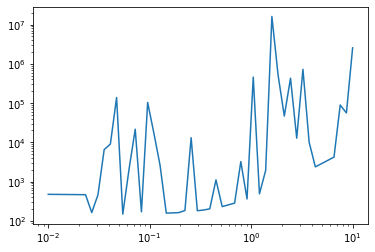

In [38]:
f0 = [(x['f']) for x in profiles[0]]
f0r = [np.exp(-(f0i-min(f0))) for f0i in f0]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f0)

In [39]:
list(zip(range(50), np.logspace(-2, 1, num=50),f0r))

[(0, 0.01, DM(1.5643e-141)),
 (1, 0.011513953993264475, DM(6.31715e-141)),
 (2, 0.013257113655901088, DM(2.80839e-140)),
 (3, 0.015264179671752334, DM(1.37706e-139)),
 (4, 0.017575106248547922, DM(7.46575e-139)),
 (5, 0.020235896477251575, DM(4.47115e-138)),
 (6, 0.023299518105153717, DM(2.94791e-137)),
 (7, 0.02682695795279726, DM(7.5986e-07)),
 (8, 0.030888435964774818, DM(1.68112e-135)),
 (9, 0.03556480306223128, DM(0)),
 (10, 0.040949150623804255, DM(0)),
 (11, 0.04714866363457394, DM(0)),
 (12, 0.054286754393238594, DM(1)),
 (13, 0.06250551925273973, DM(0)),
 (14, 0.07196856730011521, DM(0)),
 (15, 0.08286427728546843, DM(4.34789e-10)),
 (16, 0.09540954763499938, DM(0)),
 (17, 0.10985411419875583, DM(0)),
 (18, 0.12648552168552957, DM(0)),
 (19, 0.14563484775012436, DM(0.000146424)),
 (20, 0.16768329368110083, DM(1.43857e-05)),
 (21, 0.19306977288832497, DM(1.27561e-06)),
 (22, 0.22229964825261944, DM(1.07218e-15)),
 (23, 0.2559547922699536, DM(0)),
 (24, 0.29470517025518095, DM(7

In [40]:
a0 = linterp(0.011513953993264475, 0.013257113655901088, 0.145754, 0.152931, 0.15)
a1 = linterp( 0.2559547922699536, 0.29470517025518095, 0.314558, 0.115928,  0.15)
a0idx = [1, 2]
a1idx = [23, 24]

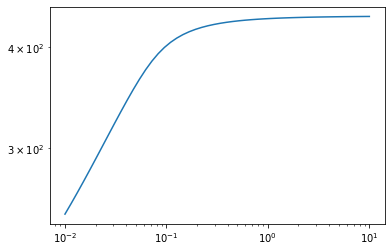

In [41]:
f1 = [(x['f']) for x in profiles[1]]
f1r = [np.exp(-(f1i-min(f1))) for f1i in f1]
plt.loglog(np.logspace(-2, 1, num=50).flatten(), f1)

In [42]:
list(zip(range(50), np.logspace(-2, 1, num=50),f1r))

[(0, 0.01, DM(1)),
 (1, 0.011513953993264475, DM(0.000474197)),
 (2, 0.013257113655901088, DM(1.40458e-07)),
 (3, 0.015264179671752334, DM(2.61198e-11)),
 (4, 0.017575106248547922, DM(3.08601e-15)),
 (5, 0.020235896477251575, DM(2.36293e-19)),
 (6, 0.023299518105153717, DM(1.20769e-23)),
 (7, 0.02682695795279726, DM(4.29653e-28)),
 (8, 0.030888435964774818, DM(1.12798e-32)),
 (9, 0.03556480306223128, DM(2.36914e-37)),
 (10, 0.040949150623804255, DM(4.4519e-42)),
 (11, 0.04714866363457394, DM(8.73703e-47)),
 (12, 0.054286754393238594, DM(2.21303e-51)),
 (13, 0.06250551925273973, DM(9.51336e-56)),
 (14, 0.07196856730011521, DM(9.35866e-60)),
 (15, 0.08286427728546843, DM(2.64636e-63)),
 (16, 0.09540954763499938, DM(2.34347e-66)),
 (17, 0.10985411419875583, DM(6.24287e-69)),
 (18, 0.12648552168552957, DM(4.46391e-71)),
 (19, 0.14563484775012436, DM(7.42681e-73)),
 (20, 0.16768329368110083, DM(2.49367e-74)),
 (21, 0.19306977288832497, DM(1.48856e-75)),
 (22, 0.22229964825261944, DM(1.42037

In [43]:
b0 = linterp(0.6866488450043002, 0.7906043210907697,0.105638 , 0.158776, 0.15)
b1 = linterp(2.8117686979742306,2.8117686979742308, 0.149, 0.151, 0.15)
b0idx = [30, 31]
b1idx = [40, 40]

In [44]:
r0int = [b0/a0, b0/a1, b1/a0, b1/a1]
r0int

[61.651772808241006, 2.6849982819238467, 224.13053183340259, 9.761115787718639]

In [45]:
def gets0(pdx, idx):
    return float(getx(profiles[pdx][idx]['x'])[0][0])
def means0(pdx, idxs):
    return np.mean([gets0(pdx, idx) for idx in idxs])
s0 = [means0(0, a0idx), means0(0, a1idx), means0(1,b0idx), means0(1,b1idx)]
def crossmean(axs, bxs):
    s = []
    for a in axs:
        for b in bxs:
            s.append(np.mean([a, b]))
    return s
s0mean = crossmean(s0[2:], s0[:2])

In [46]:
def rinft(r0,s0):
    f = lambda y: y/s0 - np.exp(r0*(y-s0)/s0) 
    sinf = brentq(f, 0, s0-1) 
    return s0-sinf
[rinft(r0x, s0x) for r0x, s0x in zip(r0int, s0mean)]

[5690.355421686343, 5175.9359070975925, 5679.112967058161, 5650.910022674196]

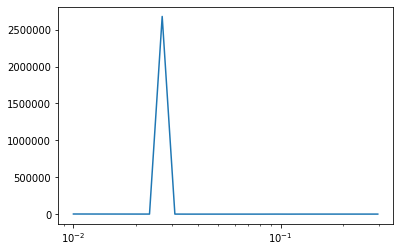

In [47]:
f2 = [(x['f']) for x in profiles[2]]
plt.semilogx(np.logspace(-2, 1, num=50).flatten()[:25], f2[:25])

In [48]:
def mod_seir(t, y, p):
    for i, yi in enumerate(y):
        if yi < 0:
            y[i] = 0 
    return seir(t, y, p)

In [49]:
from scipy.integrate import solve_ivp
tidx = 45
print(model.observation_times[tidx])
sol = solve_ivp(lambda t,y: mod_seir(t, y, getp(sols[idx]['x'])), [0, 150], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], dense_output=True)
# solb = solve_ivp(lambda t,y: np.array(mod_seir(t, y, getp(sols[idx]['x']))), [0, -20], [getx(sols[idx]['x'])[i][tidx] for i in range(5)], method='BDF', dense_output=True)

78.18181818181819


In [50]:
[getx(sols[idx]['x'])[i][tidx] for i in range(5)]

[DM(4511.64), DM(503.404), DM(115.506), DM(159.301), DM(806.203)]

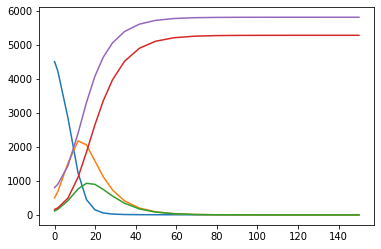

In [51]:
plt.plot(sol.t, sol.y[:,:].T)

In [52]:
plt.plot(solb.t, solb.y.T)

NameError: name 'solb' is not defined

In [ ]:
model.observation_times[-1]

In [ ]:
tfine = np.linspace(0, 150, 600)
# tbfine = np.linspace(0, -20, 20)
plt.figure(figsize=[13, 8], dpi=240)
# plt.plot(tbfine+model.observation_times[tidx], solb.sol(tbfine)[-1,:].T)
plt.plot(tfine+model.observation_times[tidx], sol.sol(tfine)[-1,:].T)
plt.plot(times, cumdata, 'o')
plt.xlim(0, 140)
plt.legend(["Prediction", "Reported Data"])
plt.xlabel("Days since 28 August 2019")
plt.ylabel("# Cases")
plt.title("Number of Reported Cases (Prediction)")

plt.plot(model.observation_times, getx(sols[idx]['x'])[4], label='Prediction')


In [ ]:
rfin = sol.sol(tfine)[-1,-1]
rfin

In [ ]:
ridx = np.argmin(np.abs(((1-(sol.sol(tfine)[-1,:])/rfin)*100) - 5))

In [ ]:
tfine[ridx]

In [ ]:
tfine[ridx]-(model.observation_times[-1]-model.observation_times[tidx])

In [ ]:
model.observation_times[-1]-model.observation_times[tidx]

In [ ]:
historical_mortality = 0.02
current_mortality = D[-1]/cumdata[-1]
print(historical_mortality, current_mortality)

In [ ]:
rfin*historical_mortality

In [ ]:
rfin*current_mortality

In [ ]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors
i0, i1 = (1, -1)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.figure(figsize=[13,8], dpi=60)
for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, np.gradient(getx(sols[i]['x'])[4].toarray().flatten(), model.observation_times),
            color=scalarMap.to_rgba(np.log10(p)), alpha=0.3)
plt.plot(times, np.gradient(cumdata, times), 'ro')
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)